Analyse des résultats de l'étude de recherche sur la résolution collaborative des problèmes

Les question centrales de l'étude :
 - Comment se passe la résolution collaborative des problèmes de sciences ?
 - Cmt les apprenants travaillent-ils ensemble ?
 - Existent-ils des dimensions de la collaboration pour lesquels il y a plus de difficultés ?
 - LEs dimensions sont-elles fortement liées ?

 Les données à analyser proviennent d'un questionnaire rempli par les élèves à la suite des séances de travail en groupe. Il s'agit dont de leur perception.

 Les élèves proviennent de 2 écoles :
  - La 1ère compte 9 groupes encadrés par 2 esnseignants
  - La seconde 1 seul groupe

Les élèves sont répartits en équipes d'environ 5 participants.

NOUS ALLONS EFFECTUER QUELQUES ANALYSES DESCRIPTIVES DU FICHIER

In [ ]:
# import des librairies nécessaires pour l'analyse

# Ajoute le dossier parent (racine du projet) au chemin de recherche de Python


import pandas as pd
import numpy as np
from itables import init_notebook_mode # pour parcourir visuellement les données
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import chi2_contingency
import prince # pour effectuer l'ACM
import textwrap # permet de traiter le texte
import os 
import json

import sys
# permet de prendre en compte le dossier courant dans la recherche de librairies.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) 

import src.visualizations as viz
import src.modelisation as model

### Initialisation des chemins vers les dossiers intéressants
root_path = os.path.join("..")
folder_raw = os.path.join(root_path,"data","raw")
folder_interim = os.path.join(root_path,"data","interim")
folder_processed = os.path.join(root_path,"data","processed")
folder_viz = os.path.join(root_path,"visualizations")

folder_uni = os.path.join(folder_viz,'Statistiques univariées') # dossier où enregistrer les images
os.makedirs(folder_uni, exist_ok=True)

folder_biv = os.path.join(folder_viz,'Statistiques bivariées') # dossier où enregistrer les images
os.makedirs(folder_biv, exist_ok=True)




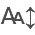

In [38]:
# initialisation de itables
init_notebook_mode(all_interactive=True)

In [39]:
df=pd.read_parquet(os.path.join(folder_interim,'cleaned.parquet'))
df.columns

Index(['id', 'ecole', 'groupe', 'equipe', 'nbPersEq', 'q1', 'q2', 'q3', 'q4',
       'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15',
       'q16', 'q17', 'genre', 'quali1', 'quali2', 'quali3', 'quali4', 'quali5',
       'quali6', 'equipe2', 'nbPersEq2'],
      dtype='object')

Gestion des données manquantes

Stratégie d'imputation :
 - nbPersEq : valeur la plus fréquente de l'équipe. Il est préférable de se créer un référentiel à partir des données connues.
 - q1 à  q17 : mode de réponse dans le groupe
 - genre : identifcation à partir du nom
 - variable quali : sans changement

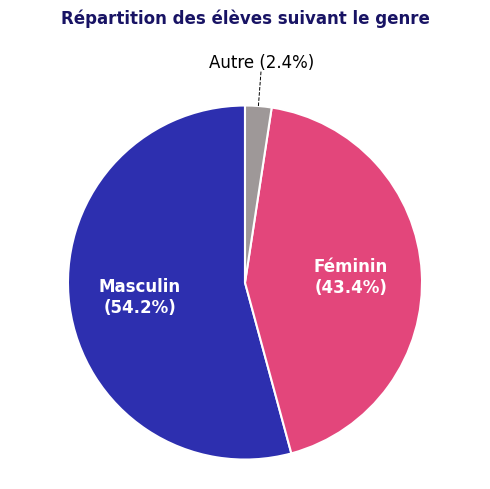

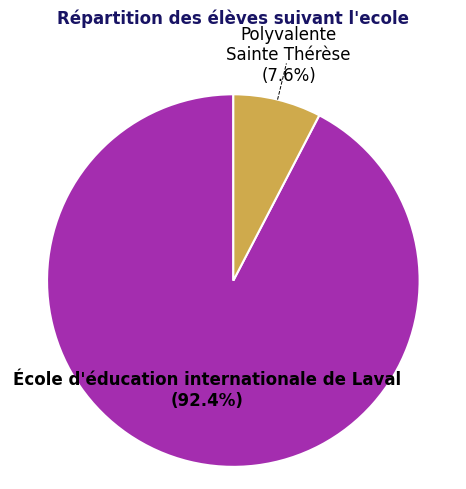

In [30]:
## Production de Pie chart pour différentes variables

col = 'genre'
tab = df[col].value_counts()
sizes = tab.values
labels = tab.index
colors = ["#1618A6E6", "#DE2563D8", "#9E9898"]
title = f'Répartition des élèves suivant le {col}'
viz.pieCharts(sizes=sizes,labels=labels,title=title,partColors=colors,folder=folder_uni,file_name='Genre.png')


col = 'ecole'
tab = df[col].value_counts()
sizes = tab.values
labels = tab.index
colors = ["#9A16A6E6", "#C69A2BD7"]
title = f"Répartition des élèves suivant l'{col}"
viz.pieCharts(sizes=sizes,labels=labels,title=title,partColors=colors,labelInsideColors='black',
          folder=folder_uni,file_name='Écoles.png')


#col = 'nbPersEq2'
#tab = df2[col].value_counts().sort_index()
#sizes = tab.values
#labels = tab.index
#colors = ["#EF7BADE6", "#E63481E6", "#EC096CE6", "#8F0641E6"]
#title = "Répartition des élèves suivant \n le nombre de personnes par équipe"
#pieCharts(sizes=sizes,labels=labels,title=title,partColors=colors,threshold=15,
#          folder=folder,file_name='Nombre de personnes par équipe.png')

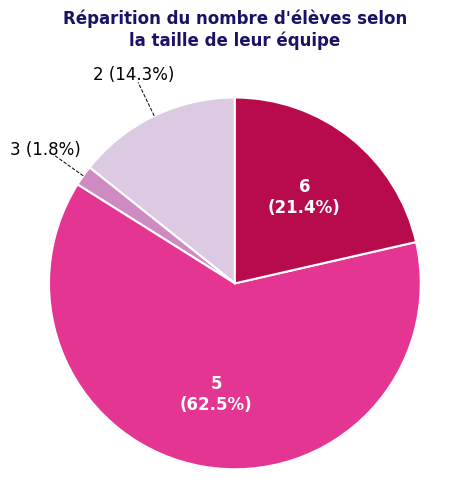

In [31]:
# Répartition des équipes selon leur taille
tab = df.groupby('nbPersEq2', observed=False)['equipe2'].nunique()
sizes = tab.values
labels = tab.index
colors = sns.color_palette('PuRd', n_colors=len(sizes))
title = textwrap.fill("Réparition du nombre d'élèves selon la taille de leur équipe",width=35)
viz.pieCharts(sizes=sizes,labels=labels,title=title,partColors=colors,threshold=15,folder=folder_uni,file_name='Taille des Equipes.png')

Production de quelques KPIs relatifs à constitution des groupes et utiles pour la présentation

In [6]:
# Nombre de groupes
print(f"Nombre de groupes : {df['groupe'].nunique()}")
# Nombre d'équipes
print(f"Nombre d'équipes : {df['groupe'].nunique()}")
# Nombre moyen de personnes par équipe
tab = df.groupby('nbPersEq2', observed=False)['equipe2'].nunique()
nb_moy = (pd.Series(tab.index).astype(int) * tab.values).sum() / tab.values.sum()
print(f"En moyenne une équipe compte : {nb_moy} apprenants")
# Nombre moyen de personnes par équipe selon l'école
for ecole in df['ecole'].unique():
    tab = df[df['ecole'] == ecole].groupby('nbPersEq2', observed=False)['equipe2'].nunique()
    nb_moy = (pd.Series(tab.index).astype(int) * tab.values).sum() / tab.values.sum()
    print(f"En moyenne une équipe de l'ecole {ecole} compte : {nb_moy:.2f} apprenants")


Nombre de groupes : 10
Nombre d'équipes : 10
En moyenne une équipe compte : 4.75 apprenants
En moyenne une équipe de l'ecole École d'éducation internationale de Laval compte : 5.26 apprenants
En moyenne une équipe de l'ecole Polyvalente Sainte Thérèse compte : 2.11 apprenants


Dans la section ci-dessous, nous allons produire les barplots des différentes variables d'intérêt

In [7]:
##################################################################################
######     On récupère le dictionnaire des noms complet des variables 
##################################################################################

with open(os.path.join(folder_processed, 'nom_des_variables.json'), 'r') as f:
    refColonnes = json.load(f)

# Définition du dictionnaire de labels
labels_map = {
    1: "Pas du tout d'accord",
    2: "Pas d'accord",
    3: "Je ne sais pas",
    4: "D'accord",
    5: "Tout à fait d'accord"
}


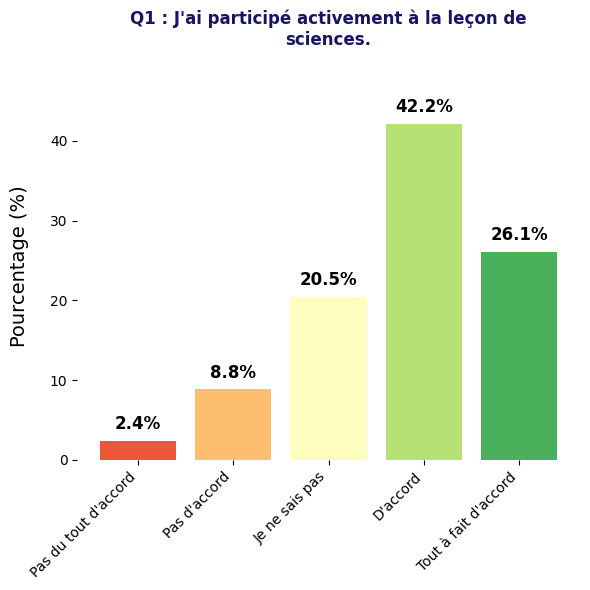

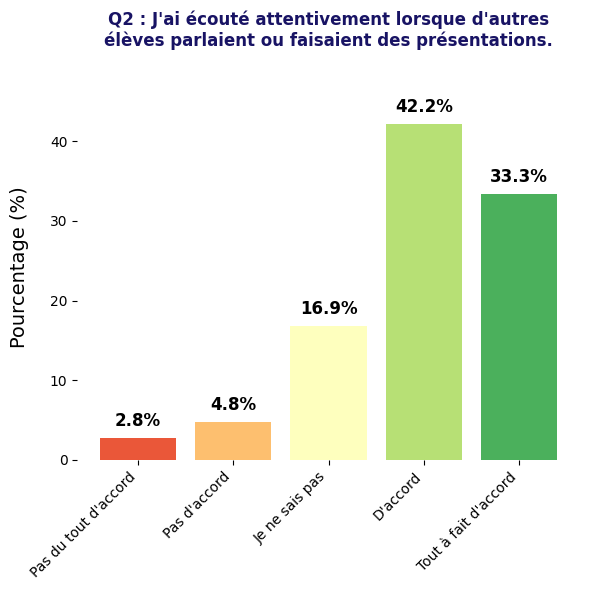

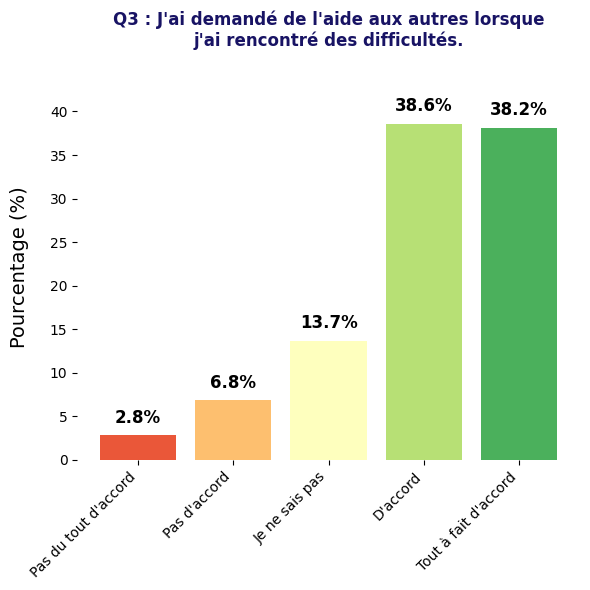

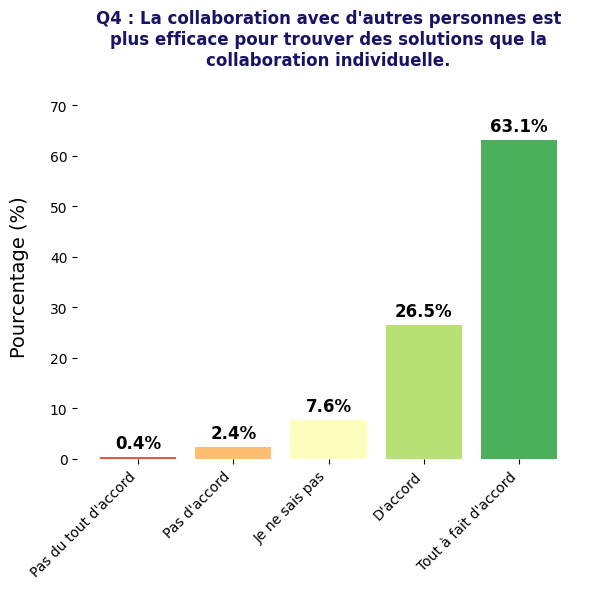

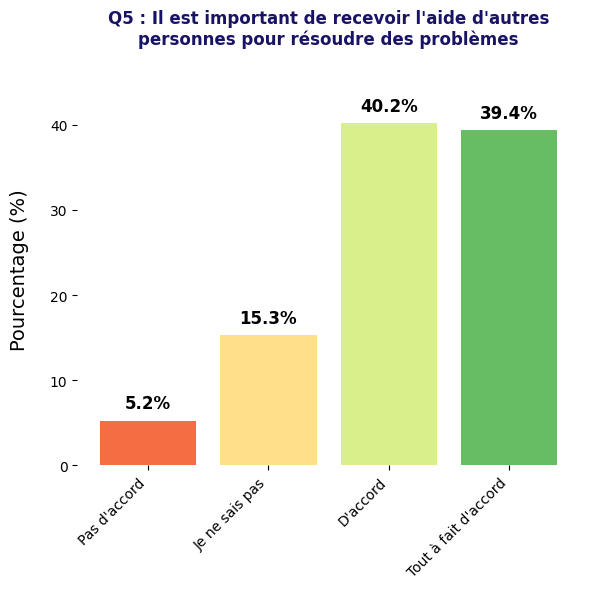

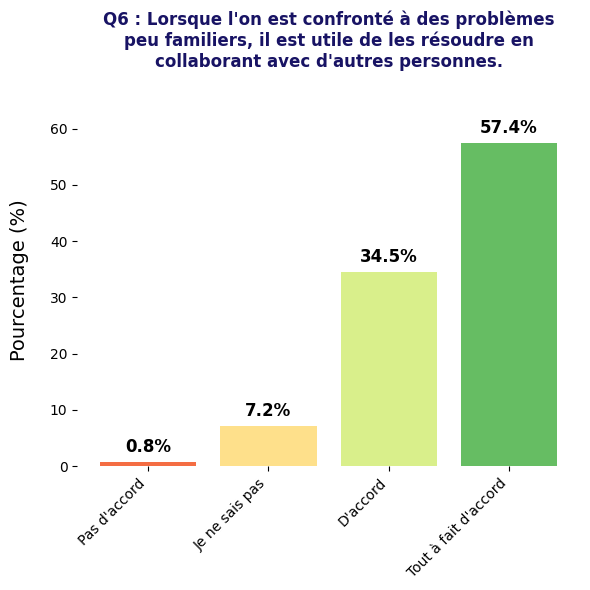

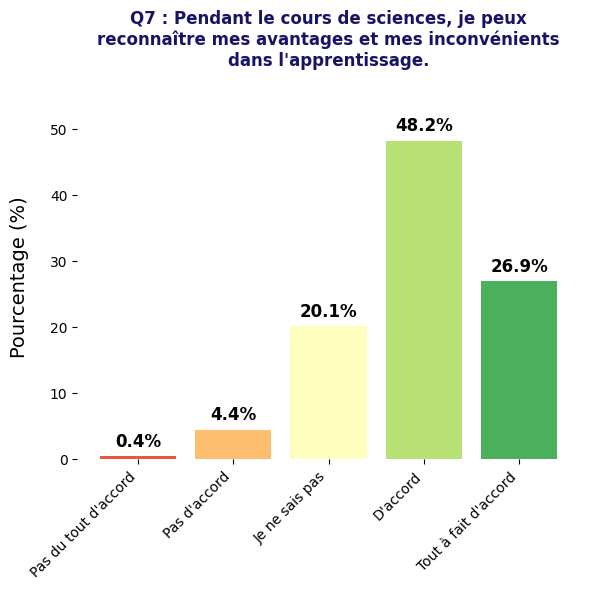

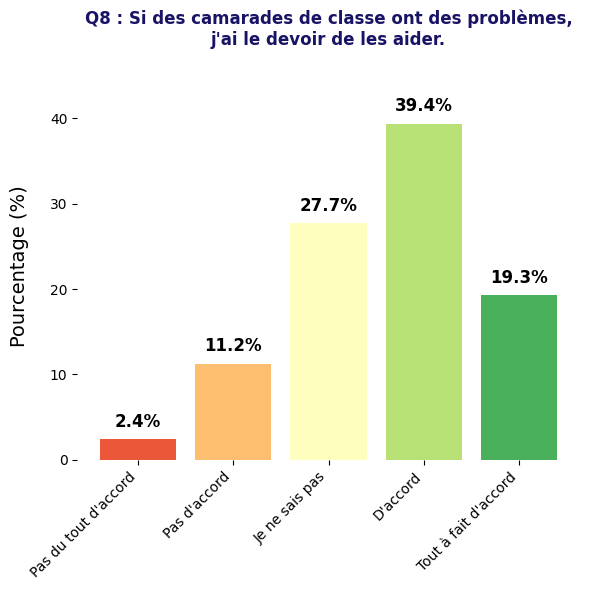

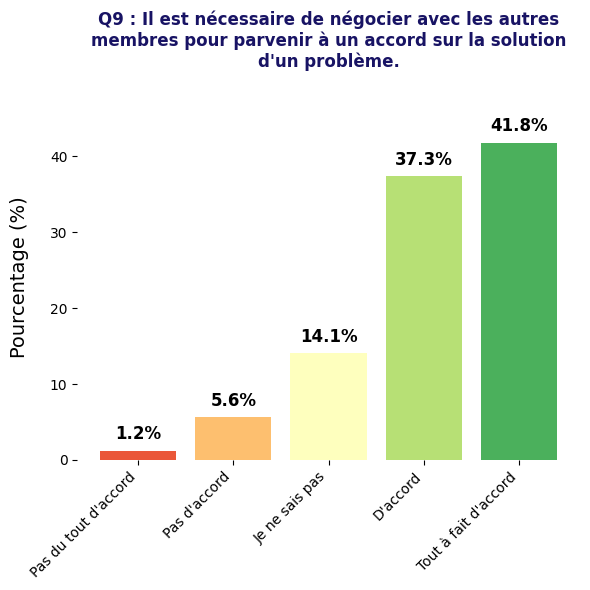

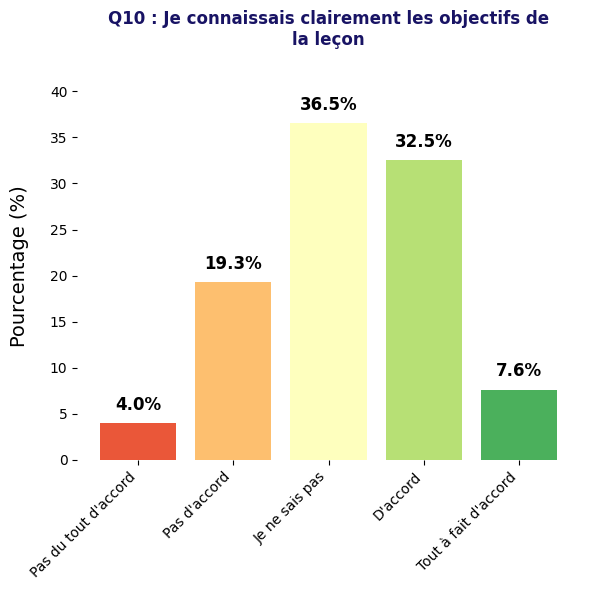

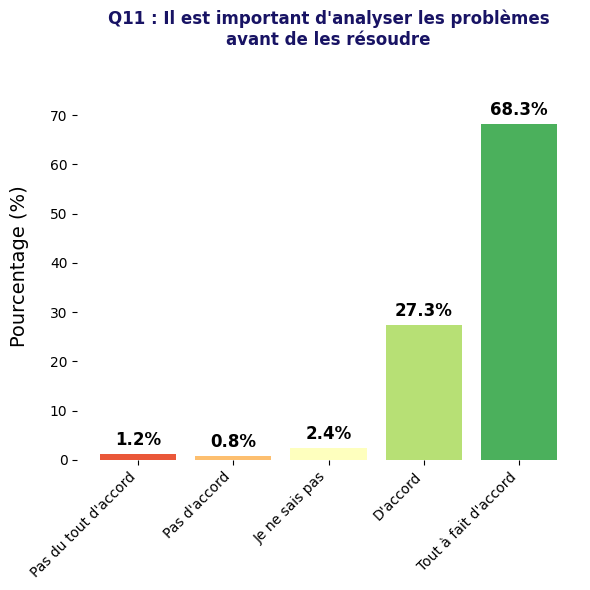

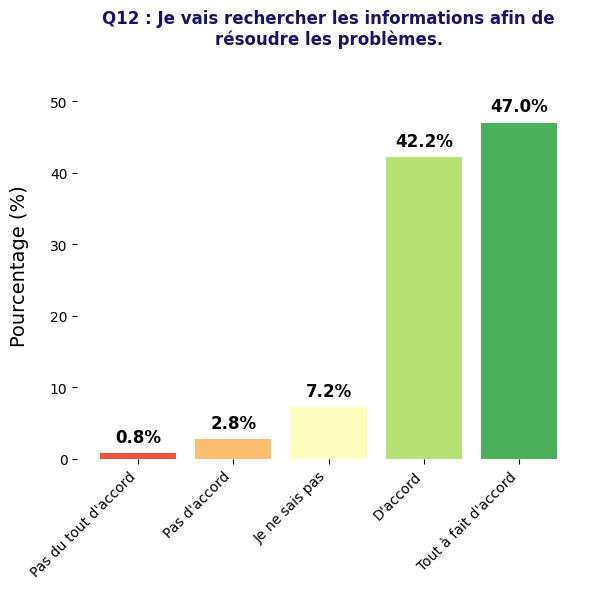

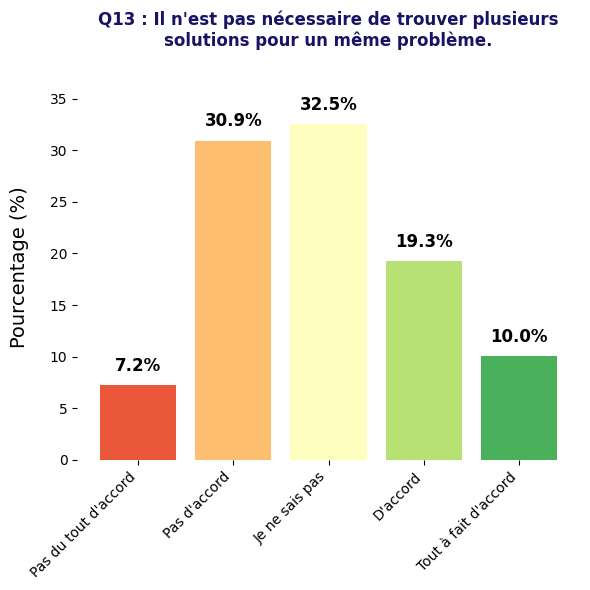

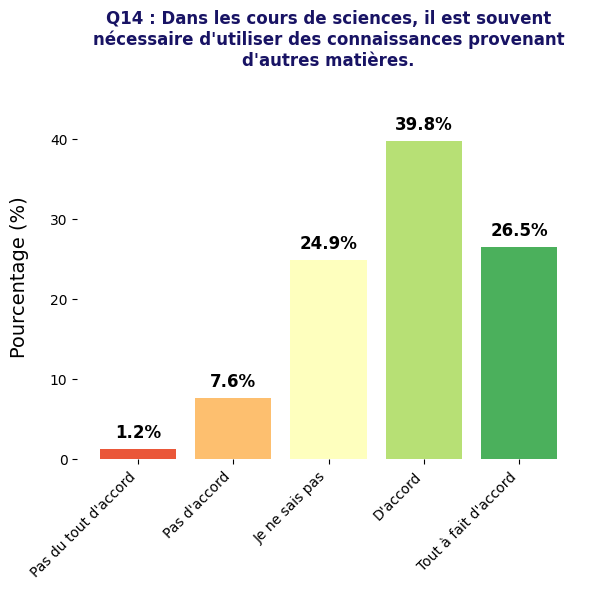

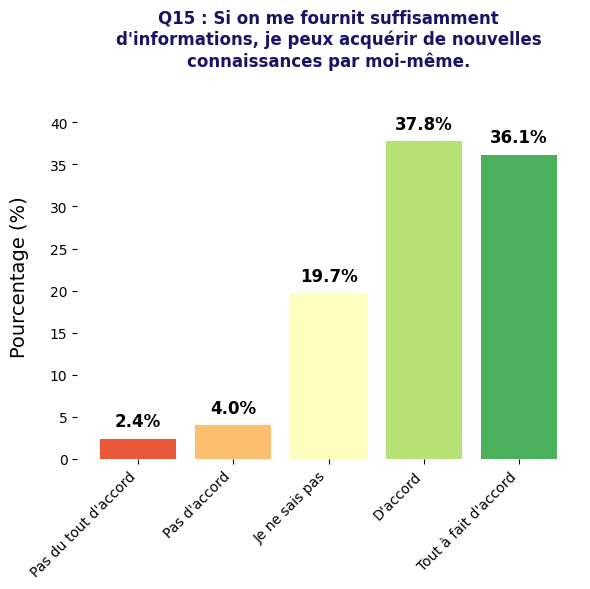

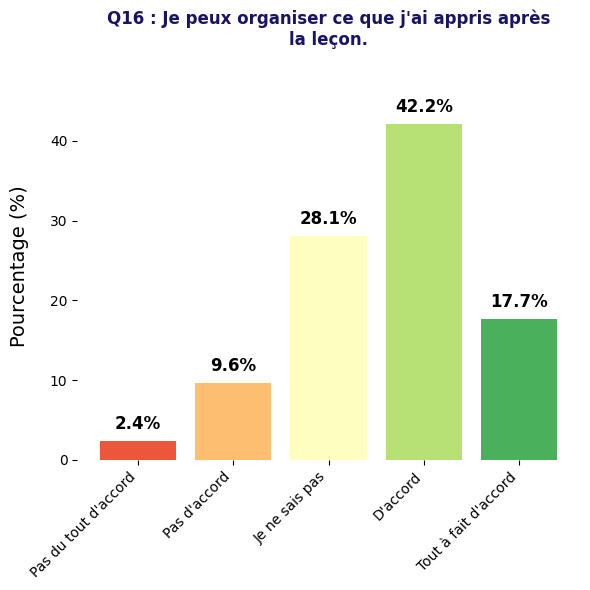

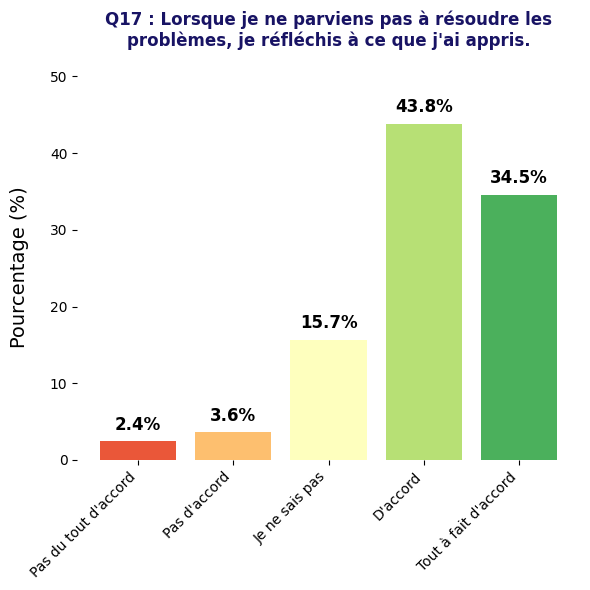

In [40]:
#-- On trace les tris à plats des questions à échelle

colBarPlot = ['q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']
viz.barplot_multiple(df=df,cols=colBarPlot,folder=folder_uni)
#-- Pour ne pas avoir un notebook trop long, on va juste afficher quelques barplots
#viz.barplot_multiple(df=df,cols=['q1','q2'])

On va regrouper les modalités de certaines variables pour la suite car la présence de modalités rares peut masquer des effets.
Voici les changements qui seront opérés :
 - Regroupement des 3 premières modalités ('pas du tout d'accord', 'Pas D'accord' et 'Je ne sais pas') pour les variables q1-q7, q9, q11, q12, q17 --> elle sera renommée en 'Pas vraiment d'Accord'
 - Regroupement des 2 premières modalités ('pas du tout d'accord', 'Pas D'accord') pour les variables q8, q10, q14, q15 et q16 --> Elle sera renommée en 'Pas D'accord'
 - Regroupement des 2 premières et 2 derniès classe pour la variable q13

TEST CHI2 ET V-CRAMER

Ici on va :
 - CALCULER LE TEST DU CHI2 POUR VOIR LA FORCE ENTRE LES VARIABLES CATEGORIELLES
 - Calculer les V-cramer
 - Ces 2 matrix seront représentées via une heatmap


Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


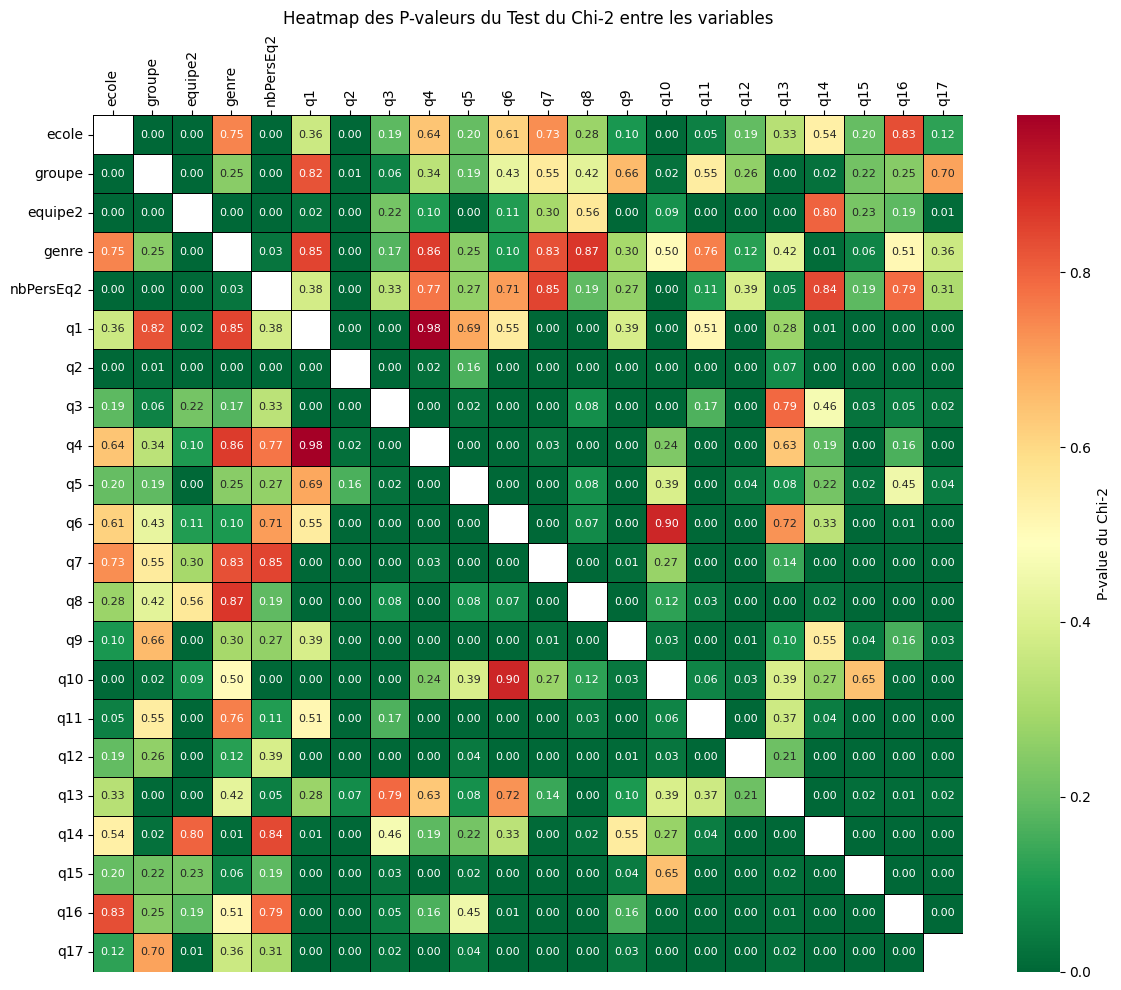

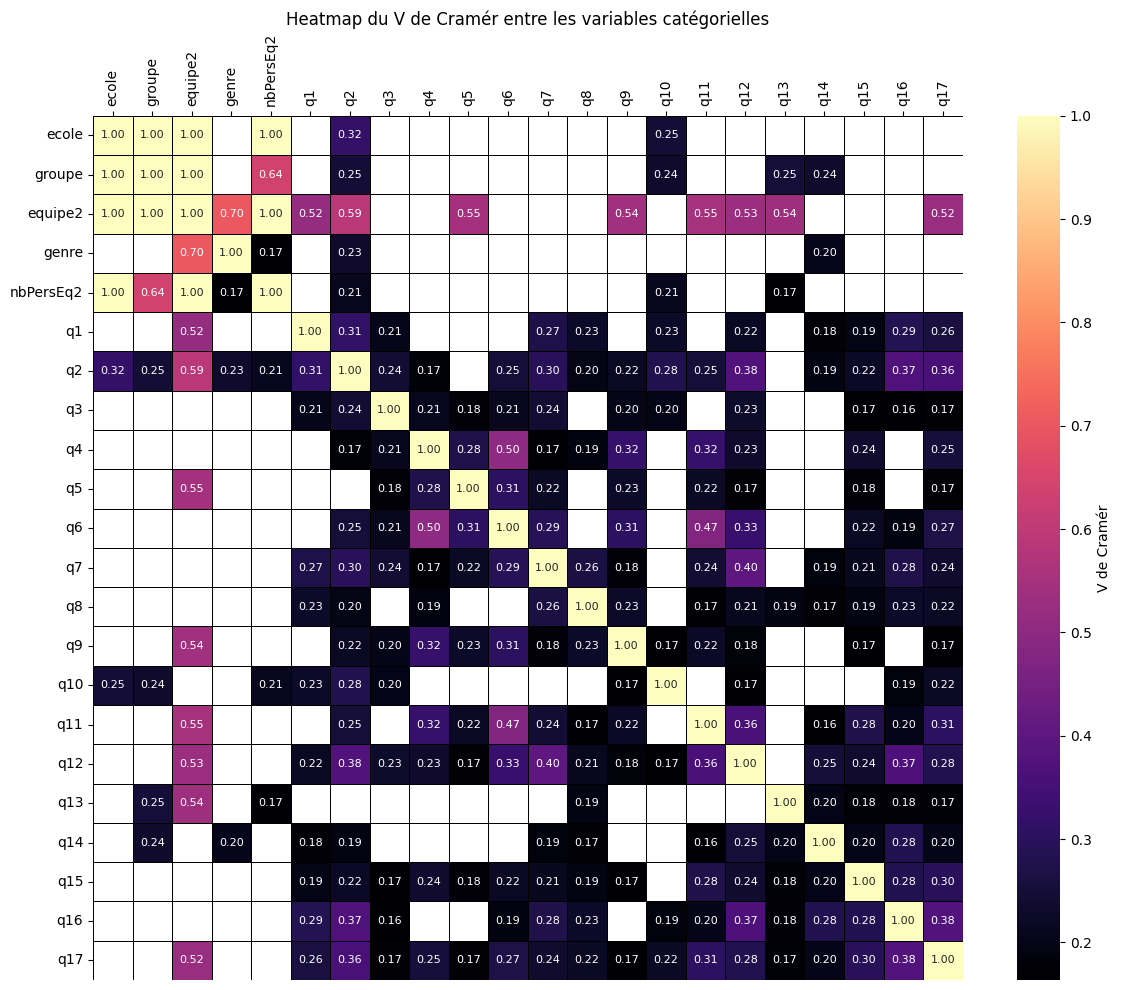

In [41]:
colonnes_qualitatives = ['ecole', 'groupe', 'equipe2', 'genre', 'nbPersEq2', 'q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8', 
                         'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']

#On teste les fonctions créées
#colsQ = ['q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8','q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']

cramers_v_matrix, chi2_pvalue_matrix = viz.v_cramer_matrix(df,colonnes_qualitatives)


viz.heat_chi2(chi2_pvalue_matrix, folder=folder_biv, file_name='Chi2-fisrt attempt.png')
viz.heat_v(cramers_v_matrix, folder=folder_biv, file_name='V_Cramer-fisrt attempt.png')


On va regrouper les modalités de certaines variables pour la suite car la présence de modalités rares peut masquer des effets.
Voici les changements qui seront opérés :
 - Regroupement des 3 premières modalités ('pas du tout d'accord', 'Pas D'accord' et 'Je ne sais pas') pour les variables q1-q7, q9, q11, q12, q17 --> elle sera renommée en 'Pas vraiment d'Accord'
 - Regroupement des 2 premières modalités ('pas du tout d'accord', 'Pas D'accord') pour les variables q8, q10, q14, q15 et q16 --> Elle sera renommée en 'Pas D'accord'
 - Regroupement des 2 premières et 2 derniès classe pour la variable q13

In [42]:
# On effectue le premier regroupement

df3 = df.copy()
group1 = ['q1','q2','q3','q4','q5','q6','q7','q9','q11','q12','q17']
labels_map = {
    3: "Pas tout à fait d'accord",
    4: "D'accord",
    5: "Tout à fait d'accord"
}
echelle4 = pd.CategoricalDtype(categories=[3,4,5], ordered=True)
for col in group1:
    ids = df3[df3[col] <= 2].index 
    df3.loc[ids,col] = 3
    df3[col] = df3[col].astype(echelle4)
    df3[col] = df3[col].cat.rename_categories(labels_map)

# On effectue le second regroupement
group1 = ['q8','q10','q14','q15','q16']
labels_map = {
    2: "Pas d'accord",
    3: "Je ne sais pas",
    4: "D'accord",
    5: "Tout à fait d'accord"
}
echelle5 = pd.CategoricalDtype(categories=[2,3,4,5], ordered=True)
for col in group1:
    ids = df3[df3[col] == 1].index 
    df3.loc[ids,col] = 2
    df3[col] = df3[col].astype(echelle5)
    df3[col] = df3[col].cat.rename_categories(labels_map)

# on effectue le dernier regroupement
col = 'q13'
df3.loc[df3[col] == 1,col] = 2
df3.loc[df3[col] == 5,col] = 4
echelle6 = pd.CategoricalDtype(categories=[2,3,4], ordered=True)
df3[col] = df3[col].astype(echelle6)
labels_map = {
    2: "Pas d'accord",
    3: "Je ne sais pas",
    4: "D'accord"
}
df3[col] = df3[col].cat.rename_categories(labels_map)


Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


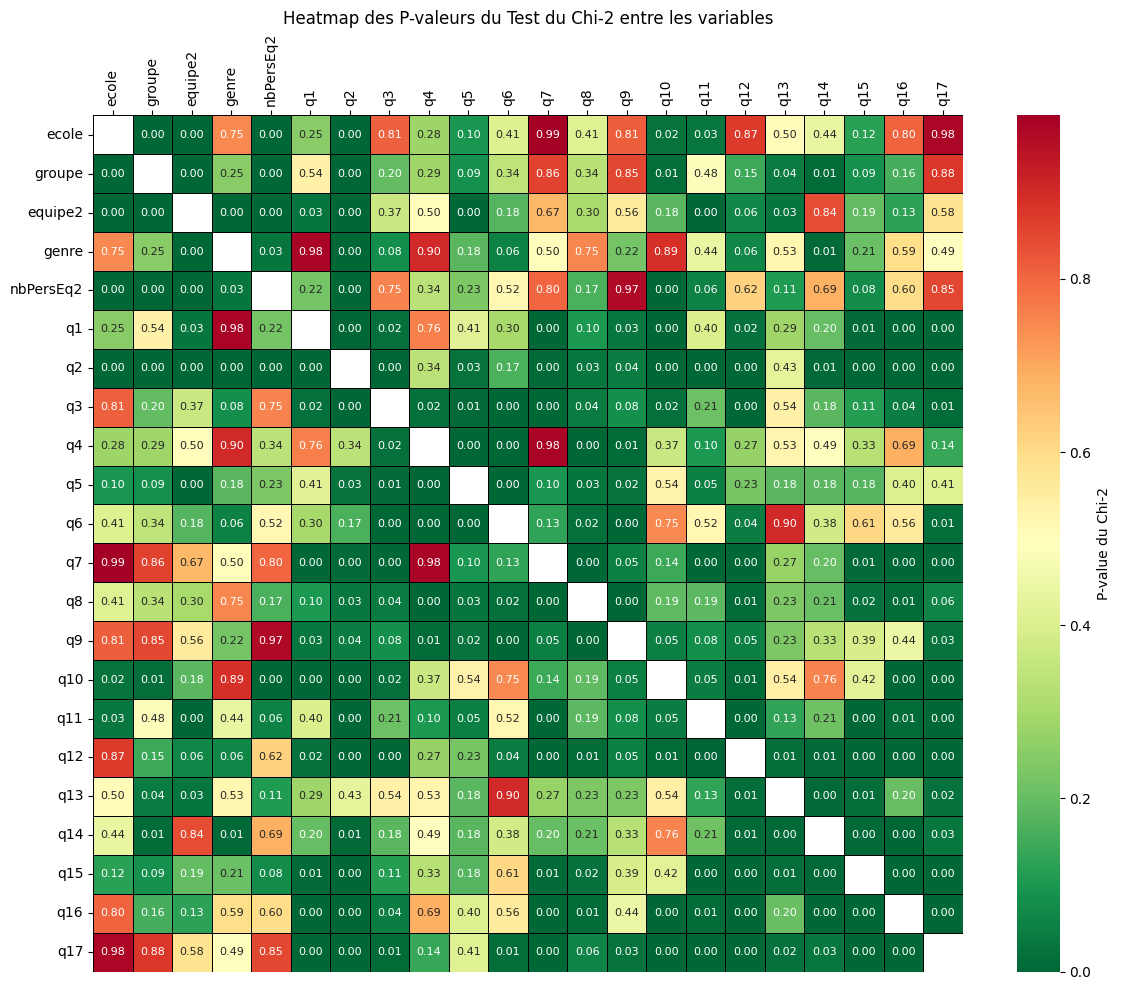

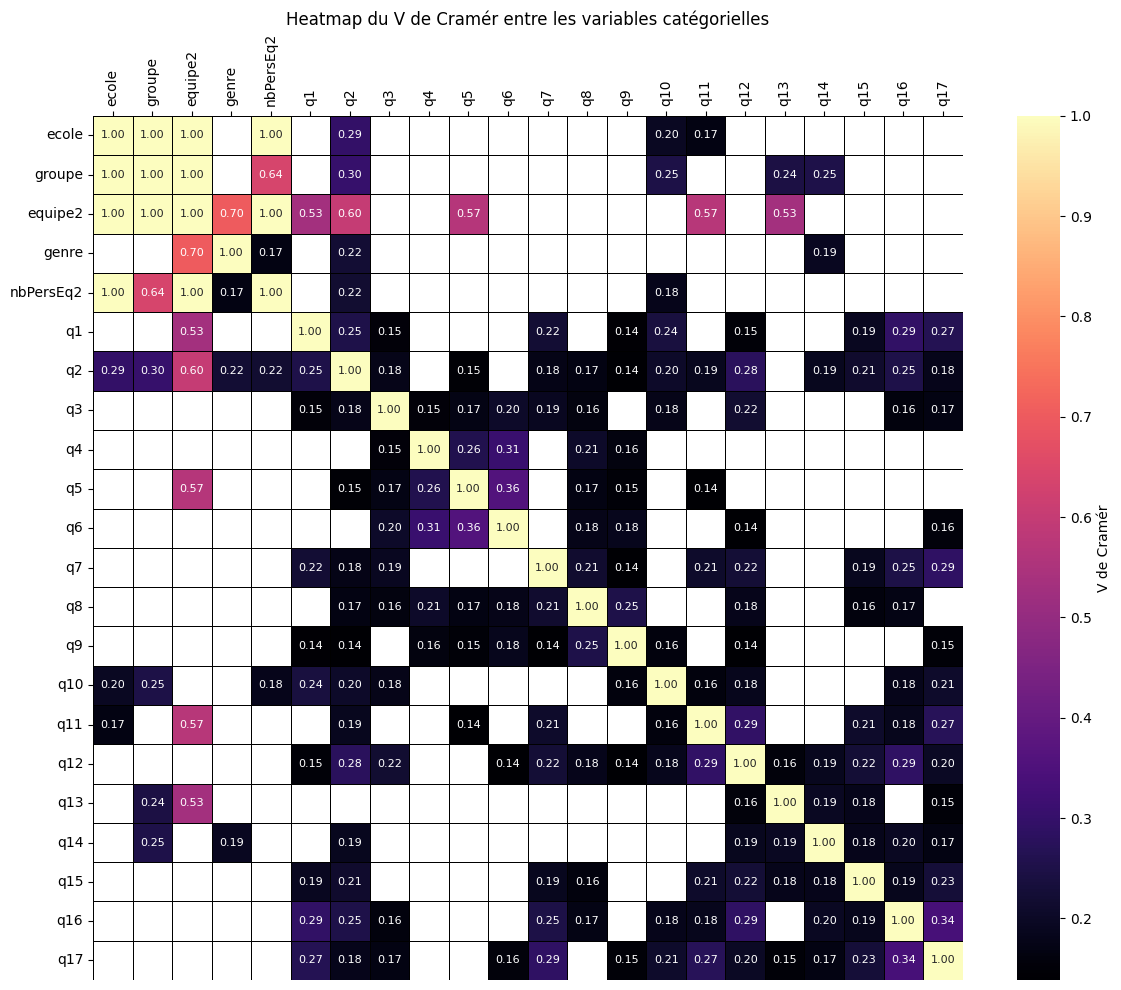

In [24]:

# On refait les chi2 et v de cramer
#On teste les fonctions créées
#colsQ = ['q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8','q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']
folder = os.path.join(folder_viz,'Statistiques biariées') # dossier où enregistrer les images
os.makedirs(folder, exist_ok=True)

cramers_v_matrix, chi2_pvalue_matrix = viz.v_cramer_matrix(df3,colonnes_qualitatives)
#cramers_v_matrix, chi2_pvalue_matrix = v_cramer_matrix(df3,colsQ)

viz.heat_chi2(chi2_pvalue_matrix, folder=folder, file_name='Chi2-final.png')

viz.heat_v(cramers_v_matrix, folder=folder, file_name='V_Cramer-final.png')



In [43]:
############
### Identifiions les paires de questions selon la force de leur lien (Fort, modéré, faible)
### Voici la règle Fort : V_cramer >= 0.3, Modéré : V_cramer entre 0.1 et 0.3, faible V_cramer < 0.1.
### On va exclure les valeurs 1 (car C'est la même variable et 0 ou null)

corrStrength = {'High': [],  'Medium': [], 'Low': [] }

nbVars = len(colonnes_qualitatives)
for i in range(nbVars):
    for j in range(i+1,nbVars):
        col1 = colonnes_qualitatives[i]
        col2 = colonnes_qualitatives[j]
        v =  cramers_v_matrix.loc[col1,col2]
        if (np.isnan(v)) | (v>=0.99999) | ( v <= 0.00001 ): # ici on passe à la prochaine cellule car le v de cramer n'est pas interprétable
            continue
        elif (v < 0.2):
            corrStrength['Low'].append((col1,col2))
        elif (v < 0.5):
            corrStrength['Medium'].append((col1,col2))
        else:
            corrStrength['High'].append((col1,col2))


corrStrength

{'High': [('groupe', 'nbPersEq2'),
  ('equipe2', 'genre'),
  ('equipe2', 'q1'),
  ('equipe2', 'q2'),
  ('equipe2', 'q5'),
  ('equipe2', 'q9'),
  ('equipe2', 'q11'),
  ('equipe2', 'q12'),
  ('equipe2', 'q13'),
  ('equipe2', 'q17'),
  ('q4', 'q6')],
 'Medium': [('ecole', 'q2'),
  ('ecole', 'q10'),
  ('groupe', 'q2'),
  ('groupe', 'q10'),
  ('groupe', 'q13'),
  ('groupe', 'q14'),
  ('genre', 'q2'),
  ('genre', 'q14'),
  ('nbPersEq2', 'q2'),
  ('nbPersEq2', 'q10'),
  ('q1', 'q2'),
  ('q1', 'q3'),
  ('q1', 'q7'),
  ('q1', 'q8'),
  ('q1', 'q10'),
  ('q1', 'q12'),
  ('q1', 'q16'),
  ('q1', 'q17'),
  ('q2', 'q3'),
  ('q2', 'q6'),
  ('q2', 'q7'),
  ('q2', 'q9'),
  ('q2', 'q10'),
  ('q2', 'q11'),
  ('q2', 'q12'),
  ('q2', 'q15'),
  ('q2', 'q16'),
  ('q2', 'q17'),
  ('q3', 'q4'),
  ('q3', 'q6'),
  ('q3', 'q7'),
  ('q3', 'q9'),
  ('q3', 'q12'),
  ('q4', 'q5'),
  ('q4', 'q9'),
  ('q4', 'q11'),
  ('q4', 'q12'),
  ('q4', 'q15'),
  ('q4', 'q17'),
  ('q5', 'q6'),
  ('q5', 'q7'),
  ('q5', 'q9'),
  ('q5'

Dans les sections ci-dessous, nous allons créer des barplots des variales prises 2 à 2 afin de visualiser leur liaison à priori

In [50]:
import src.visualizations as viz

In [49]:
colBarPlot = ['q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']
nbVars = len(colBarPlot)

for i in range(nbVars):
    for j in range(i+1,nbVars):
        viz.barh(data=df3,col1=colBarPlot[i],col2=colBarPlot[j],folder=folder_biv)

AttributeError: module 'src.visualizations' has no attribute 'barh'

In [51]:
colBarPlot = ['q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']
nbVars = len(colBarPlot)
for i in range(nbVars):
    for j in range(i+1,nbVars):
        viz.barv(data=df3,col1=colBarPlot[i],col2=colBarPlot[j],folder=folder_biv,show_plot=True)

AttributeError: module 'src.visualizations' has no attribute 'barv'

In [25]:
### Barplots pour certains couples de variables sélectionnées
refColonnes['equipe2'] = 'equipe'
#barh(data=df3,col1='equipe2',col2='genre')

tab = pd.crosstab(df3['equipe2'],df3['genre'], normalize='index')

#On regroupe les équipes suivant 3 grandes catégories : 100% Masculin, 100% Féminin et Mixte
g1 = tab[tab.iloc[:,1] == 1].index
tab.loc[g1,'TypeEq'] = 'Féminine'
g2 = tab[tab.iloc[:,2] == 1].index
tab.loc[g2,'TypeEq'] = 'Masculine'
tab.loc[tab['TypeEq'].isna(),'TypeEq'] = 'Mixte'
tab.value_counts('TypeEq')

TypeEq
Masculine    22
Féminine     18
Mixte        16
Name: count, dtype: int64

In [26]:
# On ajoute le type d'équipe comme variables dans le dataFrame initial
typeEq = {col: value for col, value in zip(tab.index, tab['TypeEq'])}

df3['typeEq'] = df3['equipe2'].map(typeEq)

df3['typeEq'].value_counts()


typeEq
Masculine    95
Mixte        78
Féminine     76
Name: count, dtype: int64

In [27]:
# Enregistrement de df3 au format parquet pour le réutiliser plus tard sans soucis

df3.to_parquet('df3_analyses.parquet') 

ACM AVEC PRINCE 

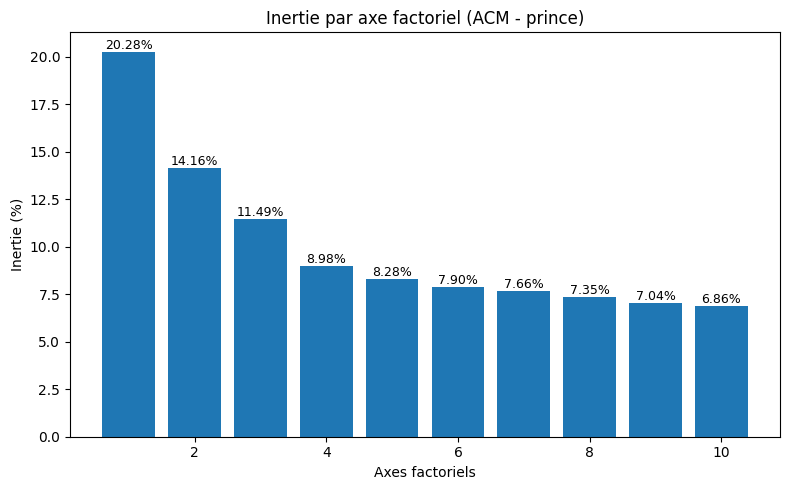

Catégories bien représentées (cos² ≥ 0.10) :
Axe 1 : ["q1__Pas tout à fait d'accord", "q1__Tout à fait d'accord", "q2__Pas tout à fait d'accord", "q2__Tout à fait
d'accord", "q3__Pas tout à fait d'accord", "q3__Tout à fait d'accord", "q6__Tout à fait d'accord", "q7__Pas tout à fait
d'accord", "q7__Tout à fait d'accord", "q8__Pas d'accord", "q9__Pas tout à fait d'accord", "q9__Tout à fait d'accord",
"q10__Pas d'accord", "q11__Pas tout à fait d'accord", "q11__Tout à fait d'accord", "q12__Pas tout à fait d'accord",
"q12__Tout à fait d'accord", "q14__Pas d'accord", "q15__Pas d'accord", "q16__Pas d'accord", "q16__Tout à fait d'accord",
"q17__Pas tout à fait d'accord", "q17__Tout à fait d'accord"]
Axe 2 : ["q2__D'accord", "q5__Tout à fait d'accord", "q6__D'accord", "q6__Tout à fait d'accord", "q7__D'accord", "q7__Tout à
fait d'accord", "q8__Tout à fait d'accord", "q12__D'accord", "q13__D'accord", "q14__D'accord", "q16__Pas d'accord",
"q17__D'accord", "q17__Tout à fait d'accord"]
Axe 3 : ["q1

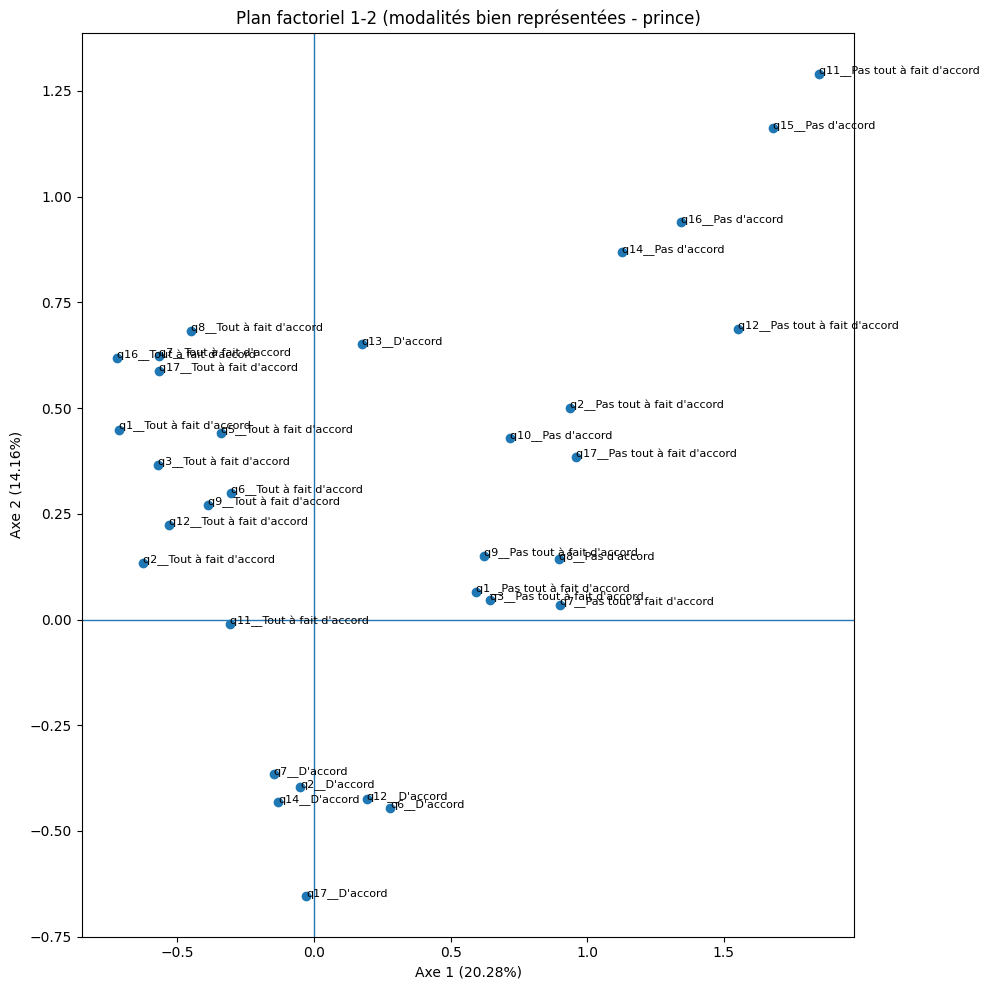

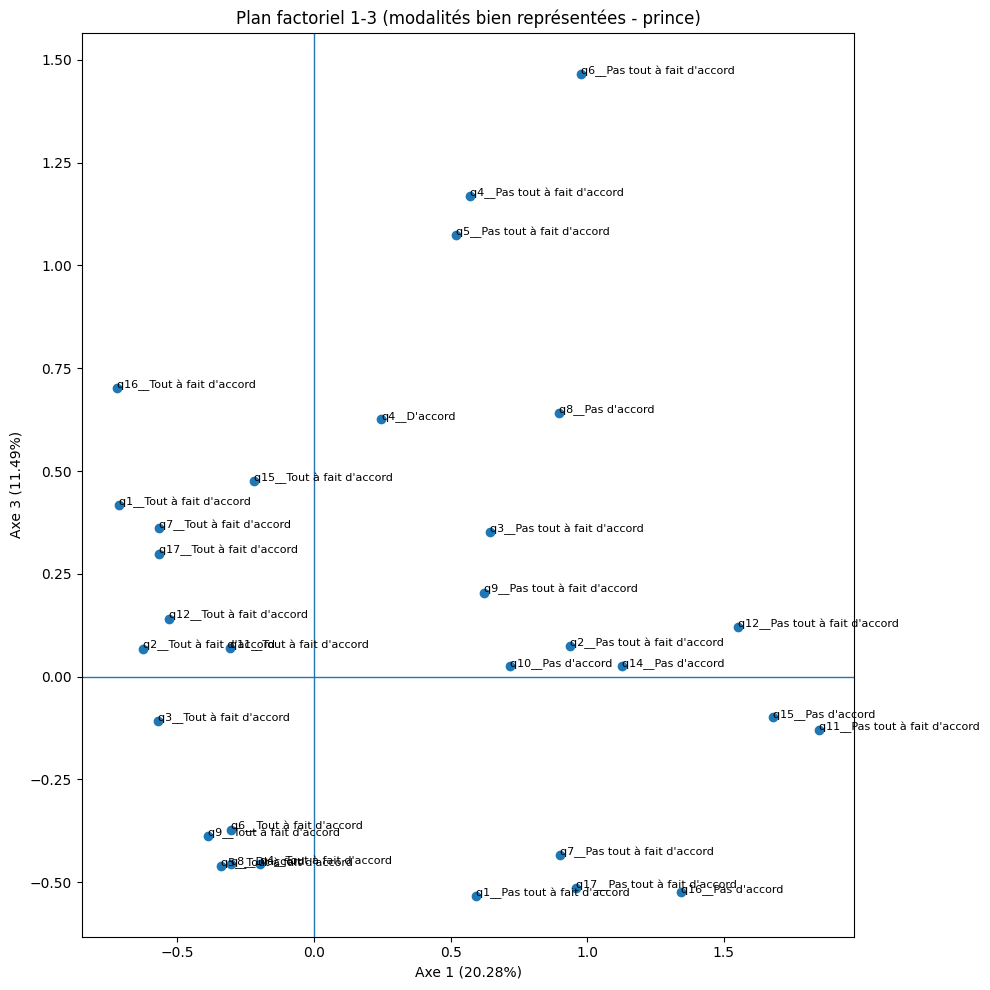

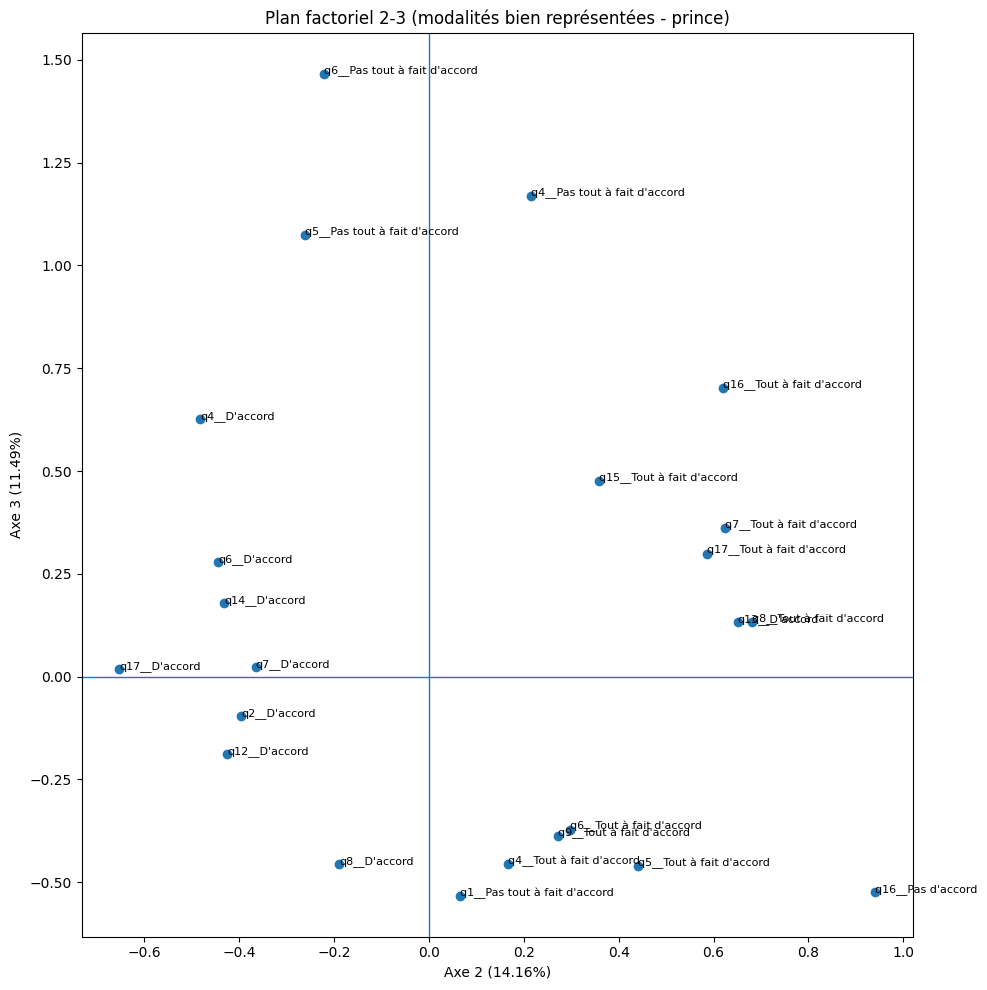

In [28]:
# ===== 1. Définition des variables =====
varAct = ['q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']
varSup = ['ecole', 'groupe', 'equipe2', 'genre', 'nbPersEq2','typeEq']

# =====================
# ====== CONFIG =======
# =====================
COS2_THRESHOLD = 0.1  # seuil pour dire "bien représenté"
NAN_POLICY = "drop"   # "drop" ou "fill"
FILL_VALUE = "NA"
N_PLANS = 3           # (1-2), (1-3), (2-3)

# =====================
# === VALIDATIONS  ====
# =====================
if 'df3' not in globals():
    raise RuntimeError("df3 n'est pas défini dans l'environnement courant.")

if not isinstance(varAct, (list, tuple)) or len(varAct) == 0:
    raise ValueError("varAct doit être une liste non vide des colonnes actives de df3.")

missing_act = [c for c in varAct if c not in df3.columns]
if missing_act:
    raise KeyError(f"Colonnes actives absentes de df3 : {missing_act}")

# =====================
# === PREPARATION  ====
# =====================
X_act = df3[varAct].copy()
if NAN_POLICY == "drop":
    X_act = X_act.dropna(how='any')
else:
    X_act = X_act.fillna(FILL_VALUE)

# Caster en catégories (conseillé pour MCA)
for c in X_act.columns:
    X_act[c] = X_act[c].astype('category')

# Choix automatique d'un nombre de composantes raisonnable
# max théorique ~ (#modalités totales - #variables) et < n-1
total_modalites = int(sum(X_act[c].cat.categories.size for c in X_act.columns))
max_comp_by_vars = max(2, total_modalites - len(varAct))
max_comp_by_rows = max(2, len(X_act) - 1)
n_components = max(2, min(10, max_comp_by_vars, max_comp_by_rows))

# =====================
# ====== MCA FIT ======
# =====================
mca_p = prince.MCA(
    n_components=n_components,
    n_iter=10,
    copy=True,
    check_input=True,
    engine="sklearn",
    random_state=42,
)

mca_p = mca_p.fit(X_act)

# =====================
# === INERTIES PLOT ===
# =====================
# explained_inertia_ : proportions (sommant à 1) -> on passe en %
try:
    # Versions récentes de prince
    inertia_pct = np.asarray(mca_p.explained_inertia_) * 100
except AttributeError:
    # Fallback : calculer à partir des valeurs propres
    ev = np.asarray(getattr(mca_p, "eigenvalues_", None), dtype=float)
    if ev.size == 0:
        raise AttributeError(
            "Votre version de 'prince' ne fournit ni 'explained_inertia_' ni 'eigenvalues_'. "
            "Mettez à jour 'prince' (pip install -U prince)."
        )
    inertia_pct = (ev / ev.sum()) * 100

axes_idx = np.arange(1, inertia_pct.size + 1)

plt.figure(figsize=(8, 5))
bars = plt.bar(axes_idx, inertia_pct)
plt.xlabel("Axes factoriels")
plt.ylabel("Inertie (%)")
plt.title("Inertie par axe factoriel (ACM - prince)")
for rect, val in zip(bars, inertia_pct):
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), f"{val:.2f}%",
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# ======================================
# === CATEGORIES BIEN REPRESENTEES  ====
# ======================================
# Coordonnées et cos² des modalités (colonnes)
col_coords_raw = mca_p.column_coordinates(X_act)
col_cos2_raw = mca_p.column_cosine_similarities(X_act)

# Renommer les colonnes en "Axe i" pour lisibilité
axis_labels = [f"Axe {i}" for i in range(1, inertia_pct.size + 1)]
col_coords = col_coords_raw.rename(columns={i-1: lab for i, lab in enumerate(axis_labels, start=1)})
col_cos2 = col_cos2_raw.rename(columns={i-1: lab for i, lab in enumerate(axis_labels, start=1)})

# Dictionnaire des catégories bien représentées par axe
cat_bien_repr = {ax: col_cos2.index[col_cos2[ax] >= COS2_THRESHOLD].tolist() for ax in axis_labels}

print(f"Catégories bien représentées (cos² ≥ {COS2_THRESHOLD:.2f}) :")
for ax in axis_labels:
    print(textwrap.fill(f"{ax} : {cat_bien_repr[ax]} \n\n",width=125))

# =====================
# === FACTOR MAPS  ====
# =====================

def plot_plan(ax1: int, ax2: int, cos2_threshold: float = COS2_THRESHOLD, folder='None'):
    if ax1 == ax2:
        return
    if ax1 < 1 or ax2 < 1 or ax1 > len(axis_labels) or ax2 > len(axis_labels):
        return

    label1, label2 = f"Axe {ax1}", f"Axe {ax2}"

    # Garder les modalités bien représentées sur AU MOINS un des deux axes
    mask = (col_cos2[label1] >= cos2_threshold) | (col_cos2[label2] >= cos2_threshold)
    coords = col_coords.loc[mask, [label1, label2]]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(coords[label1], coords[label2])
    for name, row in coords.iterrows():
        ax.text(row[label1], row[label2], name, fontsize=8)

    ax.axhline(0, lw=1)
    ax.axvline(0, lw=1)
    ax.set_xlabel(f"{label1} ({inertia_pct[ax1-1]:.2f}%)")
    ax.set_ylabel(f"{label2} ({inertia_pct[ax2-1]:.2f}%)")
    ax.set_title(f"Plan factoriel {ax1}-{ax2} (modalités bien représentées - prince)")
    plt.tight_layout()
    if folder !='None':
        os.makedirs(folder,exist_ok=True)
        plt.savefig(os.path.join(folder,f"ACM - {label1} vs {label2}.png"))
    plt.show()

max_axes = inertia_pct.size
plans = []
if max_axes >= 2:
    plans.append((1, 2))
if max_axes >= 3 and N_PLANS >= 2:
    plans.append((1, 3))
if max_axes >= 3 and N_PLANS >= 3:
    plans.append((2, 3))

for a1, a2 in plans:
    plot_plan(a1, a2,folder='Stats Multivariées')

ON PASSE  À L'ACM avec affichage des variables supplémentaires

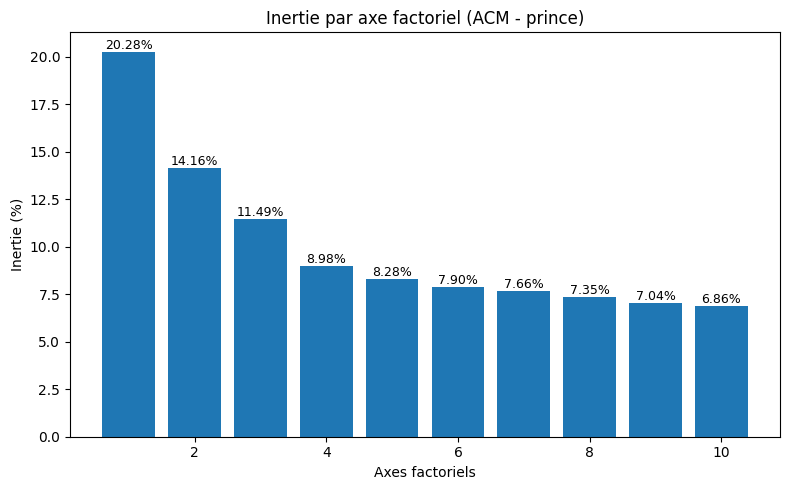

Catégories bien représentées (cos² ≥ 0.10) :
Axe 1 : ["q1__Pas tout à fait d'accord", "q1__Tout à fait d'accord", "q2__Pas tout à fait d'accord", "q2__Tout à fait
d'accord", "q3__Pas tout à fait d'accord", "q3__Tout à fait d'accord", "q6__Tout à fait d'accord", "q7__Pas tout à fait
d'accord", "q7__Tout à fait d'accord", "q8__Pas d'accord", "q9__Pas tout à fait d'accord", "q9__Tout à fait d'accord",
"q10__Pas d'accord", "q11__Pas tout à fait d'accord", "q11__Tout à fait d'accord", "q12__Pas tout à fait d'accord",
"q12__Tout à fait d'accord", "q14__Pas d'accord", "q15__Pas d'accord", "q16__Pas d'accord", "q16__Tout à fait d'accord",
"q17__Pas tout à fait d'accord", "q17__Tout à fait d'accord"]
Axe 2 : ["q2__D'accord", "q5__Tout à fait d'accord", "q6__D'accord", "q6__Tout à fait d'accord", "q7__D'accord", "q7__Tout à
fait d'accord", "q8__Tout à fait d'accord", "q12__D'accord", "q13__D'accord", "q14__D'accord", "q16__Pas d'accord",
"q17__D'accord", "q17__Tout à fait d'accord"]
Axe 3 : ["q1

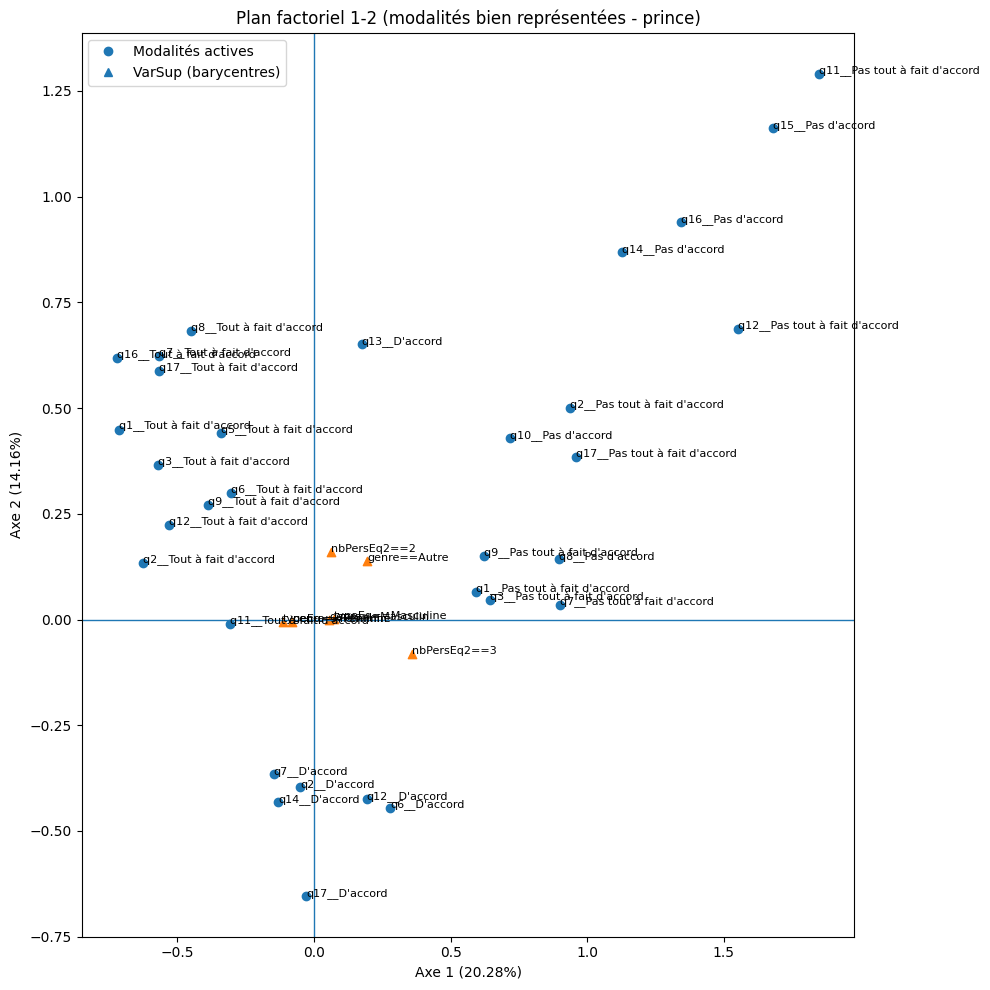

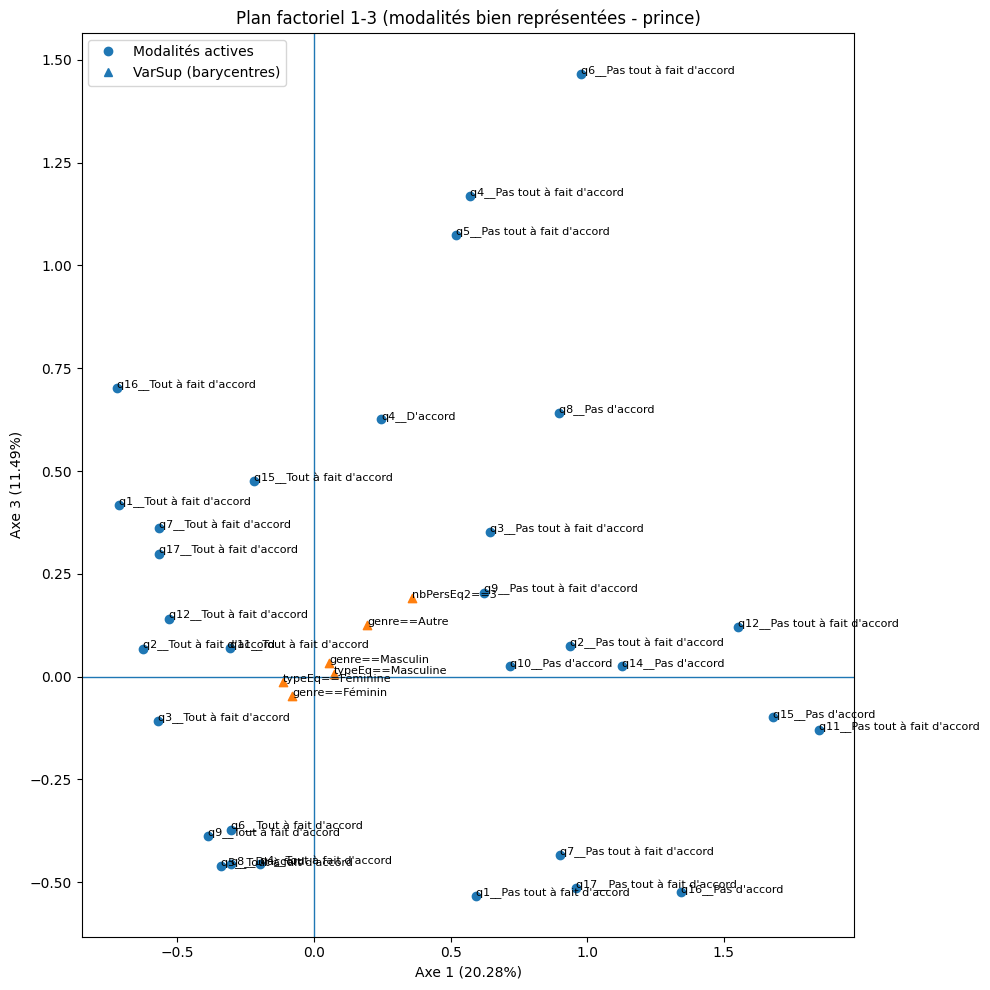

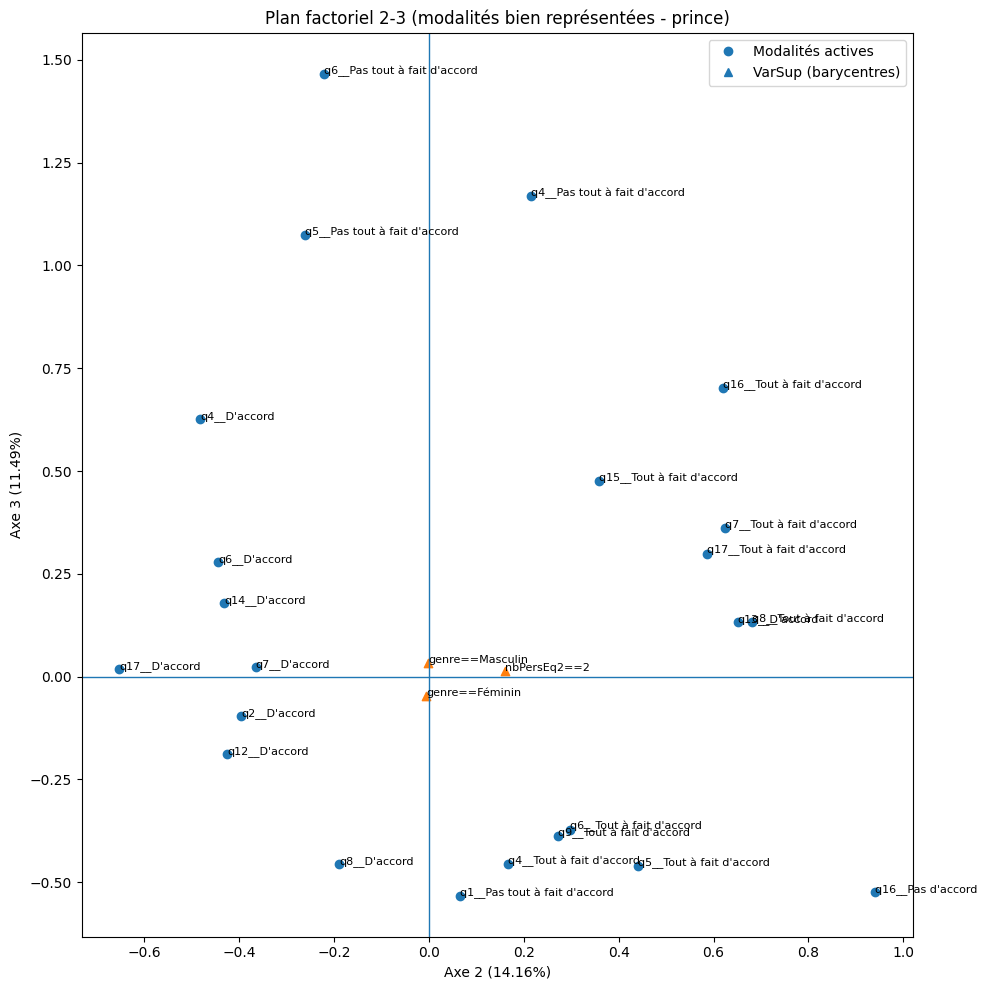

In [29]:
# ===== 1. Définition des variables =====
varAct = ['q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']
varSup = ['genre', 'nbPersEq2','typeEq']

# =====================
# ====== CONFIG =======
# =====================
COS2_THRESHOLD = 0.1  # seuil pour dire "bien représenté"
NAN_POLICY = "drop"   # "drop" ou "fill"
FILL_VALUE = "NA"
N_PLANS = 3           # (1-2), (1-3), (2-3)

# =====================
# === VALIDATIONS  ====
# =====================
if 'df3' not in globals():
    raise RuntimeError("df3 n'est pas défini dans l'environnement courant.")

if not isinstance(varAct, (list, tuple)) or len(varAct) == 0:
    raise ValueError("varAct doit être une liste non vide des colonnes actives de df3.")

missing_act = [c for c in varAct if c not in df3.columns]
if missing_act:
    raise KeyError(f"Colonnes actives absentes de df3 : {missing_act}")

# =====================
# === PREPARATION  ====
# =====================
X_act = df3[varAct].copy()
if NAN_POLICY == "drop":
    X_act = X_act.dropna(how='any')
else:
    X_act = X_act.fillna(FILL_VALUE)

# Caster en catégories (conseillé pour MCA)
for c in X_act.columns:
    X_act[c] = X_act[c].astype('category')

# Choix automatique d'un nombre de composantes raisonnable
# max théorique ~ (#modalités totales - #variables) et < n-1
total_modalites = int(sum(X_act[c].cat.categories.size for c in X_act.columns))
max_comp_by_vars = max(2, total_modalites - len(varAct))
max_comp_by_rows = max(2, len(X_act) - 1)
n_components = max(2, min(10, max_comp_by_vars, max_comp_by_rows))

# =====================
# ====== MCA FIT ======
# =====================
mca_p = prince.MCA(
    n_components=n_components,
    n_iter=10,
    copy=True,
    check_input=True,
    engine="sklearn",
    random_state=42,
)

mca_p = mca_p.fit(X_act)

# =====================
# === INERTIES PLOT ===
# =====================
# explained_inertia_ : proportions (sommant à 1) -> on passe en %
try:
    # Versions récentes de prince
    inertia_pct = np.asarray(mca_p.explained_inertia_) * 100
except AttributeError:
    # Fallback : calculer à partir des valeurs propres
    ev = np.asarray(getattr(mca_p, "eigenvalues_", None), dtype=float)
    if ev.size == 0:
        raise AttributeError(
            "Votre version de 'prince' ne fournit ni 'explained_inertia_' ni 'eigenvalues_'. "
            "Mettez à jour 'prince' (pip install -U prince)."
        )
    inertia_pct = (ev / ev.sum()) * 100

axes_idx = np.arange(1, inertia_pct.size + 1)

plt.figure(figsize=(8, 5))
bars = plt.bar(axes_idx, inertia_pct)
plt.xlabel("Axes factoriels")
plt.ylabel("Inertie (%)")
plt.title("Inertie par axe factoriel (ACM - prince)")
for rect, val in zip(bars, inertia_pct):
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), f"{val:.2f}%",
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# ======================================
# === CATEGORIES BIEN REPRESENTEES  ====
# ======================================
# Coordonnées et cos² des modalités (colonnes)
col_coords_raw = mca_p.column_coordinates(X_act)
col_cos2_raw = mca_p.column_cosine_similarities(X_act)

# Renommer les colonnes en "Axe i" pour lisibilité
axis_labels = [f"Axe {i}" for i in range(1, inertia_pct.size + 1)]
col_coords = col_coords_raw.rename(columns={i-1: lab for i, lab in enumerate(axis_labels, start=1)})
col_cos2 = col_cos2_raw.rename(columns={i-1: lab for i, lab in enumerate(axis_labels, start=1)})

# Dictionnaire des catégories bien représentées par axe
cat_bien_repr = {ax: col_cos2.index[col_cos2[ax] >= COS2_THRESHOLD].tolist() for ax in axis_labels}

print(f"Catégories bien représentées (cos² ≥ {COS2_THRESHOLD:.2f}) :")
for ax in axis_labels:
    print(textwrap.fill(f"{ax} : {cat_bien_repr[ax]} \n\n",width=125))

# =====================
# === VARSUP (BARYCENTRES) ===
# =====================
sup_coords = pd.DataFrame()
sup_cos2 = pd.DataFrame()
if isinstance(varSup, (list, tuple)) and len(varSup) > 0:
    df_sup = df3.loc[X_act.index, varSup].copy()
    if NAN_POLICY == "drop":
        df_sup = df_sup.dropna(how='any')
        X_act_aligned = X_act.loc[df_sup.index]
        row_coords_raw = mca_p.row_coordinates(X_act_aligned)
    else:
        df_sup = df_sup.fillna(FILL_VALUE)
        row_coords_raw = mca_p.row_coordinates(X_act)
    # Renommer colonnes en "Axe i"
    row_coords = row_coords_raw.rename(columns={i: axis_labels[i] for i in range(min(row_coords_raw.shape[1], len(axis_labels)))})
    recs = []
    for col in df_sup.columns:
        s = df_sup[col].astype('category')
        for level in s.cat.categories:
            mask = (s == level)
            if mask.any():
                mu = row_coords.loc[mask, axis_labels].mean()
                recs.append(pd.Series(mu, name=f"{col}=={level}"))
    if recs:
        sup_coords = pd.DataFrame(recs)
        # cos² pour les barycentres (norme au carré normalisée)
        sq = sup_coords.pow(2)
        denom = sq.sum(axis=1).replace(0, np.nan)
        sup_cos2 = sq.div(denom, axis=0).fillna(0.0)

# =====================
# === FACTOR MAPS  ====
# =====================

def plot_plan2(ax1: int, ax2: int, cos2_threshold: float = COS2_THRESHOLD, folder='None'):
    if ax1 == ax2:
        return
    if ax1 < 1 or ax2 < 1 or ax1 > len(axis_labels) or ax2 > len(axis_labels):
        return

    label1, label2 = f"Axe {ax1}", f"Axe {ax2}"

    # Garder les modalités bien représentées sur AU MOINS un des deux axes
    mask = (col_cos2[label1] >= cos2_threshold) | (col_cos2[label2] >= cos2_threshold)
    coords = col_coords.loc[mask, [label1, label2]]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(coords[label1], coords[label2])
    for name, row in coords.iterrows():
        ax.text(row[label1], row[label2], name, fontsize=8)

    # VarSup (barycentres)
    if not sup_coords.empty:
        sup_mask = (sup_cos2[label1] >= cos2_threshold) | (sup_cos2[label2] >= cos2_threshold)
        coords_sup = sup_coords.loc[sup_mask, [label1, label2]]
        ax.scatter(coords_sup[label1], coords_sup[label2], marker='^')
        for name, row in coords_sup.iterrows():
            ax.text(row[label1], row[label2], name, fontsize=8)


    ax.axhline(0, lw=1)
    ax.axvline(0, lw=1)
    ax.set_xlabel(f"{label1} ({inertia_pct[ax1-1]:.2f}%)")
    ax.set_ylabel(f"{label2} ({inertia_pct[ax2-1]:.2f}%)")
    ax.set_title(f"Plan factoriel {ax1}-{ax2} (modalités bien représentées - prince)")

    try:
        
        handles = [Line2D([0],[0], marker='o', linestyle='None', label='Modalités actives')]
        if not sup_coords.empty:
            handles.append(Line2D([0],[0], marker='^', linestyle='None', label='VarSup (barycentres)'))
        ax.legend(handles=handles, loc='best')
    except Exception:
        pass

    plt.tight_layout()

    # on enregistre le graphique si indiqué
    if folder !='None':
        os.makedirs(folder,exist_ok=True)
        plt.savefig(os.path.join(folder,f"ACM - {label1} vs {label2} - bis.png"))
    plt.show()

max_axes = inertia_pct.size
plans = []
if max_axes >= 2:
    plans.append((1, 2))
if max_axes >= 3 and N_PLANS >= 2:
    plans.append((1, 3))
if max_axes >= 3 and N_PLANS >= 3:
    plans.append((2, 3))

for a1, a2 in plans:
    plot_plan2(a1, a2,folder='Stats Multivariées')

PASSONS À LA CLASSIFICATION ASCENDANTE HIERARCHIQUE

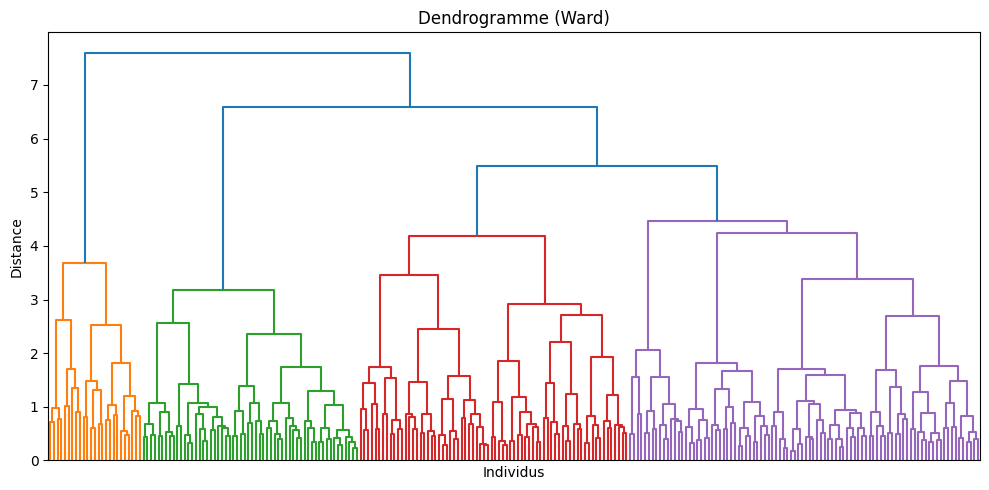

In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from math import sqrt
from __future__ import annotations

"""
CAH (Classification Ascendante Hiérarchique) après ACM (avec prince)
-------------------------------------------------------------------
Objectif :
  • Utiliser les coordonnées factorielles des individus (issues de l'ACM) pour
    réaliser une segmentation non supervisée par CAH (Ward).
  • Choisir un nombre de classes (silhouette) puis affecter chaque individu.
  • Caractériser statistiquement les classes (surreprésentation des modalités).
  • Visualiser : dendrogramme et plan factoriel 1–2 coloré par cluster.

Pré-requis :
  • Avoir exécuté le script "Acm Prince Var Sup" (même session) pour disposer de :
      - mca : objet prince.MCA déjà ajusté
      - X_act : DataFrame des variables actives (mêmes index que df3)
      - inertia_pct : % d'inertie par axe (array-like)
      - axis_labels : noms des axes ["Axe 1", ...]
  • scikit-learn et scipy installés
      pip install scikit-learn scipy
"""

# =====================
# ====== PARAMS =======
# =====================
# Seuil cumulé d'inertie pour retenir les dimensions (ex. 80%)
INERTIA_THRESHOLD = 80.0
MIN_DIMS = 2
MAX_DIMS = 10

# Plage k pour recherche silhouette
K_MIN, K_MAX = 2, 10

# Fixer manuellement k si souhaité (None => auto par silhouette)
# ex. 4

# =====================
# === EXPORT FIGS   ===
# =====================
EXPORT_FIGURES = True          # mettre False pour désactiver
FIG_DIR = "figures_cah"        # dossier de sortie
FIG_PREFIX = "CAH"             # préfixe des fichiers
FIG_DPI = 150                   # résolution
FIG_FORMATS = ["png", "pdf"]   # formats sauvegardés

def save_fig(fig, name: str):
    """Enregistre la figure sous FIG_DIR/FIG_PREFIX_name.(ext), robuste."""
    if not EXPORT_FIGURES:
        return
    try:
        os.makedirs(FIG_DIR, exist_ok=True)
    except Exception as e:
        print(f"[WARN] Impossible de créer le dossier '{FIG_DIR}': {e}")
        return
    for ext in FIG_FORMATS:
        out = os.path.join(FIG_DIR, f"{FIG_PREFIX}_{name}.{ext}")
        try:
            fig.savefig(out, dpi=FIG_DPI, bbox_inches="tight")
        except Exception as e:
            print(f"[WARN] Sauvegarde échouée pour {out}: {e}")


# =====================
# === SAFETY CHECKS ===
# =====================
row_coords_raw = mca_p.row_coordinates(X_act)
row_coords = row_coords_raw.rename(columns={i: axis_labels[i] for i in range(min(len(axis_labels), row_coords_raw.shape[1]))})

#inertia_pct = np.asarray(mca_p.explained_inertia_) * 100.0

# Inertie par axe (pour étiquette des axes)
ev = np.asarray(getattr(mca_p, "eigenvalues_", None), dtype=float)
if ev.size == 0:
    raise AttributeError(
            "Votre version de 'prince' ne fournit ni 'explained_inertia_' ni 'eigenvalues_'. "
            "Mettez à jour 'prince' (pip install -U prince)."
        )
inertia_pct = (ev / ev.sum()) * 100

# ================================
# === CHOIX DU NOMBRE DE DIM. ===
# ================================
# Retenir les premières dimensions couvrant INERTIA_THRESHOLD % (borné)
if np.isnan(inertia_pct).all():
    p = min(MAX_DIMS, max(MIN_DIMS, row_coords.shape[1]))
else:
    cum = np.cumsum(inertia_pct)
    p = int(np.searchsorted(cum, INERTIA_THRESHOLD) + 1)
    p = max(MIN_DIMS, min(MAX_DIMS, p, row_coords.shape[1]))

row_space = row_coords.iloc[:, :p]

# =====================
# === DENDROGRAMME  ===
# =====================
Z = linkage(row_space, method='ward', metric='euclidean')
plt.figure(figsize=(10, 5))
dendrogram(Z, no_labels=True, count_sort=True)
plt.title('Dendrogramme (Ward)')
plt.xlabel('Individus')
plt.ylabel('Distance')
plt.tight_layout()
save_fig(fig, "dendrogramme")
plt.show()


def CAH_nb_cluster(K_OVERRIDE = 'None' ):

    """ 
    Effectue la CAH pour le nombre de classes K_OVERRIDE. Par défaut, le nombre de classes est choisi automatiquement
    
    Args: 
        K_OVERRIDE : Nombre de classes de la CAH

    """

    
    # ======================================
    # === CHOIX k PAR COEFFICIENT SIL.  ===
    # ======================================
    ks, sils = [], []
    upper = min(K_MAX, len(row_space) - 1)
    for k in range(max(K_MIN, 2), max(K_MIN, upper) + 1):
        labels_k = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(row_space)
        try:
            s = silhouette_score(row_space, labels_k)
            ks.append(k); sils.append(s)
        except Exception:
            # silhouette peut échouer si un cluster a 1 seul point
            continue

    if ks:
        best_k = ks[int(np.argmax(sils))]
    else:
        # fallback : couper l'arbre en 2 classes
        best_k = 2

    k = int(K_OVERRIDE) if K_OVERRIDE is not None else best_k
    print(f"k retenu = {k} (silhouette max: {best_k})")

    # =====================
    # === AFFECTATION   ===
    # =====================
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(row_space)
    clusters = pd.Series(labels + 1, index=row_space.index, name='cluster')

    # Ajouter au df de travail
    df_cah = df3.loc[row_space.index].copy()
    df_cah['cluster'] = clusters

    # ===============================
    # === CARACTÉRISATION CLASSES ===
    # ===============================
    # v-test (approx. z) pour surreprésentation des modalités par cluster

    def characterize_clusters(df: pd.DataFrame, cluster_col: str, vars_categ: list[str], top_n: int = 10):
        rows = []
        N = len(df)
        for var in vars_categ:
            s_all = df[var].astype('category')
            cats = list(s_all.cat.categories)
            p_all = s_all.value_counts(normalize=True).reindex(cats).fillna(0.0)
            for g, sub in df.groupby(cluster_col):
                n_g = len(sub)
                s_g = sub[var].astype('category')
                p_g = s_g.value_counts(normalize=True).reindex(cats).fillna(0.0)
                for lvl in cats:
                    p0 = float(p_all.loc[lvl])
                    pg = float(p_g.loc[lvl])
                    # v-test ~ (pg - p0)/sqrt(p0(1-p0)/n_g)
                    denom = sqrt(max(p0 * (1.0 - p0) / max(n_g, 1), 1e-12))
                    v = (pg - p0) / denom if denom > 0 else 0.0
                    rows.append(dict(
                        cluster=g,
                        variable=var,
                        modality=lvl,
                        n_cluster=n_g,
                        pct_cluster=100.0 * pg,
                        pct_overall=100.0 * p0,
                        diff_pct=100.0 * (pg - p0),
                        v_test=v
                    ))
        res = pd.DataFrame(rows).sort_values(['cluster', 'v_test'], ascending=[True, False])
        tops = res[res['v_test'] > 0].groupby('cluster').head(top_n)
        return res, tops

    vars_to_profile = list(varAct) + (list(varSup) if 'VarSup' in globals() and isinstance(varSup, (list, tuple)) else [])
    res_all, tops = characterize_clusters(df_cah, 'cluster', vars_to_profile, top_n=12)

    print("\nTop modalités surreprésentées par cluster (v-test>0):")
    for g, sub in tops.groupby('cluster'):
        print(f"\nCluster {g}:")
        print(sub[['variable','modality','pct_cluster','pct_overall','diff_pct','v_test']].round(2).to_string(index=False))

    # --- Caractérisation complémentaire (CAH) : Chi2 & V de Cramér ---
    try:
        #if 'chi2_cramers_by_variable' not in globals():
        #from scipy.stats import chi2_contingency
        def chi2_cramers_by_variable(df: pd.DataFrame, cluster_col: str, vars_categ: list[str]) -> tuple[pd.DataFrame, dict[str, pd.DataFrame]]:
            out_rows = []
            resid_tables: dict[str, pd.DataFrame] = {}
            for var in vars_categ:
                tab = pd.crosstab(df[cluster_col], df[var])
                chi2, p, dof, expected = chi2_contingency(tab, correction=False)
                n = tab.values.sum()
                phi2 = chi2 / max(n, 1)
                r, c = tab.shape
                V = sqrt(phi2 / max(min(r - 1, c - 1), 1))
                out_rows.append(dict(variable=var, chi2=chi2, dof=int(dof), p_value=p, cramers_v=V))
                resid = (tab - expected) / np.sqrt(expected)
                resid_tables[var] = pd.DataFrame(resid, index=tab.index, columns=tab.columns)
            summary = pd.DataFrame(out_rows).sort_values('cramers_v', ascending=False)
            return summary, resid_tables
        
        chi2_cah, resid_cah = chi2_cramers_by_variable(df_cah, 'cluster', vars_to_profile)
        print("Chi2 & V de Cramér (CAH):")
        print(chi2_cah.round(4).to_string(index=False))
    except Exception as e:
        print(f"[WARN] Chi2/Cramér (CAH) non calculé: {e}")

    # --- Pie chart des poids relatifs des classes (CAH) ---
    try:
        counts = df_cah['cluster'].value_counts().sort_index()
        labels = [f"Cluster {i}" for i in counts.index]
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pie(counts.values, labels=labels, autopct="%.1f%%", startangle=90)
        ax.axis('equal')
        ax.set_title("Répartition des classes (CAH)")
        save_fig(fig, "repartition_classes_CAH")
        plt.show()
    except Exception as e:
        print(f"[WARN] Pie chart non généré: {e}")

    # ==================================
    # === PLAN 1–2 COLORÉ PAR CLUSTER ===
    # ==================================
    def plot_cluster_plan(ax1: int, ax2: int):
        """Affiche les clusters sur le plan (ax1, ax2)."""
        if ax1 == ax2:
            return
        if ax1 < 1 or ax2 < 1:
            return
        if ax1 > row_coords.shape[1] or ax2 > row_coords.shape[1]:
            return

        fig, ax = plt.subplots(figsize=(7, 7))
        for g in sorted(df_cah['cluster'].unique()):
            mask = df_cah['cluster'] == g
            ax.scatter(
                row_coords.iloc[mask.values, ax1-1],
                row_coords.iloc[mask.values, ax2-1],
                label=f"Cluster {g}",
                alpha=0.85
            )

        ax.axhline(0, lw=1); ax.axvline(0, lw=1)
        # Étiquettes d'axes avec % d'inertie si dispo
        try:
            ax.set_xlabel(f"Axe {ax1} ({inertia_pct[ax1-1]:.2f}%)")
            ax.set_ylabel(f"Axe {ax2} ({inertia_pct[ax2-1]:.2f}%)")
        except Exception:
            ax.set_xlabel(f"Axe {ax1}")
            ax.set_ylabel(f"Axe {ax2}")

        ax.set_title(f"Plan factoriel {ax1}–{ax2} coloré par cluster (CAH)")
        ax.legend(loc='best')
        save_fig(fig, f"plan_{ax1}-{ax2} - CAH à {K_OVERRIDE} classes")
        plt.tight_layout(); plt.show()

    # Afficher les 3 premiers plans si disponibles
    max_axes = row_coords.shape[1]
    if max_axes >= 2:
        plot_cluster_plan(1, 2)
    if max_axes >= 3:
        plot_cluster_plan(1, 3)
        plot_cluster_plan(2, 3)
    return df_cah

# =====================
# === EXPORT UTILES ===
# =====================
# df_cah : df3 + cluster
# res_all : table longue des v-tests
# tops    : top modalités surreprésentées par cluster
# Exemple d'export CSV si besoin :
# df_cah.to_csv("clusters_cah.csv", index=True)
# res_all.to_csv("caracterisation_modalites_vtest.csv", index=False)
# tops.to_csv("caracterisation_top_modalites.csv", index=False)



k retenu = 4 (silhouette max: 2)

Top modalités surreprésentées par cluster (v-test>0):

Cluster 1:
variable                 modality  pct_cluster  pct_overall  diff_pct  v_test
      q1 Pas tout à fait d'accord        47.87        31.73     16.15    3.36
     q12                 D'accord        57.45        42.17     15.28    3.00
     q17                 D'accord        58.51        43.78     14.74    2.88
     q15           Je ne sais pas        30.85        19.68     11.17    2.72
      q4     Tout à fait d'accord        76.60        63.05     13.54    2.72
     q10           Je ne sais pas        50.00        36.55     13.45    2.71
      q8                 D'accord        52.13        39.36     12.77    2.53
      q7 Pas tout à fait d'accord        36.17        24.90     11.27    2.53
     q16           Je ne sais pas        39.36        28.11     11.25    2.43
      q2                 D'accord        54.26        42.17     12.09    2.37
     q13             Pas d'accord        4

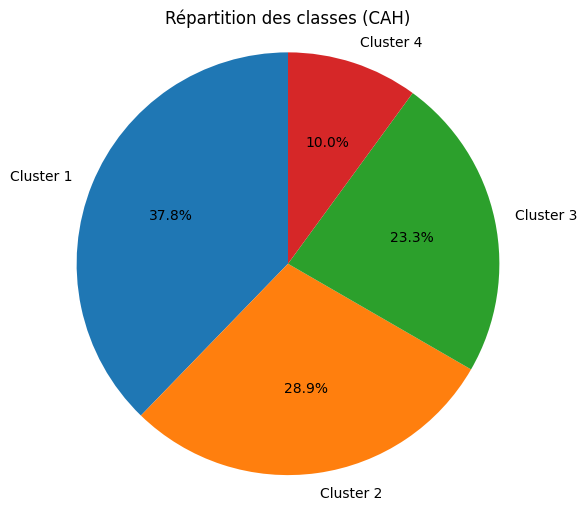

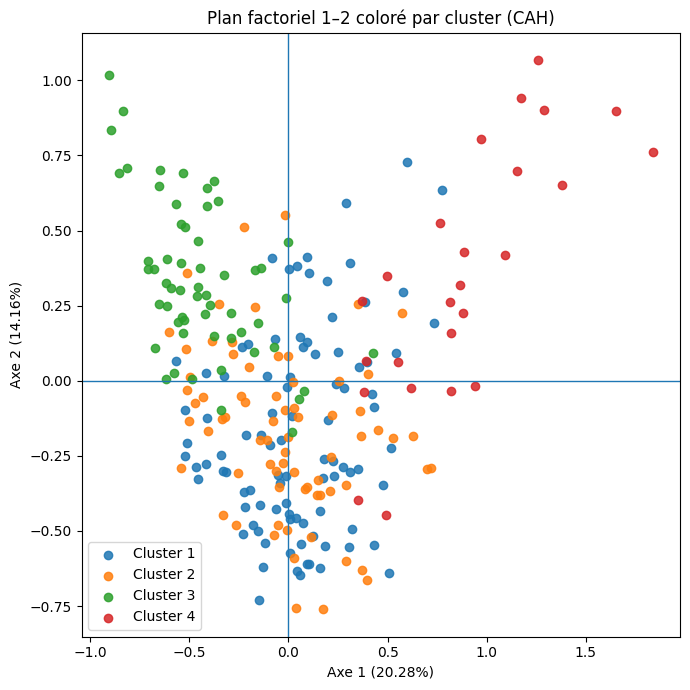

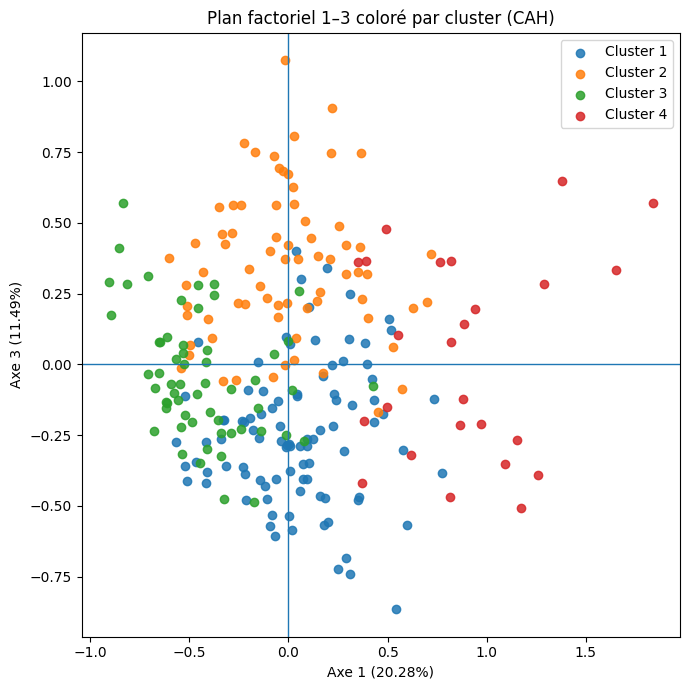

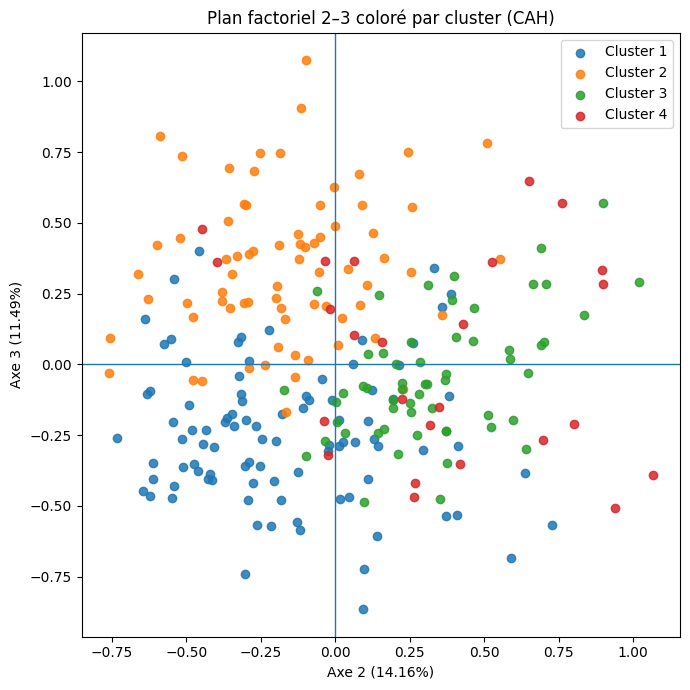

In [31]:
%matplotlib inline
#CAH_nb_cluster(K_OVERRIDE = 2 )
#CAH_nb_cluster(K_OVERRIDE = 3 )
df_clust = CAH_nb_cluster(K_OVERRIDE = 4 )

#CAH_nb_cluster(K_OVERRIDE = 5 )
#CAH_nb_cluster(K_OVERRIDE = 6 )


Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


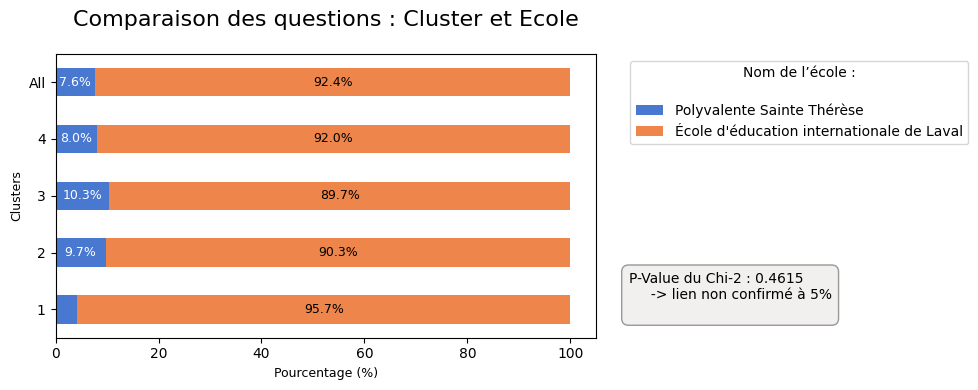


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


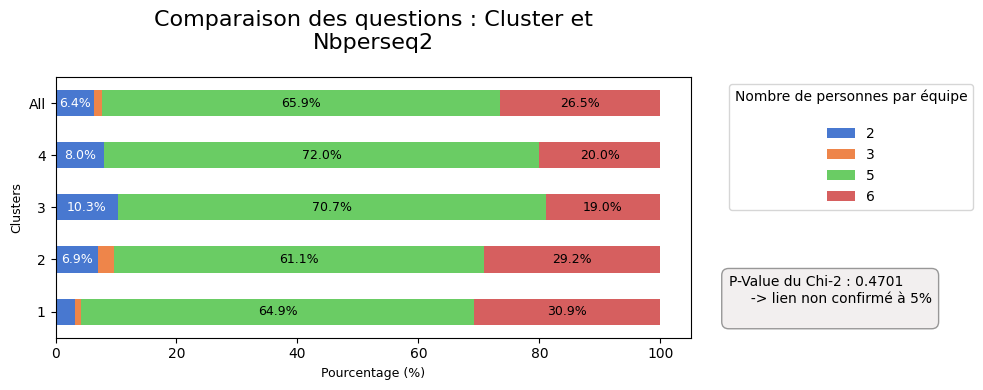


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


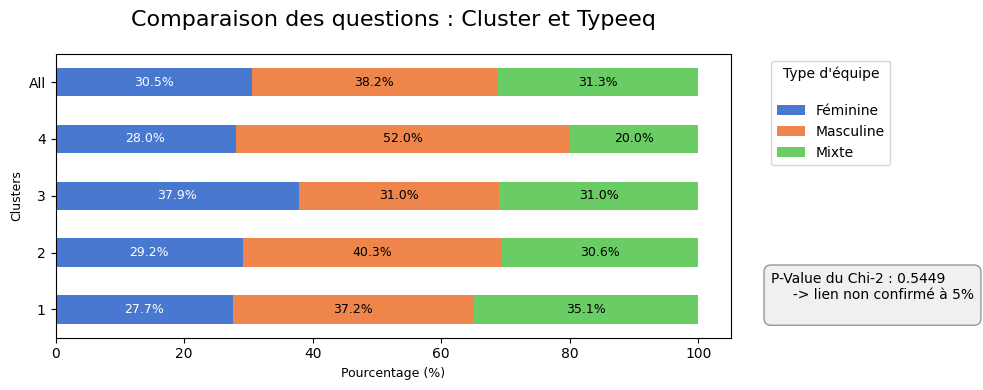


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


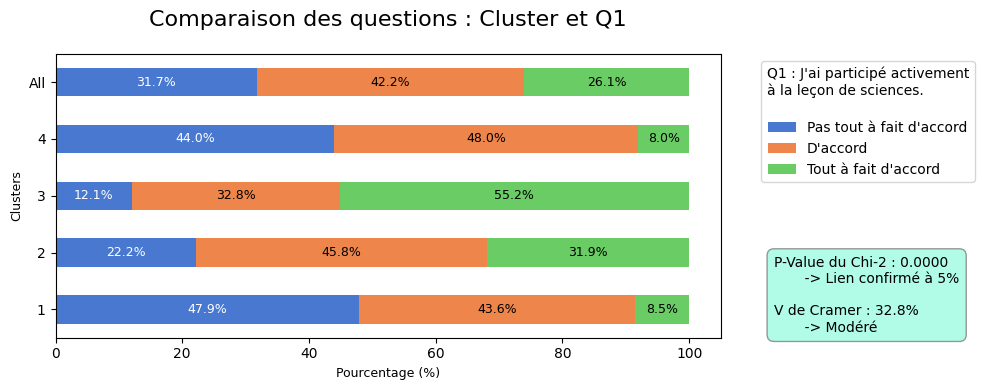


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


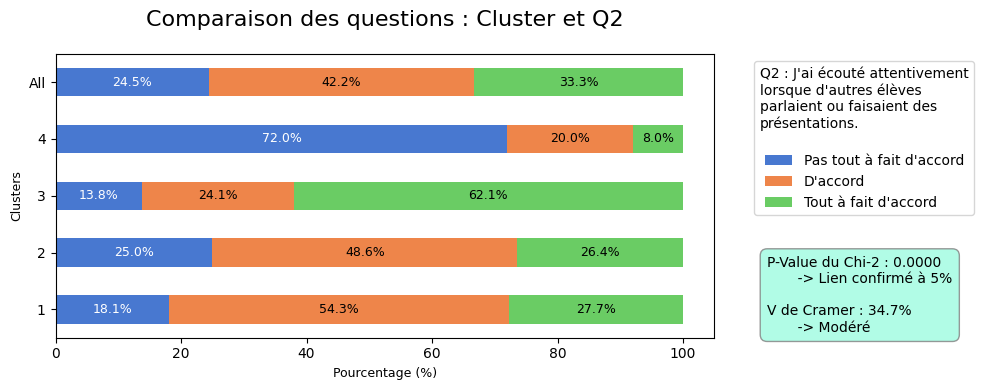


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


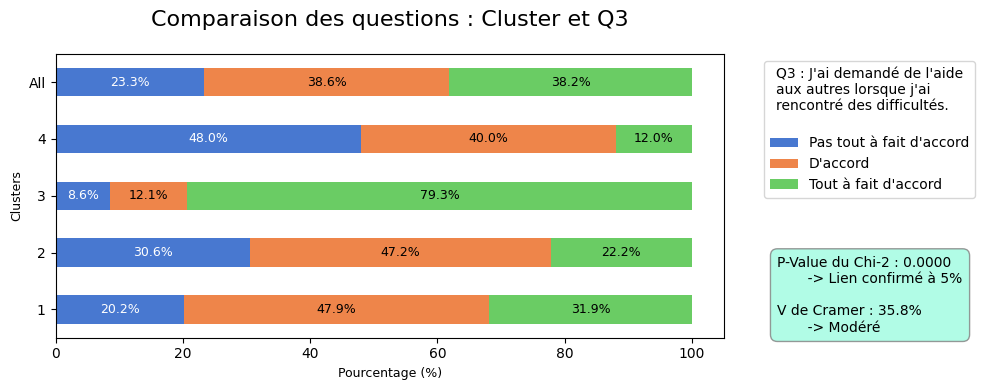


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


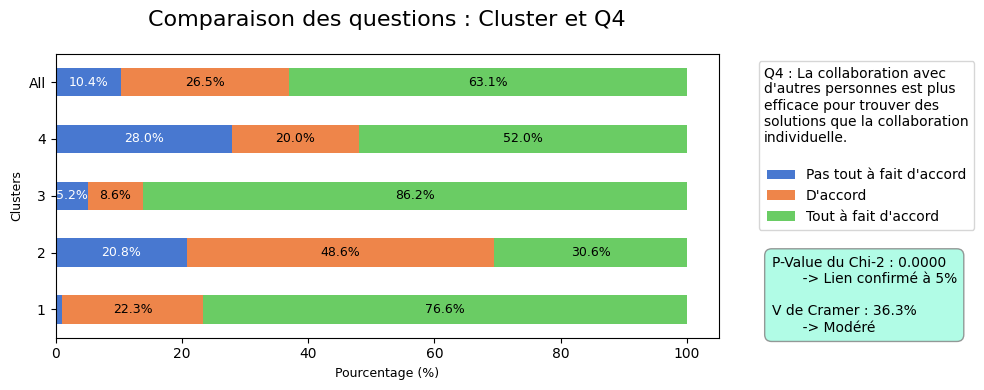


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


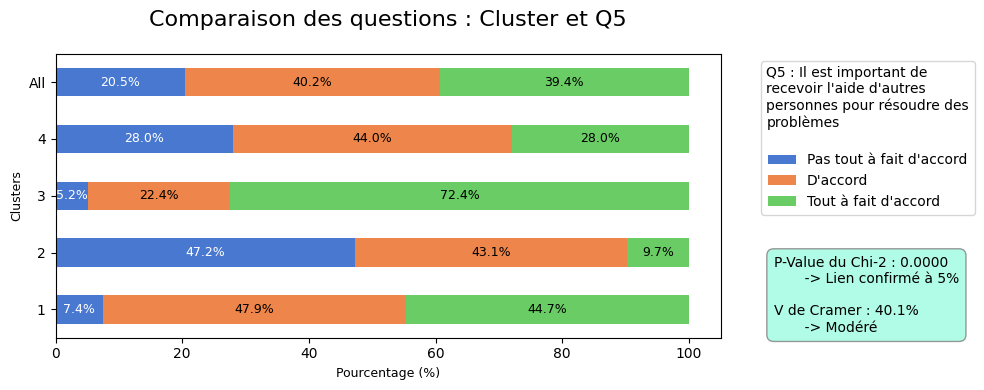


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


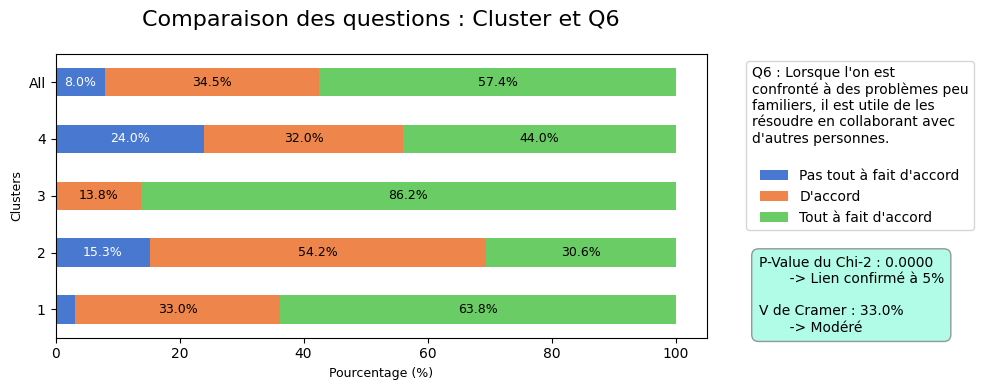


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


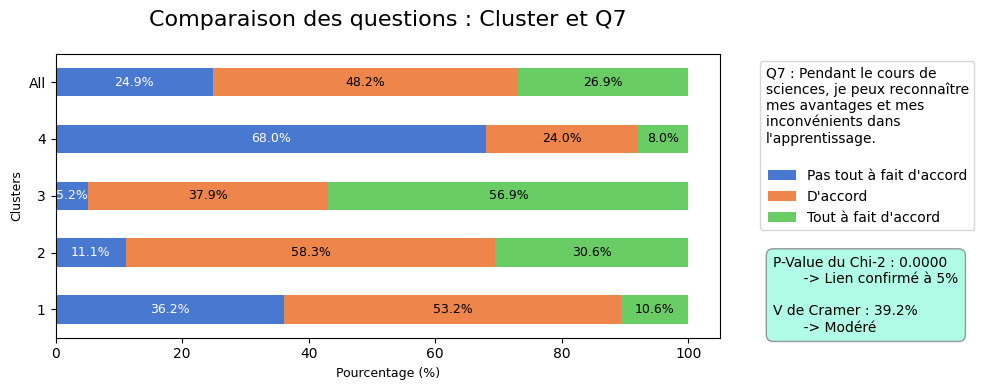


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


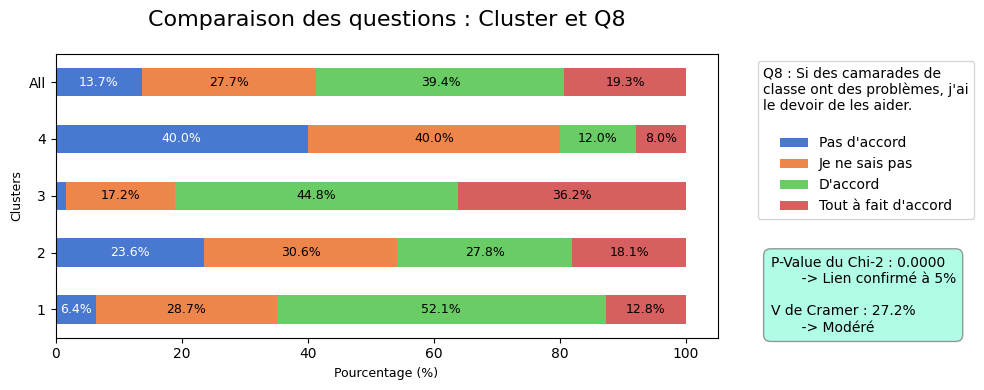


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


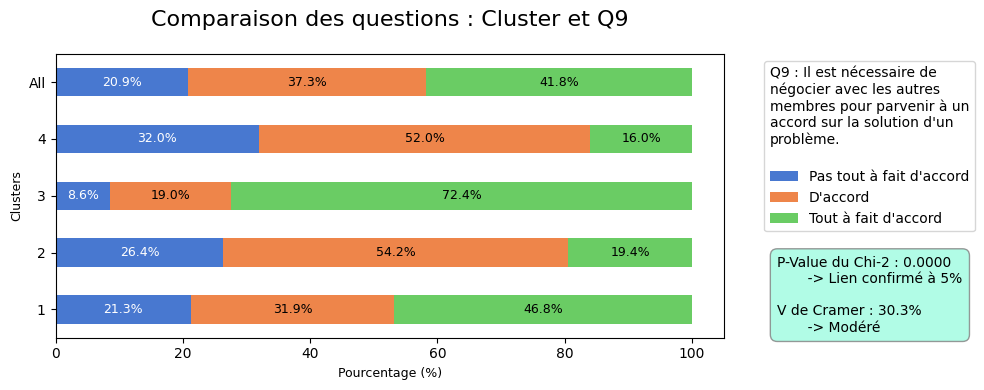


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


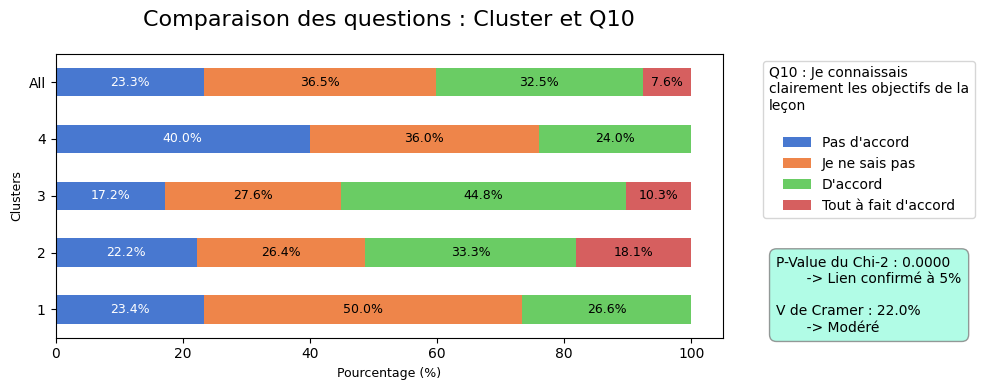


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


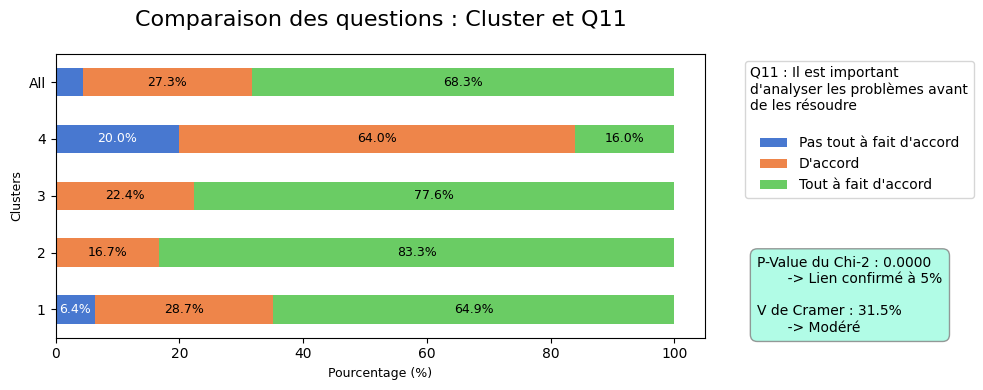


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


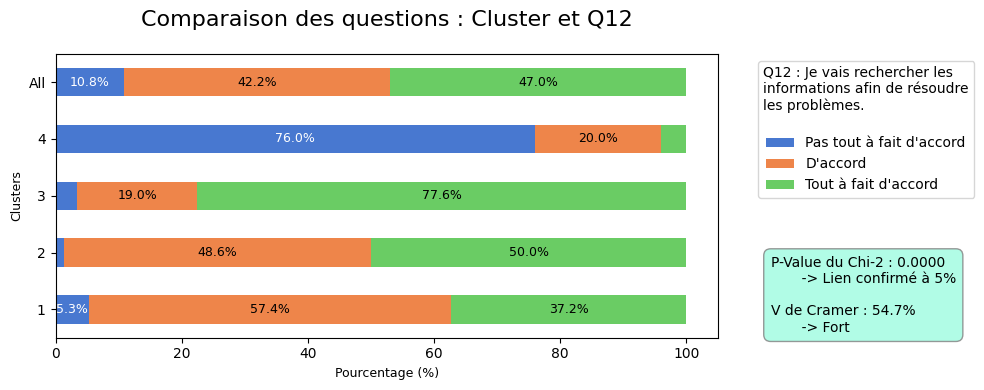


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


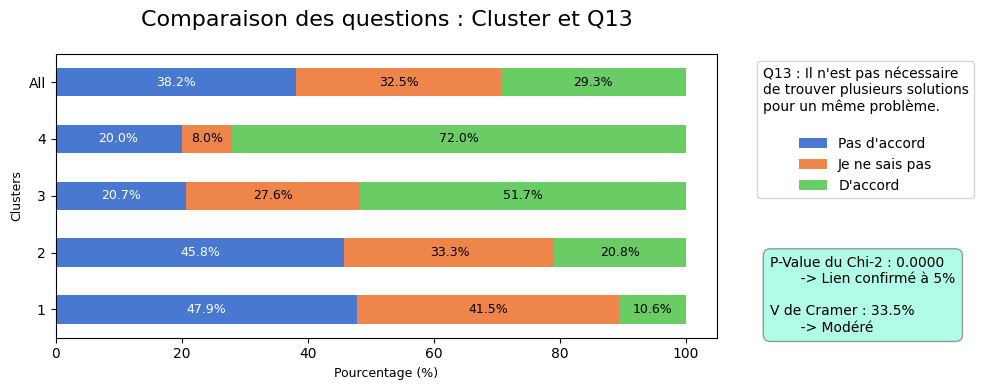


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


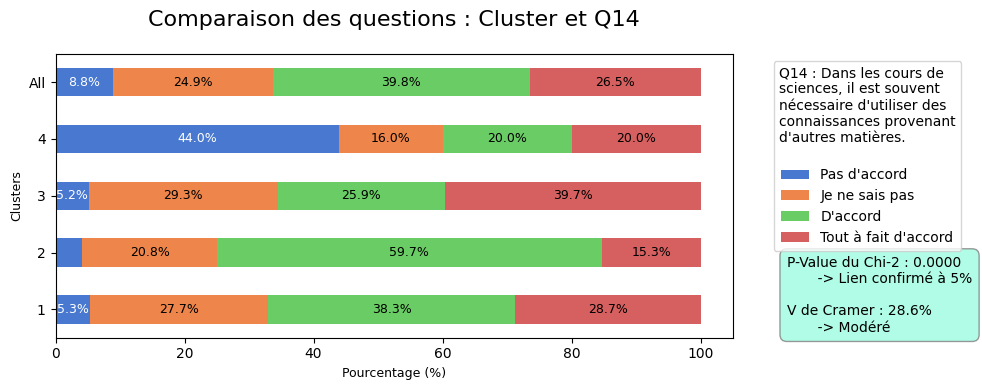


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


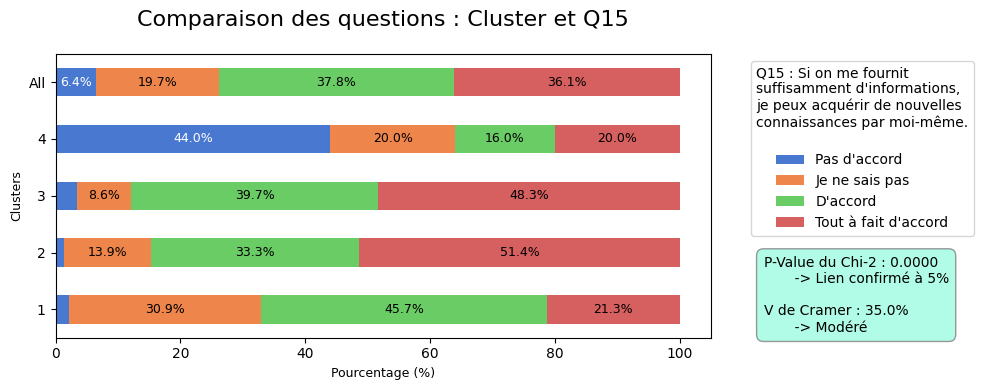


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


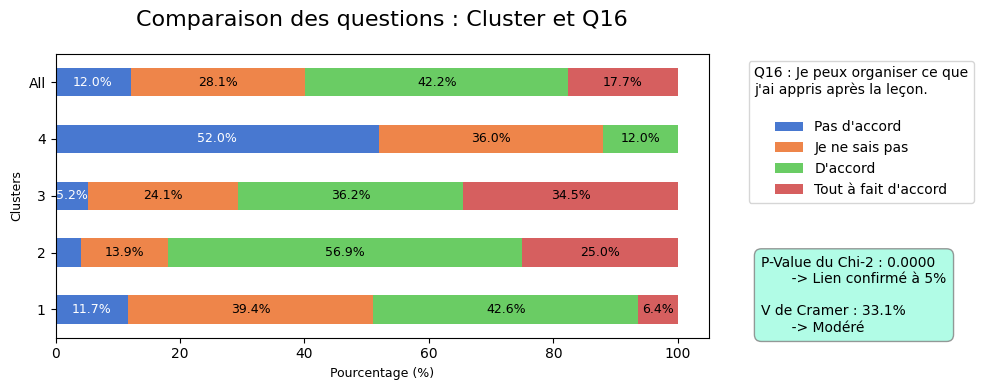


Le diagramme en barres sectionnées a été généré avec succès.

Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


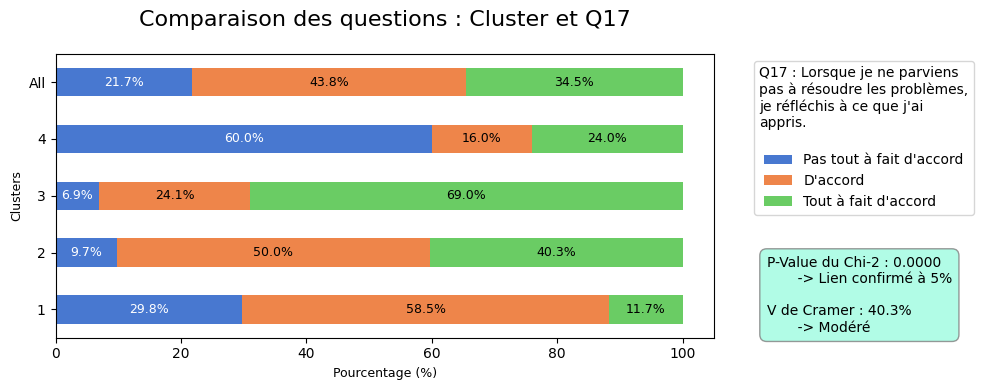


Le diagramme en barres sectionnées a été généré avec succès.


In [32]:
#----- Production des barh pour la description des clusters

# Ajout de cluster dans la table de dimension des noms de colonnes
refColonnes['cluster'] = 'Clusters'; refColonnes['typeEq'] = "Type d'équipe"; 
refColonnes['nbPersEq2']= "Nombre de personnes par équipe"
var = ['ecole','nbPersEq2','typeEq','q1','q2','q3','q4','q5','q6','q7','q8','q9','q10',
       'q11','q12','q13','q14','q15','q16','q17']

# Transformation de la variable 'cluster' en variable catéorielle

echelle_clust = pd.CategoricalDtype(categories=[1,2,3,4], ordered=False)
df_clust['cluster'] = df_clust['cluster'].astype(echelle_clust)

for col in var:
    barh(data=df_clust, col1 = 'cluster', col2 = col ,palette='muted', refCol=refColonnes, 
            folder='figures_cah', file_name='None', show_plot=True )


Calcul des liens entre variables...

 Matrice du V de Cramer calculées avec succès ---

--- Matrice des p-valeurs du Test du Chi-2 calculée avec succès ---


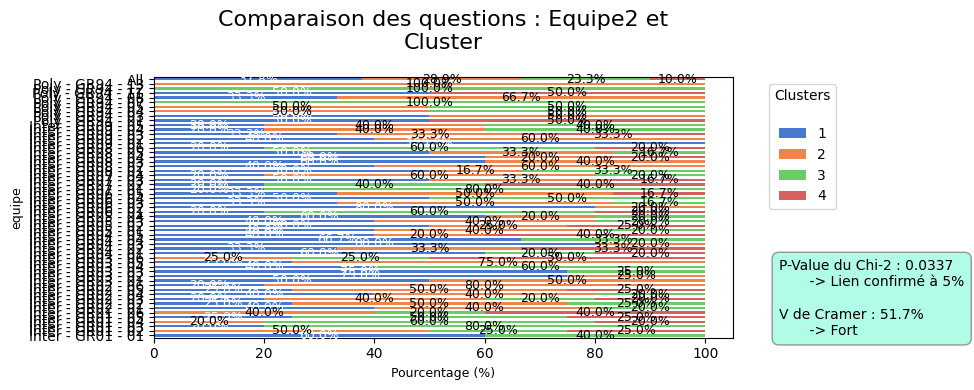


Le diagramme en barres sectionnées a été généré avec succès.


In [ ]:
barh(data=df_clust, col2 = 'cluster', col1 = 'equipe2' ,palette='muted', refCol=refColonnes, 
            folder='None', file_name='None', show_plot=True )

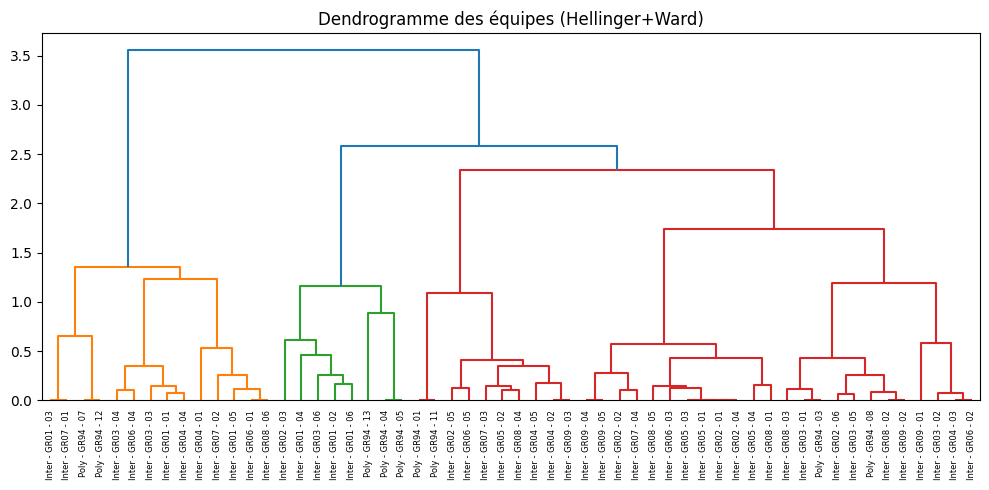

k_equipes (Hellinger) = 4, silhouette max = 0.387


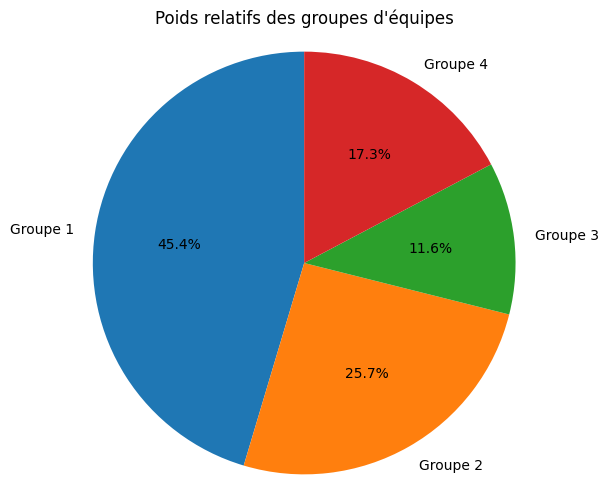


Chi2 global groupes_equipe × cluster : chi2=108.1, ddl=9, p=3.58e-19

Résiduels standardisés (groupes d'équipes × cluster):
cluster           1     2     3     4
groupe_equipe                        
1              1.28  2.51 -2.21 -3.37
2             -0.03 -4.30  4.94 -0.17
3             -3.01  1.25  0.86  2.40
4              0.44  0.16 -3.16  3.70

V de Cramér = 0.380

Groupe 1 – top surreprésentations (résiduels):
cluster
2    2.51
1    1.28
3   -2.21
4   -3.37

Groupe 2 – top surreprésentations (résiduels):
cluster
3    4.94
1   -0.03
4   -0.17
2   -4.30

Groupe 3 – top surreprésentations (résiduels):
cluster
4    2.40
2    1.25
3    0.86
1   -3.01

Groupe 4 – top surreprésentations (résiduels):
cluster
4    3.70
1    0.44
2    0.16
3   -3.16


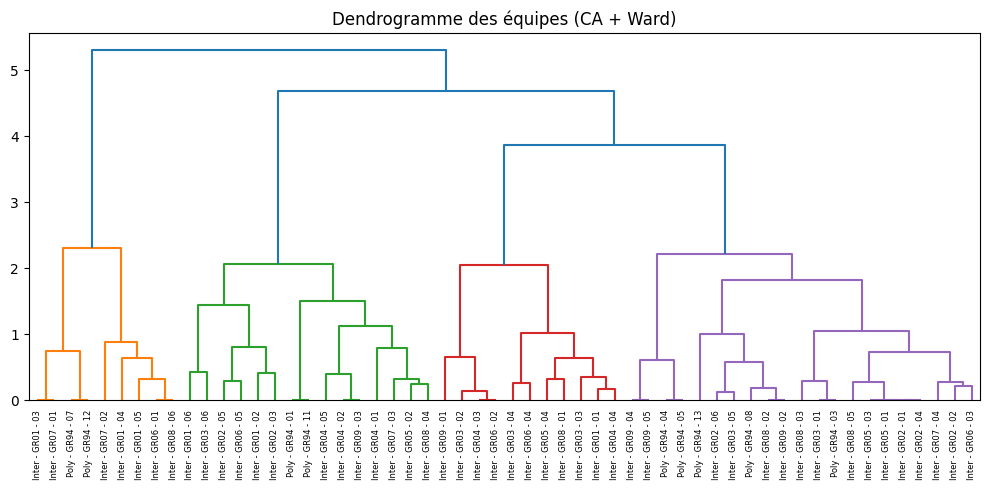

k_equipes (CA) = 4, silhouette max = 0.349

Aperçu groupes (CA):
equipe2
Inter - GR01 - 04    1
Inter - GR01 - 03    1
Inter - GR01 - 05    1
Inter - GR06 - 01    1
Poly - GR94 - 07     1
Inter - GR08 - 06    1
Inter - GR07 - 02    1
Inter - GR07 - 01    1
Poly - GR94 - 12     1
Inter - GR05 - 01    2
Inter - GR03 - 05    2
Inter - GR05 - 03    2
Inter - GR02 - 02    2
Inter - GR03 - 01    2
Inter - GR02 - 06    2
Inter - GR02 - 01    2
Inter - GR08 - 02    2
Inter - GR08 - 05    2
Poly - GR94 - 04     2
Poly - GR94 - 03     2
Name: groupe_equipe_CA, dtype: int64


In [392]:
#### On regroupe les équipes selon leur cluster de leurs membres

# --- 0) préparer df_base avec 'equipe' et 'cluster'
df_base = df_clust[['equipe2','cluster']].dropna()

# --- 1) contingence et profils-lignes
tab = pd.crosstab(df_base['equipe2'], df_base['cluster'])
profiles = tab.div(tab.sum(axis=1), axis=0).replace(0, 1e-12)  # éviter 0 exact

# ===========================
# OPTION A — Hellinger + Ward
# ===========================
# Hellinger: euclidien sur sqrt(profiles)
X_hell = np.sqrt(profiles.values)

# Dendrogramme des équipes
Z = linkage(X_hell, method='ward', metric='euclidean')
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=profiles.index.tolist(), leaf_rotation=90)
plt.title("Dendrogramme des équipes (Hellinger+Ward)")
plt.tight_layout(); plt.show()

# Choix k par silhouette (sur 2..min(10, nb_équipes-1))
n_e = X_hell.shape[0]
K_MIN, K_MAX = 2, min(4, n_e - 1 if n_e > 2 else 2)
cand_k, sils = [], []
for k in range(K_MIN, K_MAX+1):
    lab = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X_hell)
    if len(np.unique(lab)) > 1:
        try:
            s = silhouette_score(X_hell, lab)
            cand_k.append(k); sils.append(s)
        except Exception:
            pass

k_equipes = cand_k[int(np.argmax(sils))] if cand_k else 2
print(f"k_equipes (Hellinger) = {k_equipes}, silhouette max = {max(sils):.3f}" if sils else f"k_equipes (Hellinger) = {k_equipes}")

# Clustering final
labels_eq = AgglomerativeClustering(n_clusters=k_equipes, linkage='ward').fit_predict(X_hell)
grp_map = pd.Series(labels_eq + 1, index=profiles.index, name='groupe_equipe')

# Ajouter au df
df_equipes = (df_base
              .join(grp_map, on='equipe2')
              .assign(weight=1))

# Pie chart (poids par groupe d’équipes, pondéré par # individus)
weights_by_group = df_equipes.groupby('groupe_equipe')['weight'].sum().sort_index()
plt.figure(figsize=(6,6))
plt.pie(weights_by_group.values,
        labels=[f"Groupe {g}" for g in weights_by_group.index],
        autopct="%.1f%%", startangle=90)
plt.title("Poids relatifs des groupes d'équipes")
plt.axis('equal'); plt.show()

# Caractérisation des groupes d’équipes par rapport aux CLUSTERS
# (1) Surreprésentation (résiduels standardisés / v-tests au niveau groupe×cluster)
tab_grp = pd.crosstab(df_equipes['groupe_equipe'], df_equipes['cluster'])
chi2, p, dof, expected = chi2_contingency(tab_grp, correction=False)
resid = (tab_grp - expected) / np.sqrt(expected)

print("\nChi2 global groupes_equipe × cluster : "
      f"chi2={chi2:.1f}, ddl={dof}, p={p:.3g}")

# Résiduels > ~2 en absolu ≈ sur/sous-représentation notable
print("\nRésiduels standardisés (groupes d'équipes × cluster):")
print(resid.round(2))

# (2) V de Cramér (taille d’effet)
n = tab_grp.values.sum()
phi2 = chi2 / n
r, c = tab_grp.shape
cramer_v = sqrt(phi2 / max(min(r-1, c-1), 1))
print(f"\nV de Cramér = {cramer_v:.3f}")

# Détail par groupe : top clusters surreprésentés (résiduels)
for g in tab_grp.index:
    row = resid.loc[g].sort_values(ascending=False)
    print(f"\nGroupe {g} – top surreprésentations (résiduels):")
    print(row.round(2).to_string())

# ===========================
# OPTION B — CA (prince) + Ward
# ===========================
# Alternative “HCPC” : CA sur tab, puis Ward sur coords factorielles
try:
    import prince
    ca = prince.CA(n_components=min(tab.shape)-1, random_state=42)
    ca = ca.fit(tab)
    row_coord = ca.row_coordinates(tab)  # coords des équipes
    # Dendrogramme
    Z2 = linkage(row_coord.values, method='ward')
    plt.figure(figsize=(10,5))
    dendrogram(Z2, labels=tab.index.tolist(), leaf_rotation=90)
    plt.title("Dendrogramme des équipes (CA + Ward)")
    plt.tight_layout(); plt.show()

    # Choix k par silhouette
    cand_k2, sils2 = [], []
    for k in range(K_MIN, K_MAX+1):
        lab2 = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(row_coord.values)
        if len(np.unique(lab2)) > 1:
            try:
                s2 = silhouette_score(row_coord.values, lab2)
                cand_k2.append(k); sils2.append(s2)
            except Exception:
                pass
    k_equipes_ca = cand_k2[int(np.argmax(sils2))] if cand_k2 else 2
    print(f"k_equipes (CA) = {k_equipes_ca}" + (f", silhouette max = {max(sils2):.3f}" if sils2 else ""))

    # Clustering final
    labels_eq_ca = AgglomerativeClustering(n_clusters=k_equipes_ca, linkage='ward').fit_predict(row_coord.values)
    grp_map_ca = pd.Series(labels_eq_ca + 1, index=tab.index, name='groupe_equipe_CA')
    print("\nAperçu groupes (CA):")
    print(grp_map_ca.sort_values().head(20))
except Exception as e:
    print(f"[INFO] CA (prince) non exécutée: {e}")


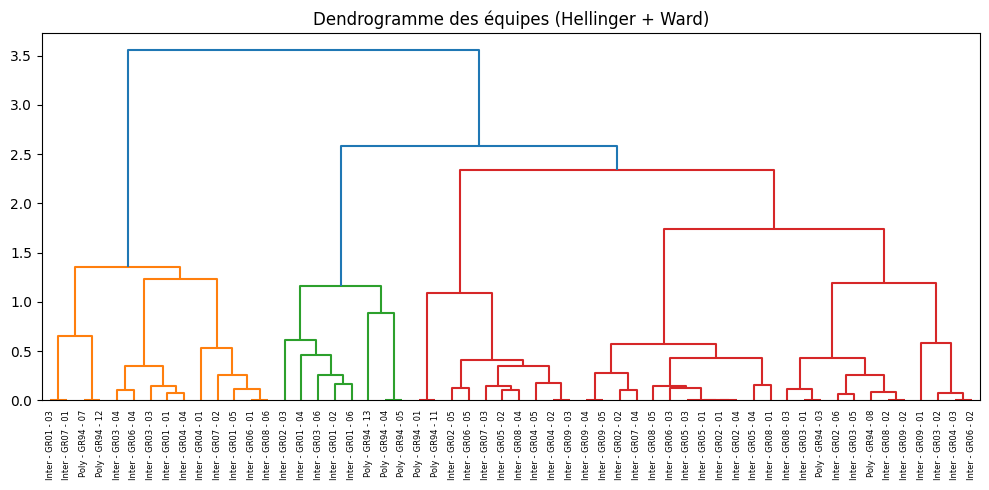

k groupes d'équipes = 5 (silhouette max = 0.553)
Caractérisation des groupes d'équipes (pourcentages & résiduels):
Groupe 1:
 cluster  n_group  pct_cluster  pct_overall  diff_pct  residual_std
       3       64        53.12        23.29     29.83          4.94
       1       64        37.50        37.75     -0.25         -0.03
       4       64         9.38        10.04     -0.67         -0.17
       2       64         0.00        28.92    -28.92         -4.30
Groupe 2:
 cluster  n_group  pct_cluster  pct_overall  diff_pct  residual_std
       1       51         54.9        37.75     17.15          1.99
       2       51         45.1        28.92     16.18          2.15
       4       51          0.0        10.04    -10.04         -2.26
       3       51          0.0        23.29    -23.29         -3.45
Groupe 3:
 cluster  n_group  pct_cluster  pct_overall  diff_pct  residual_std
       4       29        24.14        10.04     14.10          2.40
       2       29        41.38        2

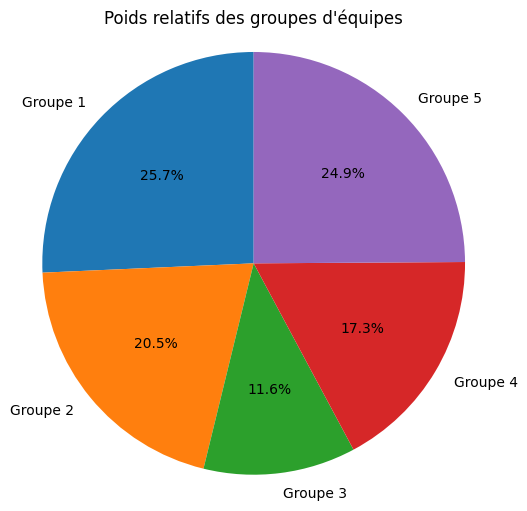

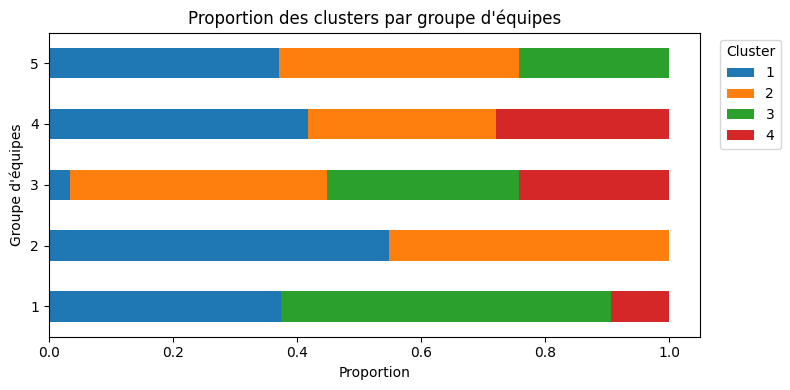

In [33]:
EQUIPE_COL = 'equipe2'
K_EQUIPE_OVERRIDE = 5   # forcer k des groupes d'équipes (None => auto silhouette)

# 1) Table de contingence equipe × cluster et profils-lignes
if EQUIPE_COL not in df3.columns and EQUIPE_COL not in df_cah.columns:
    print(f"[WARN] La colonne '{EQUIPE_COL}' est introuvable dans df3/df_cah. Section ignorée.")
else:
    df_base = (df_clust[[EQUIPE_COL, 'cluster']]
               if EQUIPE_COL in df_clust.columns
               else df3[[EQUIPE_COL]].join(df_clust['cluster'], how='inner'))
    df_base = df_base.dropna(subset=[EQUIPE_COL, 'cluster'])

    tab_eq = pd.crosstab(df_base[EQUIPE_COL], df_base['cluster'])
    profiles_eq = tab_eq.div(tab_eq.sum(axis=1), axis=0).replace(0.0, 1e-12)

    # 2) Hellinger + Ward (euclidien sur racine des profils)
    X_hell = np.sqrt(profiles_eq.values)

    # Dendrogramme (optionnel)
    try:
        Z_eq = linkage(X_hell, method='ward', metric='euclidean')
        fig = plt.figure(figsize=(10, 5))
        dendrogram(Z_eq, labels=profiles_eq.index.tolist(), leaf_rotation=90)
        plt.title("Dendrogramme des équipes (Hellinger + Ward)")
        plt.tight_layout(); save_fig(fig, "dendrogramme_equipes"); plt.show()
    except Exception as e:
        print(f"[WARN] Dendrogramme équipes non généré: {e}")

    # Choix automatique de k par silhouette
    n_e = X_hell.shape[0]
    K_MIN, K_MAX = 2, max(2, min(10, n_e - 1))
    cand_k, sils = [], []
    for k in range(K_MIN, K_MAX + 1):
        lab = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X_hell)
        if len(np.unique(lab)) > 1:
            try:
                s = silhouette_score(X_hell, lab)
                cand_k.append(k); sils.append(s)
            except Exception:
                pass
    k_equipes = int(K_EQUIPE_OVERRIDE) if K_EQUIPE_OVERRIDE is not None else (cand_k[int(np.argmax(sils))] if cand_k else 2)
    print(f"k groupes d'équipes = {k_equipes}" + (f" (silhouette max = {max(sils):.3f})" if sils else ""))

    labels_eq = AgglomerativeClustering(n_clusters=k_equipes, linkage='ward').fit_predict(X_hell)
    grp_map = pd.Series(labels_eq + 1, index=profiles_eq.index, name='groupe_equipe')

    # Ajouter au niveau individu
    df_equipe_groups = df_base.join(grp_map, on=EQUIPE_COL)

    # 3) Caractérisation des groupes d'équipes par rapport aux CLUSTERS
    #    (a) Sur/sous-représentation : résiduels standardisés et pourcentages
    tab_grp = pd.crosstab(df_equipe_groups['groupe_equipe'], df_equipe_groups['cluster'])
    chi2, p, dof, expected = chi2_contingency(tab_grp, correction=False)
    resid = (tab_grp - expected) / np.sqrt(expected)

    # Pourcentages demandés : pct_cluster (dans le groupe), pct_overall (global), diff_pct
    N = int(tab_grp.values.sum())
    pct_overall_by_cluster = tab_grp.sum(axis=0) / max(N, 1)

    rows_char = []
    for g in tab_grp.index:
        n_g = int(tab_grp.loc[g].sum())
        for c in tab_grp.columns:
            pg = float(tab_grp.loc[g, c]) / max(n_g, 1)            # part de cluster c dans le groupe g
            p0 = float(pct_overall_by_cluster.loc[c])              # part globale de c
            rows_char.append({
                'groupe_equipe': g,
                'cluster': c,
                'n_group': n_g,
                'pct_cluster': 100.0 * pg,
                'pct_overall': 100.0 * p0,
                'diff_pct': 100.0 * (pg - p0),
                'residual_std': float(resid.loc[g, c])
            })
    char_grp = pd.DataFrame(rows_char).sort_values(['groupe_equipe', 'diff_pct'], ascending=[True, False])

    print("Caractérisation des groupes d'équipes (pourcentages & résiduels):")
    for g, sub in char_grp.groupby('groupe_equipe'):
        print(f"Groupe {g}:")
        print(sub[['cluster','n_group','pct_cluster','pct_overall','diff_pct','residual_std']].round(2).to_string(index=False))

    #    (b) Force d'association globale : V de Cramér
    phi2 = chi2 / max(N, 1)
    r, c = tab_grp.shape
    cramers_v = sqrt(phi2 / max(min(r - 1, c - 1), 1))
    print(f"Chi2 global groupes_equipe × cluster : chi2={chi2:.1f}, ddl={dof}, p={p:.3g}")
    print(f"V de Cramér = {cramers_v:.3f}")

    # 4) Pie chart des poids (nb d'individus) par groupe d'équipes
    try:
        weights_by_group = df_equipe_groups.groupby('groupe_equipe').size().sort_index()
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pie(weights_by_group.values,
               labels=[f"Groupe {g}" for g in weights_by_group.index],
               autopct="%.1f%%", startangle=90)
        ax.axis('equal'); ax.set_title("Poids relatifs des groupes d'équipes")
        save_fig(fig, "repartition_groupes_equipes")
        plt.show()
    except Exception as e:
        print(f"[WARN] Pie chart groupes d'équipes non généré: {e}")

    # 4bis) Barplot horizontal des proportions de clusters par groupe d'équipes
    try:
        prop_grp = tab_grp.div(tab_grp.sum(axis=1), axis=0).fillna(0.0)
        fig, ax = plt.subplots(figsize=(8, max(3, 0.6 * len(prop_grp) + 1)))
        prop_grp.plot(kind='barh', stacked=True, ax=ax)
        ax.set_xlabel("Proportion")
        ax.set_ylabel("Groupe d'équipes")
        ax.set_title("Proportion des clusters par groupe d'équipes")
        ax.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        save_fig(fig, "barh_proportions_groupes_equipes")
        plt.show()
    except Exception as e:
        print(f"[WARN] Barplot horizontal non généré: {e}")


    # 5) Export des mappings (facultatif)
    # grp_map.to_csv("mapping_equipes_groupes.csv", header=True)
    # char_grp.to_csv("caracterisation_groupes_equipes.csv", index=False)


In [34]:
df_clust.to_parquet('df_clust_CAH.parquet')

ANALYSE DES VARIABLES QUALITATIVES

In [ ]:
### Préparation des fonctions et éléments utilitaires pour l'analyse

"""
Analyse qualitative (quali1..quali4) avec un LLM gratuit (VS Code + Ollama)
-----------------------------------------------------------------------------
Objectif :
1) Analyse globale : résumer le contenu de chaque colonne (message principal, thèmes, etc.)
2) Regrouper les réponses de chaque variable en ≤ 5 classes (et créer qualiX_cat)
3) Analyser le lien entre ces classes et :
     • les clusters (CAH ou autre) déjà créés (colonne 'cluster')
     • les variables existantes varAct et VarSup (catégorielles)
"""

from __future__ import annotations
import os, re, json, time
from typing import List, Dict, Any, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from requests.exceptions import ReadTimeout, ConnectTimeout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from scipy.stats import chi2_contingency
from math import sqrt
from concurrent.futures import ThreadPoolExecutor, as_completed

# =====================
# ====== CONFIG =======
# =====================
QUALI_COLS = ["quali1", "quali2", "quali3", "quali4", "quali5", "quali6"]
#QUALI_COLS = ["quali3"]
RANDOM_STATE = 4226

# Nettoyage/échantillonnage
MIN_ANSWER_LEN = 10
STOP_ANSWERS = {"ras","r.a.s","r a s","neant","néant","aucun","/","-","n/a","na","rien","."}
SAMPLE_SUMMARY_N = 200   # plus petit => plus rapide (était 200/500)
CHUNK_SIZE = 80          # ~40 réponses par lot => prompts compacts
N_JOBS_SUMMARY = 2       # paralléliser 2 lots en même temps (mettre 1 si CPU lent)
SAMPLE_CLUSTER_N = 1000  # clustering texte
MAX_CLASSES = 5

# Ollama (LLM local)
USE_OLLAMA = True
OLLAMA_URL = os.environ.get("OLLAMA_URL", "http://localhost:11434")
# Pour la vitesse, 'mistral:7b-instruct' est un bon compromis ; garde variable d'env pour override
OLLAMA_MODEL = os.environ.get("OLLAMA_MODEL", "mistral:7b-instruct")
OLLAMA_JSON_MODE = True
# Timeouts & bornes de génération
OLLAMA_TIMEOUT = (10, 600)  # (connect, read) sec → 10 s / 10 min
LLM_GENERATION_OPTS = {
    "num_predict": 256,   # borne la génération (plus petit => plus rapide)
    "num_ctx": 8192,      # contexte raisonnable
    "temperature": 0.1,
    "top_p": 0.9,
    "keep_alive": "30m"   # garde le modèle en mémoire
}

# Embeddings
EMBED_MODEL_NAME = os.environ.get("EMBED_MODEL", "sentence-transformers/all-MiniLM-L6-v2")
_embedder: SentenceTransformer | None = None

# Prompt système
_DEF_SYS_PROMPT = (
    "Tu es un analyste chercheur en éducation travaillant sur des réponses d'élèves. "
    "Réponds en FRANÇAIS, concis, factuel, STRUCTURÉ, et STRICTEMENT au format JSON demandé. "
    "N'écris pas de champs vides : si une info manque, mets une courte chaîne explicite."
)

# =====================
# === OLLAMA HELPERS ===
# =====================

def ollama_is_alive() -> bool:
    if not USE_OLLAMA:
        return False
    try:
        r = requests.get(f"{OLLAMA_URL}/api/tags", timeout=5)
        return r.status_code == 200
    except Exception:
        return False


def call_llm(prompt: str, expect_json: bool = False, temperature: float = 0.1) -> str:
    """Appelle Ollama et renvoie la réponse texte. Gère un retry sur timeout."""


    
    if not ollama_is_alive():
        raise RuntimeError("Ollama n'est pas joignable. Lance 'ollama serve' et charge un modèle.")
    payload = {
        "model": OLLAMA_MODEL,
        "prompt": f"<s>[INST] {_DEF_SYS_PROMPT}\n\n{prompt} [/INST]>",
        "stream": False,
        "options": {**LLM_GENERATION_OPTS, "temperature": temperature},
    }
    if expect_json and OLLAMA_JSON_MODE:
        payload["format"] = "json"

    try:
        r = requests.post(f"{OLLAMA_URL}/api/generate", json=payload, timeout=OLLAMA_TIMEOUT)
        r.raise_for_status()
        return r.json().get("response", "").strip()
    except (ReadTimeout, ConnectTimeout):
        # retry unique avec génération bornée
        payload["options"]["num_predict"] = 128
        r2 = requests.post(f"{OLLAMA_URL}/api/generate", json=payload, timeout=OLLAMA_TIMEOUT)
        r2.raise_for_status()
        return r2.json().get("response", "").strip()


def parse_json_loose(txt: str) -> dict:
    """Parse JSON tolérant (extrait { ... } et répare virgules finales)."""
    try:
        return json.loads(txt)
    except Exception:
        m = re.search(r"\{[\s\S]*\}", txt)
        if not m:
            return {}
        block = m.group(0)
        block = re.sub(r",\s*\}", "}", block)
        block = re.sub(r",\s*\]", "]", block)
        try:
            return json.loads(block)
        except Exception:
            return {}


def call_llm_json_robust(prompt: str) -> dict:
    """Appelle le LLM en JSON, avec fallback non-JSON et tolérance de parsing."""
    # 1) tentative JSON
    try:
        resp = call_llm(prompt, expect_json=True)
        data = parse_json_loose(resp)
        if data:
            return data
    except Exception:
        pass
    # 2) tentative non-JSON
    try:
        resp2 = call_llm(prompt, expect_json=False)
        data2 = parse_json_loose(resp2)
        if data2:
            return data2
    except Exception:
        pass
    return {}

# =====================
# === UTILITAIRES TXT ===
# =====================

def prepare_texts(df: pd.DataFrame, col: str, n: int) -> List[str]:
    s = df[col].fillna("").astype(str).str.strip()
    s = s[~s.str.lower().isin(STOP_ANSWERS)]
    s = s[s.str.len() >= MIN_ANSWER_LEN]
    s = s.drop_duplicates()
    if len(s) > n:
        s = s.sample(n, random_state=RANDOM_STATE)
    return s.tolist()

# Normalisation légère pour matching approx.
_WS_RE = re.compile(r"\s+")
_PUNC_RE = re.compile(r"[^a-z0-9' ]+")

def normalize_text(t: str) -> str:
    t = t.strip().lower()
    try:
        from unidecode import unidecode
        t = unidecode(t)
    except Exception:
        pass
    t = _PUNC_RE.sub(" ", t)
    t = _WS_RE.sub(" ", t).strip()
    return t


def jaccard(a: str, b: str) -> float:
    A = set(normalize_text(a).split())
    B = set(normalize_text(b).split())
    if not A or not B:
        return 0.0
    return len(A & B) / len(A | B)


def select_representative_quotes(texts: List[str], k: int = 3) -> List[str]:
    if not texts:
        return []
    k = max(1, min(k, len(texts)))
    # TF-IDF centroid + diversité simple
    vec = TfidfVectorizer(max_features=500, ngram_range=(1,2), min_df=1)
    X = vec.fit_transform(texts)
    centroid = np.asarray(X.mean(axis=0)).ravel()
    sims = (X @ centroid)  # produit scalaire ~ similarité au centre
    sims = np.asarray(sims).ravel()
    order = np.argsort(-sims)
    picked = []
    for idx in order:
        cand = texts[idx]
        if all(jaccard(cand, texts[j]) < 0.6 for j in picked):
            picked.append(idx)
        if len(picked) >= k:
            break
    return [texts[i] for i in picked]


def enforce_verbatim_quotes(all_texts: List[str], proposed: List[str], k_min: int = 3, k_max: int = 5) -> List[str]:
    """Mappe chaque citation proposée vers une phrase EXACTE du jeu d'entrée. Si échec, sélectionne des citations représentatives.
    """
    if not all_texts:
        return []
    target_k = min(max(k_min, len(proposed) if proposed else k_min), k_max)
    out: List[str] = []
    # dictionnaire pour matching rapide
    norm_map = {normalize_text(t): t for t in all_texts}

    # 1) tentatives d'exact match / approx
    for q in (proposed or []):
        n = normalize_text(q)
        exact = norm_map.get(n)
        if exact:
            if exact not in out:
                out.append(exact)
            continue
        # approx via meilleure Jaccard
        best, best_s = None, 0.0
        for t in all_texts:
            s = jaccard(q, t)
            if s > best_s:
                best, best_s = t, s
        if best and best_s >= 0.6 and best not in out:
            out.append(best)
        if len(out) >= target_k:
            break

    # 2) compléter si insuffisant
    if len(out) < k_min:
        need = target_k - len(out)
        add = select_representative_quotes([t for t in all_texts if t not in out], k=need)
        out.extend(add)

    # borne à k_max
    return out[:k_max]

# Schéma attendu pour le résumé
_DEF_SUMMARY_SCHEMA = {
    "main_message": "str",
    "key_themes": ["str"],
    "sentiment": "positive|negative|mixed|neutral",
    "representative_quotes": ["str"],
    "anomalies": ["str"],
}

_SUMMARY_INSTR = (
    "Tu reçois une liste de réponses d'élèves (une par ligne, précédée de '-').\n"
    "Objectif : produire un résumé structuré.\n\n"
    "EXIGENCES :\n"
    "- Message principal (1-2 phrases), écrites à la première personne du singulier (je).\n"
    "-  3 à 7 thèmes clés (mots/expressions).\n"
    "- Sentiment global (positive|negative|mixed|neutral)\n"
    "- **copie VERBATIM** de 3 à 5 phrases **exactement** telles qu'elles apparaissent dans la liste fournie (aucune paraphrase/invention).\n"
    "- Anomalies (données aberrantes, hors-sujet) si pertinent\n\n"
    "RENVOIE UNIQUEMENT un JSON valide avec les clés :\n"
    "{\"main_message\": str, \"key_themes\": [str], \"sentiment\": str, \"representative_quotes\": [str], \"anomalies\": [str]}\n"
)

# ================================
# ==== SECTION 1 : Définition des fonction à utiliser
# ================================

def summarize_one_chunk(ch: List[str]) -> dict:
    joined = "\n- " + "\n- ".join(ch)
    prompt = _SUMMARY_INSTR + "\nVoici les réponses :\n" + joined
    return call_llm_json_robust(prompt)


def summarize_column_batched(df: pd.DataFrame, col: str) -> dict:
    texts_all = prepare_texts(df, col, SAMPLE_SUMMARY_N)
    if not texts_all:
        return {k: ("" if isinstance(v, str) else []) for k, v in _DEF_SUMMARY_SCHEMA.items()}

    # 1) résumés partiels (par lots), parallélisables
    chunks = [texts_all[i:i+CHUNK_SIZE] for i in range(0, len(texts_all), CHUNK_SIZE)]
    partials = []
    if N_JOBS_SUMMARY > 1 and len(chunks) > 1:
        with ThreadPoolExecutor(max_workers=N_JOBS_SUMMARY) as ex:
            fut2idx = {ex.submit(summarize_one_chunk, ch): i for i, ch in enumerate(chunks)}
            for fut in as_completed(fut2idx):
                d = fut.result() or {}
                if d:
                    partials.append(d)
    else:
        for ch in chunks:
            d = summarize_one_chunk(ch)
            if d:
                partials.append(d)

    # si une seule passe a marché, enforce verbatim & 1re pers
    if len(partials) == 1:
        out = partials[0]
        out["representative_quotes"] = enforce_verbatim_quotes(texts_all, out.get("representative_quotes", []), 3, 5)
        # filet de sécurité minimal si pas de 1re personne
        mm = str(out.get("main_message", ""))
        if (" je " not in f" {mm.lower()} ") and (" nous " not in f" {mm.lower()} "):
            if mm:
                out["main_message"] = "Je : " + mm
        if not out.get("representative_quotes"):
            out["representative_quotes"] = select_representative_quotes(texts_all, 3)
        return out

    # 2) méta-résumé (fusion des résumés partiels)
    if partials:
        mini = []
        for d in partials:
            mm = d.get("main_message", "")
            th = ", ".join(d.get("key_themes", [])[:7])
            mini.append(f"- Message: {mm}\n  Thèmes: {th}")
        meta_prompt = _SUMMARY_INSTR + "\nVoici des résumés partiels. Fusionne-les en un seul JSON global :\n" + "\n".join(mini)
        meta = call_llm_json_robust(meta_prompt) or {}
        # enforcement verbatim + 1re pers
        meta["representative_quotes"] = enforce_verbatim_quotes(texts_all, meta.get("representative_quotes", []), 3, 5)
        mm = str(meta.get("main_message", ""))
        if (" je " not in f" {mm.lower()} ") and (" nous " not in f" {mm.lower()} "):
            if mm:
                meta["main_message"] = "Nous : " + mm
        if not meta.get("representative_quotes"):
            meta["representative_quotes"] = select_representative_quotes(texts_all, 3)
        return meta

    # 3) Fallback TF-IDF amélioré si tout a échoué
    try:
        vec = TfidfVectorizer(max_features=200, ngram_range=(1,2), min_df=2)
        X = vec.fit_transform(texts_all)
        mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
        feats = np.array(vec.get_feature_names_out())
        top_idx = mean_tfidf.argsort()[::-1][:10]
        top_terms = feats[top_idx].tolist()
    except Exception:
        top_terms = list({w for t in texts_all[:50] for w in t.split()})[:10]

    return {
        "main_message": "Résumé LLM indisponible. Fallback TF-IDF.",
        "key_themes": top_terms,
        "sentiment": "",
        "representative_quotes": select_representative_quotes(texts_all, 3),
        "anomalies": [],
    }


In [ ]:
# =====================
# === SECTION 1 : Résumé global (rapide, verbatim, 1re pers.) ===
# =====================

# === Boucle d'exécution Section 1 ===
results_summary: Dict[str, Dict[str, Any]] = {}
for col in QUALI_COLS:
    if col not in df_clust.columns:
        print(f"[INFO] Colonne {col} absente — ignorée.")
        continue
    summ = summarize_column_batched(df_clust, col)
    results_summary[col] = summ
    print(f"\n=== Résumé {col} ===")
    print(json.dumps(summ, ensure_ascii=False, indent=2))


=== Résumé quali1 ===
{
  "main_message": "Je m'assure de communiquer clairement avec mon équipe et d'aider chacun à comprendre les problèmes en utilisant des exemples, des questions, des discussions et des rapports de travail collaboratifs. En outre, je veille à ce que tout le monde comprend le problème et que nous avons tous les mêmes informations pour arriver à une solution commune.",
  "key_themes": [
    "communication",
    "clarity",
    "collaboration",
    "problem-solving",
    "understanding"
  ],
  "sentiment": "positive",
  "representative_quotes": [
    "J'essaie de résumer rapidement ce qu'on doit faire et ensuite je demande à tout le monde qu'est ce qu'il en pensent au qu'est ce qu'ils vont faire comme démarches et manipulations. Je leur demande aussi s'ils ont des idées pour résoudre le problème, que nous pouvons ensuite compiler ensemble.",
    "Je demande de m'expliquer le raisonnement pour voir s'ils ont compris et sont à l'aise avec le sujet. \nJe leur pose des qu

In [12]:
results_summary: Dict[str, Dict[str, Any]] = {}

results_summary['quali1'] = {
  "main_message": "Je m'assure de communiquer clairement avec mon équipe et d'aider chacun à comprendre les problèmes en utilisant des exemples, des questions, des discussions et des rapports de travail collaboratifs. En outre, je veille à ce que tout le monde comprend le problème et que nous avons tous les mêmes informations pour arriver à une solution commune.",
  "key_themes": [
    "communication",
    "clarity",
    "collaboration",
    "problem-solving",
    "understanding"
  ],
  "sentiment": "positive",
  "representative_quotes": [
    "J'essaie de résumer rapidement ce qu'on doit faire et ensuite je demande à tout le monde qu'est ce qu'il en pensent au qu'est ce qu'ils vont faire comme démarches et manipulations. Je leur demande aussi s'ils ont des idées pour résoudre le problème, que nous pouvons ensuite compiler ensemble.",
    "Je demande de m'expliquer le raisonnement pour voir s'ils ont compris et sont à l'aise avec le sujet. \nJe leur pose des questions et leur demande de faire des liens avec des concepts / exemples de la vie de tous les jours.",
    "Je leur pose des questions et je discute des tâches à effectuer. Je partage mon point de vue de la tâche et je m'assure que nous pensons tous la même chose. Si nos idées se diffèrent, je révise avec eux les documents."
  ],
  "anomalies": []
}

results_summary['quali2'] = {
  "main_message": "Je m'assure que mon équipe et moi avons une bonne compréhension du problème et nous travaillons ensemble pour trouver des solutions efficaces en participant à des discussions, en proposant des idées et en recherchant des informations.",
  "key_themes": [
    "comprehension",
    "collaboration",
    "problem-solving",
    "discussions",
    "idées",
    "informations",
    "travail partagé"
  ],
  "sentiment": "positive",
  "representative_quotes": [
    "J'ai coordonné les actions de mon équipe en fonction de leurs forces et faiblesses afin de se répartir efficacement les tâches pour résoudre le problème.",
    "J'ai partagé mon opinion et j'ai prouvé mes idées avec des sources. J'ai aussi aidé à rechercher sur leurs idées pour par la suite en discuter.",
    "Je leur ai rappelé les notions que nous avons vu au début de l'année, l'on passé et même dans d'autres matières pour qu'elles aient les bonnes bases pour résoudre le problème."
  ],
  "anomalies": []
}

results_summary['quali3'] = {
  "main_message": "Je m'assure de travailler en équipe pour résoudre efficacement les problèmes, en se séparant les tâches et en communiquant régulièrement. En divisant les tâches entre tous les membres de l'équipe, nous pouvons travailler plus efficacement et communiquer mieux.",
  "key_themes": [
    "équipe",
    "communication",
    "organisation",
    "diviser les tâches",
    "collaboration"
  ],
  "sentiment": "positive",
  "representative_quotes": [
    "Je divise les tâches selon la capacité de chacune. Si une d'entre elles est plus à l'aise à équilibrer des équations, c'est elle qui s'en chargera. De plus, je dresse une liste de choses à faire et je coche les tâches au fur et à mesure.",
    "En séparant les tâches.",
    "Je demande de l’aide seulement à quelques membres de l’équipe pour ne pas retarder le travail. Autrement dit, on sépare les tâches, donc ce n’est pas tout le monde à la fois qui résout le problème."
  ],
  "anomalies": []
}

results_summary['quali4'] = {
  "main_message": "Je cherche à améliorer les solutions proposées en utilisant ma pensée critique, mes connaissances et en collaborant avec mon équipe. En travaillant ensemble, nous cherchons à trouver des solutions efficaces en utilisant la logique, les connaissances acquises et en partageant nos idées.",
  "key_themes": [
    "collaboration",
    "critical thinking",
    "knowledge sharing",
    "problem solving",
    "research",
    "logique",
    "communication",
    "discussion"
  ],
  "sentiment": "positive",
  "representative_quotes": [
    "Je pousse la recherche et nos connaissances du sujet afin d'offrir un point de vue, des pistes de solutions et des nouvelles notions qui enrichissent et consolident nos idées, et nous mènent à la solution optimale pour notre problème.",
    "Je donne mes idées et je médite sur les idées de tout le monde pour trouver des point forts et des point faibles pour en discuter avec mon équipe.",
    "J'analyse les idées qui viennent en tête à chaque membre de l'équipe, en faisant une tempête d'idées. Ensuite, j'essaye de modifier les idées en foction de contexte et de problème. Je me fais également des scènarios qui évaluent les possibilitées face au problème."
  ],
  "anomalies": ""
}

results_summary['quali5'] = {
  "main_message": "En utilisant diverses méthodes telles que la recherche en ligne, la collaboration avec d'autres équipes et le partage de connaissances, nous avons trouvé des informations utiles pour résoudre notre problème.",
  "key_themes": [
    "Recherche en ligne",
    "Collaboration",
    "Partage de connaissances",
    "Apprentissage antérieur"
  ],
  "sentiment": "positive",
  "representative_quotes": [
    "Nous mettons en commun nos connaissances afin de pouvoir réfléchir efficacement et ensembles à des solutions. \nNous accompagnions nos réflections par des recherches en ligne pour combler nos trous de mémoire ou nos interrogations.",
    "On a demandé aux autres équipes et on a fait des recherches en ligne pour s’inspirer.",
    "Notre équipe a trouvé des informations en cherchant dans les cahiers d'apprentissage et en faisant des recherches sur Internet afin de nous aider à résoudre le problème."
  ],
  "anomalies": ""
}


results_summary['quali6'] = {
  "main_message": "Je demande à un camarade quand je n'ai pas compris une notion ou que j'ai besoin d'aide pour résoudre un problème. Je préfère demander à un camarade avant mon enseignant pour obtenir des nouvelles idées et faciliter ma compréhension.",
  "key_themes": [
    "demander a un camarade",
    "comprendre une notion",
    "resoudre un probleme",
    "enseignants",
    "camarades"
  ],
  "sentiment": "positive",
  "representative_quotes": [
    "Même si un enseignant sait plus que moi, il n’éprouve aucune difficulté dans la matière et la comprend en profondeur, et parfois cela l’empêche de voir exactement ce que je sais et ce que je ne sais pas. Il voit mon erreur, mais pas ce qui m’a amené à la faire.\nUn élève qui a compris est plus proche de ma manière de raisonner. Pas qu’il soit plus simple, mais plus facile à relier à mes propres manières de penser.",
    "Lorsque j'ai déjà demandé du prof et qu'il ne m'a pas trop aidé. Lorsque je ne trouve pas l'enseignant. Lorsque c'est une revision de dernière minute et le prof n'est pas disponible.",
    "Lorsque c'est quelque chose qu'il a déjà expliqué et que je ne comprends pas, reformulations d'un autre élève. Lorsque je considère que c'est seulement une petite question simple à répondre. Un autre élève pouvait me dire la matière dans des mots que je comprends mieux, par exemple."
  ],
  "anomalies": ""
}

In [13]:
### On sauvegarde l'analyse sémantique

with open('llm_general.json','w',encoding='utf-8') as f:
    json.dump(results_summary,f, ensure_ascii=False, indent=2)

In [14]:
### ==================
### ==== on réimporte df_clust
### ===================

df_clust = pd.read_parquet("df_clust_CAH.parquet")


In [9]:
# =====================
# === SECTION 1 - bis : Résumé de chaque variable par cluster ===
# =====================
QUALI_COLS = ["quali1","quali2","quali3","quali4","quali5","quali6"]

# === Boucle d'exécution Section 1 ===
results_summary_clust: Dict[str, Dict[str, Any]] = {}
for col in QUALI_COLS:
    if col not in df_clust.columns:
        print(f"[INFO] Colonne {col} absente — ignorée.")
        continue
    for clust in df_clust['cluster'].unique():
        df_temp = df_clust[df_clust['cluster'] == clust]
        summ = summarize_column_batched(df_temp, col)
        results_summary_clust[f"{col} - Cluster {clust}"] = summ
        print(f"\n=== Résumé de {col} pour le cluster {clust} ===")
        print(json.dumps(summ, ensure_ascii=False, indent=2))


=== Résumé de quali1 pour le cluster 2 ===
{
  "main_message": "Je m'assure que tout le monde comprend le problème en communiquant, discutant et posant des questions pertinentes.",
  "key_themes": [
    "communication",
    "discussion",
    "questions",
    "comprehension"
  ],
  "sentiment": "positive",
  "representative_quotes": [
    "Nous en discutons tous ensemble avant d'entamer la résolution.",
    "Je demande à tous les membres s'ils ont compris avant de passer aux étapes suivantes. S'ils n'ont pas compris, on s'arrête, on explique et on s'assure que tout le monde a compris avant d'avancer.",
    "Nous procédons a une discussion sur le problème à résoudre pour mettre en commun ce que chacun des membres a compris pour s'assurer que nous sommes sur la meme longueur d'onde."
  ],
  "anomalies": []
}

=== Résumé de quali1 pour le cluster 3 ===
{
  "main_message": "Je communique et discute avec mes coéquipiers pour comprendre ensemble les problèmes et trouver des solutions.",
  "k

In [11]:
# Enregistrement du résultat final 

with open("llm_per_cluster.json", "w", encoding="utf-8") as f:
     json.dump(results_summary_clust, f, ensure_ascii=False, indent=2)

In [ ]:
# =====================
# === SECTION 2 : Regroupement en ≤5 classes + qualiX_cat ===
# ===     TENTATIVE Finalement infructueuse. à abandonner
# =====================

labels_info: Dict[str, Dict[int, Dict[str, str]]] = {}

def get_embedder() -> SentenceTransformer:
    global _embedder
    if _embedder is None:
        _embedder = SentenceTransformer(EMBED_MODEL_NAME)
    return _embedder

for col in QUALI_COLS:
    if col not in df_clust.columns:
        continue
    s_all = df_clust[col].fillna("").astype(str).str.strip()
    s_all = s_all[~s_all.str.lower().isin(STOP_ANSWERS)]
    s_all = s_all[s_all.str.len() >= MIN_ANSWER_LEN]
    if s_all.empty:
        continue

    s_sample = s_all
    if len(s_sample) > SAMPLE_CLUSTER_N:
        s_sample = s_sample.sample(SAMPLE_CLUSTER_N, random_state=RANDOM_STATE)

    texts = s_sample.tolist()
    # ---- clustering embeddings vers ≤5 classes ----
    emb = get_embedder().encode(texts, batch_size=64, show_progress_bar=False, normalize_embeddings=True)
    uniq = len(set(texts))
    if uniq <= 2:
        labels, k_found = np.zeros(len(texts), dtype=int), 1
    else:
        ks = list(range(2, min(MAX_CLASSES, uniq) + 1))
        best_k, best_s, best_labels = None, -1.0, None
        for k in ks:
            km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
            lab = km.fit_predict(emb)
            try:
                s = silhouette_score(emb, lab)
            except Exception:
                s = -1.0
            if s > best_s:
                best_k, best_s, best_labels = k, s, lab
        labels, k_found = (best_labels if best_labels is not None else np.zeros(len(texts), dtype=int)), int(best_k or 1)

    # Exemples par groupe pour l’étiquetage
    groups: Dict[int, List[str]] = {}
    for t, lab in zip(texts, labels):
        groups.setdefault(int(lab), []).append(t)

    # Étiquetage (LLM) – pas critique pour la vitesse, mais borné
    _LABEL_PROMPT = """Tu reçois des groupes de réponses textuelles (issus d'un clustering).
        Pour chaque groupe, fournis un *libellé court* (3-5 mots) et une *description* concise en FRANÇAIS.
        Réponds en JSON liste : [{"cluster_id": int, "label": str, "description": str}]
        """
    
    lab_map: Dict[int, Dict[str,str]] = {}
    try:
        parts = []
        for gid, lst in groups.items():
            sample = lst[:20]
            joined = "\n- " + "\n- ".join(sample)
            parts.append(f"Groupe {gid}: {joined}")
        prompt = _LABEL_PROMPT + "\n" + "\n\n".join(parts)
        resp = call_llm(prompt, expect_json=True)
        try:
            data = json.loads(resp)
        except Exception:
            m = re.search(r"\[.*\]", resp, flags=re.S)
            data = json.loads(m.group(0)) if m else []
        for d in data:
            cid = int(d.get("cluster_id"))
            lab_map[cid] = {"label": str(d.get("label", f"Classe {cid}")), "description": str(d.get("description", ""))}
    except Exception:
        # Fallback TF‑IDF : mots-clés
        for gid, lst in groups.items():
            vec = TfidfVectorizer(max_features=5)
            _ = vec.fit_transform(lst)
            keywords = sorted(vec.vocabulary_.keys())
            lab_map[gid] = {"label": ", ".join(keywords), "description": "(label TF-IDF)"}

    labels_info[col] = lab_map

    # Affectation finale sur TOUTES les réponses
    emb_all = get_embedder().encode(s_all.tolist(), batch_size=64, show_progress_bar=False, normalize_embeddings=True)
    if k_found <= 1:
        final_labels = np.zeros(len(s_all), dtype=int)
    else:
        km_all = KMeans(n_clusters=int(k_found), random_state=RANDOM_STATE, n_init=20)
        final_labels = km_all.fit_predict(emb_all)

    ser_id = pd.Series(final_labels, index=s_all.index, name=f"{col}_cat_id")
    def _name_for(i: int) -> str:
        info = lab_map.get(i, None)
        return (info.get("label") if info else f"Classe {i}")
    ser_name = ser_id.map(lambda x: _name_for(int(x)))
    ser_name.name = f"{col}_cat"

    # écrire dans df_clust (en respectant les NA originales)
    df_clust[ser_id.name] = pd.NA
    df_clust.loc[ser_id.index, ser_id.name] = ser_id
    df_clust[ser_name.name] = pd.NA
    df_clust.loc[ser_name.index, ser_name.name] = ser_name

    print(f"\nCréé : {ser_name.name} (k={k_found})")
    if lab_map:
        print("Libellés de classes :", {i: v["label"] for i, v in lab_map.items()})






Créé : quali1_cat (k=2)
Libellés de classes : {0: 'de, et, le, nous, on', 1: 'de, et, je, le, on'}

Créé : quali2_cat (k=3)

Créé : quali3_cat (k=3)
Libellés de classes : {0: 'de, et, les, on, tâches', 1: 'de, en, je, nous, que', 2: 'de, en, et, je, le'}

Créé : quali4_cat (k=4)

Créé : quali5_cat (k=3)

Créé : quali6_cat (k=5)
Libellés de classes : {1: 'Absence du professeur', 2: 'Comprehension difficile', 3: 'Validation rapide', 4: 'Travaux pratiques'}


In [41]:
# =====================
# === SECTION 3 : Liens avec 'cluster', varAct, VarSup ===
# =====================

def chi2_cramer_table(df: pd.DataFrame, a: str, b: str) -> Dict[str, Any]:
    tab = pd.crosstab(df[a], df[b])
    if tab.size == 0 or (tab.shape[0] < 2 or tab.shape[1] < 2):
        return {"chi2": np.nan, "dof": 0, "p": np.nan, "cramers_v": np.nan, "table": tab, "expected": np.zeros_like(tab)}
    chi2, p, dof, expected = chi2_contingency(tab, correction=False)
    n = tab.values.sum()
    phi2 = chi2 / max(n, 1)
    r, c = tab.shape
    V = sqrt(phi2 / max(min(r - 1, c - 1), 1))
    return {"chi2": chi2, "dof": int(dof), "p": p, "cramers_v": V, "table": tab, "expected": expected}

# 3a) qualiX_cat × cluster
if 'cluster' in df_clust.columns:
    for col in QUALI_COLS:
        cat_col = f"{col}_cat"
        if cat_col in df_clust.columns:
            sub = df_clust.dropna(subset=[cat_col, 'cluster'])
            res = chi2_cramer_table(sub, cat_col, 'cluster')
            print(f"\n=== Lien {cat_col} × cluster ===")
            if np.isnan(res['chi2']):
                print("Contingence dégénérée (trop peu de modalités).")
            else:
                print(f"Chi2={res['chi2']:.2f}, ddl={res['dof']}, p={res['p']:.3g}, V={res['cramers_v']:.3f}")
                resid = (res['table'] - res['expected']) / np.sqrt(res['expected'])
                print("Résiduels (aperçu):\n" + resid.round(2).head().to_string())
else:
    print("[INFO] Colonne 'cluster' absente — section 3a ignorée.")

# 3b) qualiX_cat × (varAct ∪ VarSup)
_def_vars: List[str] = []
if 'varAct' in globals() and isinstance(varAct, (list, tuple)):
    _def_vars += [v for v in varAct if v in df_clust.columns]
if 'VarSup' in globals() and isinstance(varSup, (list, tuple)):
    _def_vars += [v for v in varSup if v in df_clust.columns]

for col in QUALI_COLS:
    cat_col = f"{col}_cat"
    if cat_col not in df_clust.columns:
        continue
    print(f"\n=== Lien {cat_col} × (varAct ∪ VarSup) ===")
    rows = []
    for v in _def_vars:
        sub = df_clust.dropna(subset=[cat_col, v])
        if sub.empty:
            continue
        res = chi2_cramer_table(sub, cat_col, v)
        rows.append({"variable": v, "chi2": res['chi2'], "dof": res['dof'], "p": res['p'], "cramers_v": res['cramers_v']})
    if rows:
        out = pd.DataFrame(rows).sort_values('cramers_v', ascending=False)
        print(out.round(4).head(20).to_string(index=False))
    else:
        print("Aucune variable valide trouvée.")

# =====================
# === (Option) Sauvegardes ===
# =====================
df_clust.to_parquet("df_clust_with_quali_cats.parquet")
with open("llm_labels_info.json", "w", encoding="utf-8") as f:
     json.dump(labels_info, f, ensure_ascii=False, indent=2)



=== Lien quali1_cat × cluster ===
Chi2=8.17, ddl=9, p=0.517, V=0.105
Résiduels (aperçu):
cluster        1     2     3     4
quali1_cat                        
Classe 0   -0.80  1.90 -0.75 -0.53
Classe 1    0.10  0.14  0.22 -0.74
Classe 2    0.41 -0.79  0.26  0.14
Classe 3    0.05 -0.72  0.07  1.02

=== Lien quali2_cat × cluster ===
Chi2=19.09, ddl=9, p=0.0244, V=0.162
Résiduels (aperçu):
cluster                                      1     2     3     4
quali2_cat                                                      
Classe 0                                 -0.09 -0.13  0.28 -0.04
Classe 3                                  1.23 -0.03 -1.56  0.03
Collaboration pour trouver des solutions  0.04 -1.85  1.41  0.97
Valider et justifier les solutions       -0.79  2.40 -0.90 -1.23

=== Lien quali3_cat × cluster ===
Chi2=6.94, ddl=6, p=0.326, V=0.119
Résiduels (aperçu):
cluster           1     2     3     4
quali3_cat                           
Classe 2       0.64 -0.75 -0.58  0.93
Organisation  

Création des WordClouds pour chaque question.
L'idée estde résenter de façon visuelle les principaux mots utilisés par question.

In [427]:
# ============================
# Wordclouds pour quali1..4
# ============================
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, re
from unidecode import unidecode

# --- Réglages ---
QUALI_COLS = ["quali1", "quali2", "quali3", "quali4", "quali5", "quali6"]
WC_DIR = "figures_wordclouds"
os.makedirs(WC_DIR, exist_ok=True)

# Stopwords FR basiques (ajoute/retire selon ton contexte)
STOP_FR = {
    "le","la","les","un","une","des","du","de","d","au","aux","avec","sans","sur","sous",
    "et","ou","mais","donc","or","ni","car",
    "je","tu","il","elle","nous","vous","ils","elles","on","me","te","se","moi","toi","lui","leur",
    "ce","cet","cette","ces","ça","cela","ça","c","qu","que","qui","dont","où",
    "ne","pas","plus","moins","très","tres","bien","bon","bonne","aussi","ainsi","tous","tout","toutes",
    "est","sont","ai","as","avons","avez","ont","etre","être","été","etait","étais","étaient",
    "fait","fais","faisons","faites","font","peut","peux","pouvez","peuvent","pour","par","dans","en","aujourd",
    "comme","afin","chez","entre","vers","lors","lorsque","pendant",
    "oui","non","ok","daccord","d'accord","merci","svp","s'il","sil","n","a","u","x"
}
STOP_ALL = set(STOPWORDS) | STOP_FR

# Nettoyage léger : lower, enlever URLs, ponctuation, chiffres, accents → mots simples
def clean_text_series(s: pd.Series) -> list[str]:
    s = s.fillna("").astype(str).str.strip()
    s = s[s.str.len() > 0]
    # retire réponses triviales
    STOP_ANS = {"ras","r.a.s","r a s","neant","néant","aucun","/","-","n/a","na","rien","."}
    s = s[~s.str.lower().isin(STOP_ANS)]
    # nettoie chaque entrée
    out = []
    for txt in s.tolist():
        txt = re.sub(r"http[s]?://\\S+", " ", txt)     # URLs
        txt = unidecode(txt.lower())                   # accents -> ascii
        txt = re.sub(r"[^a-z\\s']", " ", txt)          # garde lettres/espace/apostrophe
        txt = re.sub(r"\\s+", " ", txt).strip()
        out.append(txt)
    return out

def make_wc(texts: list[str], title: str, path_png: str,
            max_words: int = 150, width: int = 1400, height: int = 900):
    if len(texts) == 0:
        print(f"[INFO] Pas de texte pour {title}")
        return
    text_big = " ".join(texts)
    wc = WordCloud(
        width=width, height=height,
        background_color="white",
        stopwords=STOP_ALL,
        max_words=max_words,
        collocations=False  # évite d’écraser les mots uniques par des bigrams fréquents
    ).generate(text_big)

    fig, ax = plt.subplots(figsize=(width/200, height/200))
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)
    plt.tight_layout()
    fig.savefig(path_png, dpi=200, bbox_inches="tight")
    plt.show()

# ---------------------------
# A) Wordcloud GLOBAL par question
# ---------------------------
for col in QUALI_COLS:
    if col not in df_clust.columns:
        print(f"[INFO] {col} absent — ignoré.")
        continue
    texts = clean_text_series(df_clust[col])
    make_wc(texts, title=f"Wordcloud global – {col}",
            path_png=os.path.join(WC_DIR, f"wc_global_{col}.png"))

# ----------------------------------------
# B) (Optionnel) Wordclouds PAR CLUSTER
# ----------------------------------------
if "cluster" in df_clust.columns:
    for col in QUALI_COLS:
        if col not in df_clust.columns:
            continue
        # on filtre uniquement les lignes où la réponse est non-vide (après nettoyage)
        cleaned = pd.Series(clean_text_series(df_clust[col]), index=df_clust.index)
        non_empty_idx = cleaned[cleaned.str.len() > 0].index
        sub = df_clust.loc[non_empty_idx, ["cluster"]].copy()
        sub[col] = cleaned.loc[non_empty_idx]

        for g, df_g in sub.groupby("cluster"):
            texts = df_g[col].tolist()
            make_wc(texts, title=f"Wordcloud – {col} · Cluster {g}",
                    path_png=os.path.join(WC_DIR, f"wc_{col}_cluster{g}.png"))



ModuleNotFoundError: No module named 'unidecode'

In [ ]:
# ------------------------------------------------------------
# C) (Optionnel) Wordclouds PAR CLASSE de regroupement qualiX
# ------------------------------------------------------------
# Si tu as créé des colonnes qualiX_cat (étiquettes) :
for col in QUALI_COLS:
    cat_col = f"{col}_cat"
    if col not in df3.columns or cat_col not in df3.columns:
        continue
    cleaned = pd.Series(clean_text_series(df3[col]), index=df3.index)
    non_empty_idx = cleaned[cleaned.str.len() > 0].index
    sub = df3.loc[non_empty_idx, [cat_col]].copy()
    sub[col] = cleaned.loc[non_empty_idx]

    for cat, df_cat in sub.groupby(cat_col):
        # remplace caractères problématiques dans le nom de fichier
        safe_cat = re.sub(r"[^\\w\\-]+", "_", str(cat))[:40]
        texts = df_cat[col].tolist()
        make_wc(texts, title=f"Wordcloud – {col} · {cat_col} = {cat}",
                path_png=os.path.join(WC_DIR, f"wc_{col}_{cat_col}_{safe_cat}.png"))


classification avec les K-MEANS à la suite de l'ACM 

=== K-means (ACM) ===
k = 4, observations = 249
Silhouette : 0.144
Top modalités surreprésentées (extrait):
Cluster 1:
variable                 modality  pct_cluster  pct_overall  diff_pct  v_test
     q12 Pas tout à fait d'accord        60.71        10.84     49.87    8.49
      q2 Pas tout à fait d'accord        89.29        24.50     64.79    7.97
     q16             Pas d'accord        60.71        12.05     48.67    7.91
     q15             Pas d'accord        42.86         6.43     36.43    7.86
     q11 Pas tout à fait d'accord        28.57         4.42     24.15    6.22
     q17 Pas tout à fait d'accord        67.86        21.69     46.17    5.93
      q7 Pas tout à fait d'accord        67.86        24.90     42.96    5.26
     q14             Pas d'accord        35.71         8.84     26.88    5.01
     q10             Pas d'accord        57.14        23.29     33.85    4.24
      q3 Pas tout à fait d'accord        53.57        23.29     30.28    3.79
     q13               

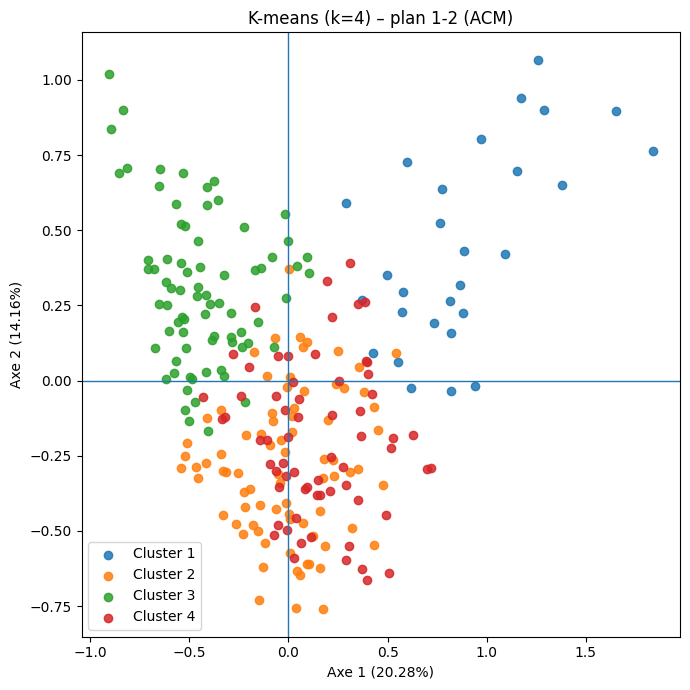

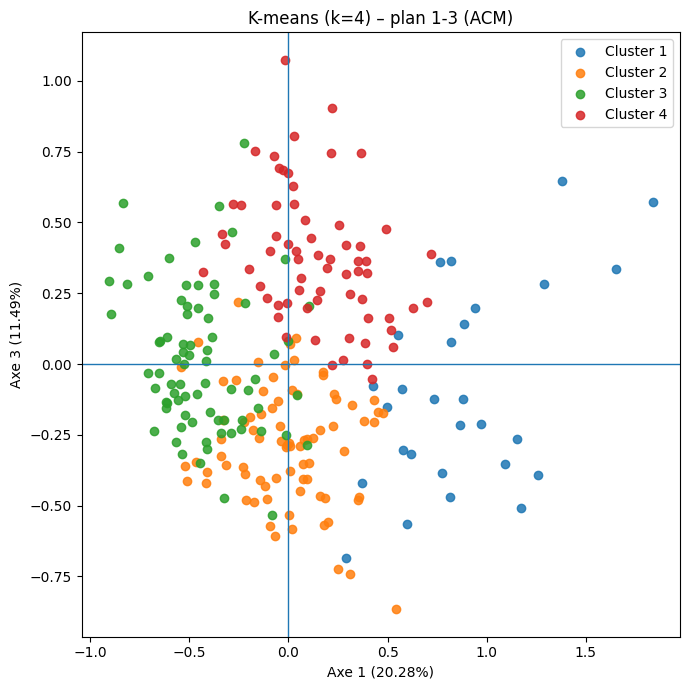

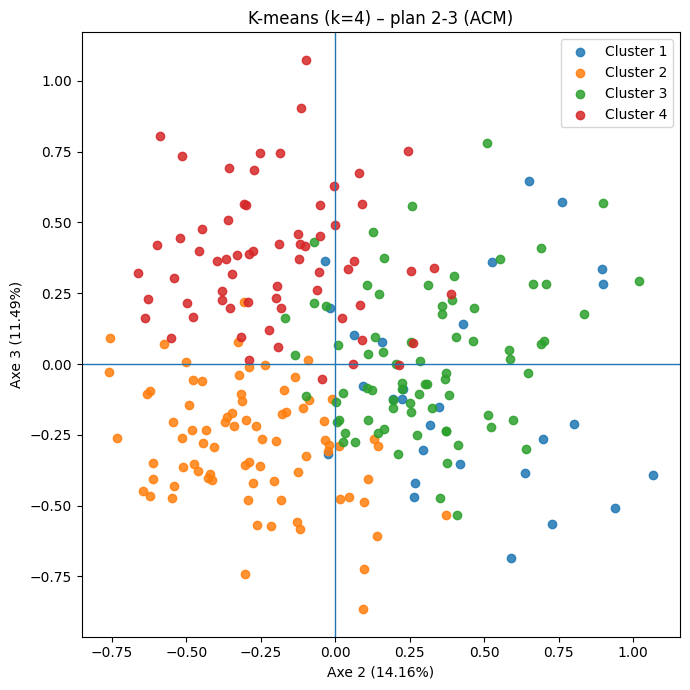

In [366]:
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency

# Paramètres K-means
auth_kmeans_k = 4           # k proposé par le dendrogramme
KM_RANDOM_STATE = 42
KM_N_INIT = 20

# ===============================
# === CARACTÉRISATION CLASSES ===
# ===============================

def characterize_clusters(df: pd.DataFrame, cluster_col: str, vars_categ: list[str], top_n: int = 10):
    rows = []
    N = len(df)
    for var in vars_categ:
        s_all = df[var].astype('category')
        cats = list(s_all.cat.categories)
        p_all = s_all.value_counts(normalize=True).reindex(cats).fillna(0.0)
        for g, sub in df.groupby(cluster_col):
            n_g = len(sub)
            s_g = sub[var].astype('category')
            p_g = s_g.value_counts(normalize=True).reindex(cats).fillna(0.0)
            for lvl in cats:
                p0 = float(p_all.loc[lvl])
                pg = float(p_g.loc[lvl])
                denom = sqrt(max(p0 * (1.0 - p0) / max(n_g, 1), 1e-12))
                v = (pg - p0) / denom if denom > 0 else 0.0
                rows.append(dict(
                    cluster=g,
                    variable=var,
                    modality=lvl,
                    n_cluster=n_g,
                    pct_cluster=100.0 * pg,
                    pct_overall=100.0 * p0,
                    diff_pct=100.0 * (pg - p0),
                    v_test=v
                ))
    res = pd.DataFrame(rows).sort_values(['cluster', 'v_test'], ascending=[True, False])
    tops = res[res['v_test'] > 0].groupby('cluster').head(top_n)
    return res, tops


# ---- Caractérisation par Chi² & V de Cramér ----

def chi2_cramers_by_variable(df: pd.DataFrame, cluster_col: str, vars_categ: list[str]) -> tuple[pd.DataFrame, dict[str, pd.DataFrame]]:
    """Résumé (chi2, ddl, p, V) par variable et résiduels standardisés.
    Retourne (summary_df, residuels_par_variable)."""
    out_rows = []
    resid_tables: dict[str, pd.DataFrame] = {}
    for var in vars_categ:
        tab = pd.crosstab(df[cluster_col], df[var])
        chi2, p, dof, expected = chi2_contingency(tab, correction=False)
        n = tab.values.sum()
        phi2 = chi2 / max(n, 1)
        r, c = tab.shape
        V = sqrt(phi2 / max(min(r - 1, c - 1), 1))
        out_rows.append(dict(variable=var, chi2=chi2, dof=int(dof), p_value=p, cramers_v=V))
        resid = (tab - expected) / np.sqrt(expected)
        resid_tables[var] = pd.DataFrame(resid, index=tab.index, columns=tab.columns)
    summary = pd.DataFrame(out_rows).sort_values('cramers_v', ascending=False)
    return summary, resid_tables

# -------------------------------------------------------------
# 1) K-MEANS SUR LES AXES DE L'ACM (réutilise row_space/row_coords)
# -------------------------------------------------------------
try:
    row_space_acm = row_space  # dimensions déjà retenues pour la CAH
except NameError:
    # Si 'row_space' n'existe pas (cas isolé), on retient les 2 premiers axes
    row_space_acm = row_coords.iloc[:, :min(3, row_coords.shape[1])]

km_acm = KMeans(n_clusters=auth_kmeans_k, n_init=KM_N_INIT, random_state=KM_RANDOM_STATE)
labels_acm = km_acm.fit_predict(row_space_acm)

# DataFrame résultats
vars_to_profile = list(varAct) + (list(varSup) if 'varSup' in globals() and isinstance(varSup, (list, tuple)) else [])
df_km_acm = df3.loc[row_space_acm.index].copy()
df_km_acm['cluster'] = pd.Series(labels_acm + 1, index=row_space_acm.index)

# (a) Surreprésentation (v-tests)
res_all_acm, tops_acm = characterize_clusters(df_km_acm, 'cluster', vars_to_profile, top_n=12)
# (b) Chi² & V de Cramér
chi2_acm, resid_acm = chi2_cramers_by_variable(df_km_acm, 'cluster', vars_to_profile)

print("=== K-means (ACM) ===")
print(f"k = {auth_kmeans_k}, observations = {len(df_km_acm)}")
try:
    print(f"Silhouette : {silhouette_score(row_space_acm, labels_acm):.3f}")
except Exception:
    pass
print("Top modalités surreprésentées (extrait):")
for g, sub in tops_acm.groupby('cluster'):
    print(f"Cluster {g}:")
    print(sub[['variable','modality','pct_cluster','pct_overall','diff_pct','v_test']].round(2).to_string(index=False))
print("Chi2 & V de Cramér (ACM):")
print(chi2_acm.round(4).to_string(index=False))

# Plans factoriels colorés par clusters K-means (réutilise row_coords)

def plot_km_plan(ax1: int, ax2: int):
    if ax1 == ax2 or ax1 < 1 or ax2 < 1: return
    if ax1 > row_coords.shape[1] or ax2 > row_coords.shape[1]: return
    fig, ax = plt.subplots(figsize=(7, 7))
    for g in sorted(df_km_acm['cluster'].unique()):
        mask = df_km_acm['cluster'] == g
        ax.scatter(row_coords.iloc[mask.values, ax1-1], row_coords.iloc[mask.values, ax2-1], label=f"Cluster {g}", alpha=0.85)
    ax.axhline(0, lw=1); ax.axvline(0, lw=1)
    try:
        ax.set_xlabel(f"Axe {ax1} ({inertia_pct[ax1-1]:.2f}%)"); ax.set_ylabel(f"Axe {ax2} ({inertia_pct[ax2-1]:.2f}%)")
    except Exception:
        ax.set_xlabel(f"Axe {ax1}"); ax.set_ylabel(f"Axe {ax2}")
    ax.set_title(f"K-means (k={auth_kmeans_k}) – plan {ax1}-{ax2} (ACM)")
    ax.legend(loc='best'); plt.tight_layout(); save_fig(fig, f"km_acm_{ax1}-{ax2}"); plt.show()

if row_coords.shape[1] >= 2:
    plot_km_plan(1, 2)
if row_coords.shape[1] >= 3:
    plot_km_plan(1, 3)
    plot_km_plan(2, 3)



--- Début de la Classification Ascendante Hiérarchique (CAH) ---


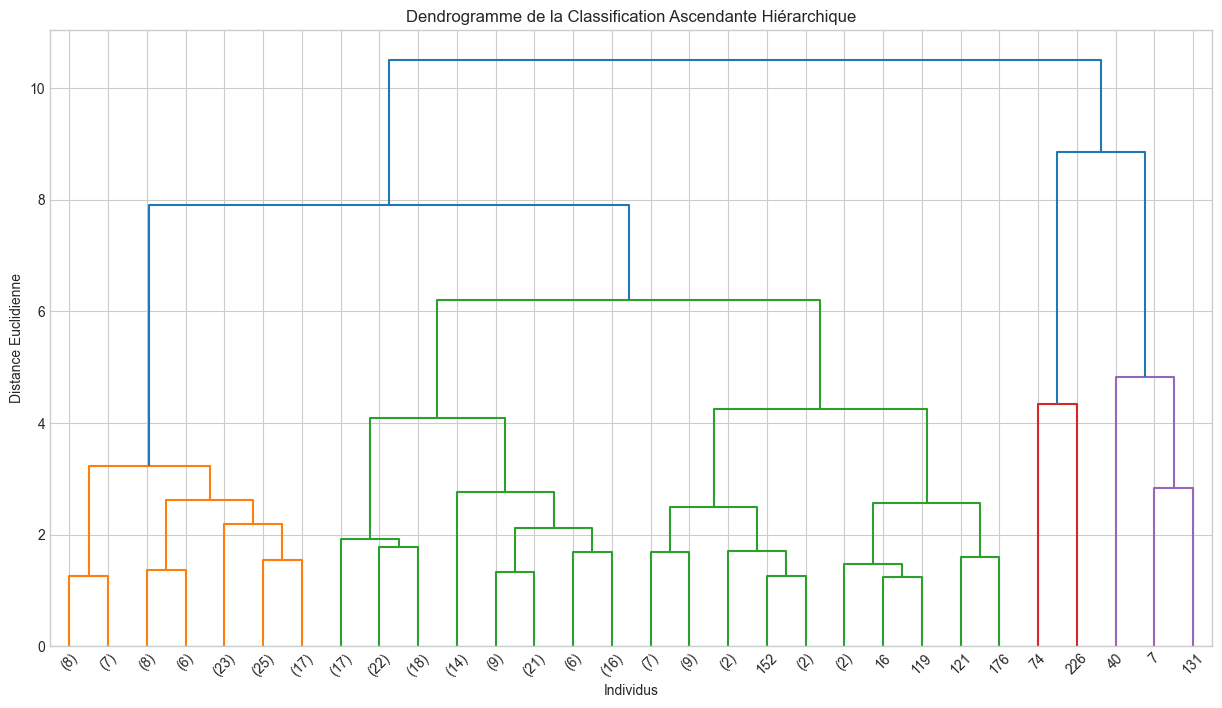

Les individus ont été regroupés en 5 clusters.

Analyse des Composantes Multiples (ACM) et CAH terminées.

--- Description des classes ---


C:\Users\user\AppData\Local\Temp\ipykernel_11064\764413413.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chi2_results = pd.concat([chi2_results, pd.DataFrame([{'Variable': var, 'Chi2': chi2, 'p-value': p}])], ignore_index=True)



Variables les plus discriminantes pour la formation des clusters (p-value < 0.05) :
   Variable        Chi2       p-value
11      q12  336.054075  8.324786e-62
5        q6  298.080522  1.187655e-56
1        q2  242.886505  1.484582e-42
10      q11  241.666000  2.639066e-42
6        q7  193.481321  1.641153e-32
15      q16  193.333730  1.757532e-32
16      q17  176.946556  3.444678e-29
3        q4  167.680435  2.442056e-27
7        q8  131.314607  3.564973e-20
0        q1  119.529176  6.765516e-18
14      q15  115.388446  4.209738e-17
2        q3  112.003170  1.864546e-16
8        q9  103.617848  7.238896e-15
4        q5   63.206451  5.839122e-09
13      q14   69.960736  1.013830e-08
12      q13   51.026165  1.571321e-05
9       q10   50.574706  1.855977e-05
19  equipe2  287.207694  1.553823e-03


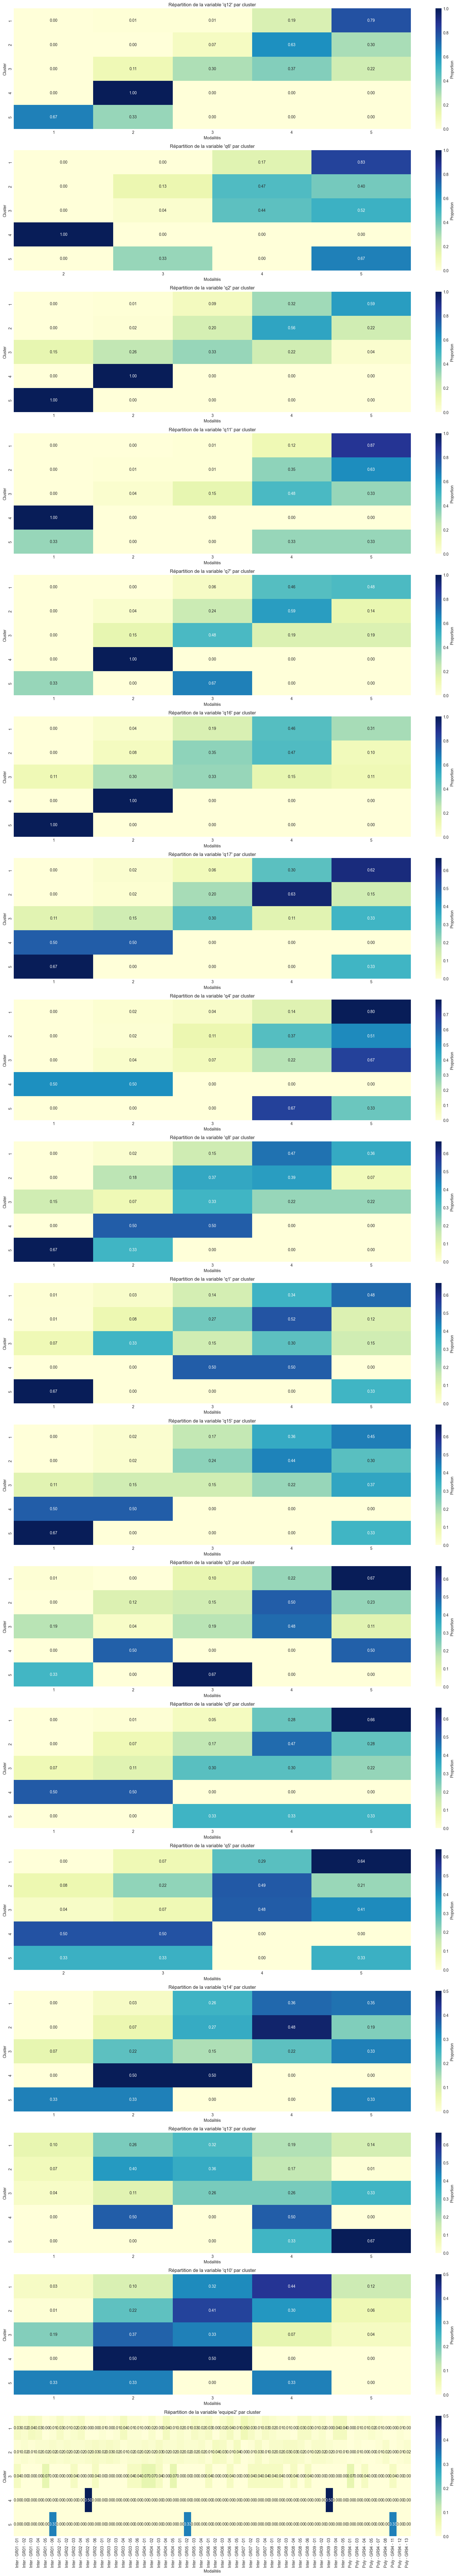


Description des classes terminée. Vous pouvez analyser les tableaux et les heatmaps ci-dessus.


In [137]:
#CAH

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# --- Section 5 : Classification Ascendante Hiérarchique (CAH) ---
print("\n--- Début de la Classification Ascendante Hiérarchique (CAH) ---")

# Utiliser les 5 premières dimensions de l'ACM pour la CAH
n_components_cah = 5
coords_cah = individuals_coords.iloc[:, :n_components_cah]

# Calculer la matrice des distances et le lien hiérarchique
# 'ward' minimise la variance intra-groupe
Z = linkage(coords_cah, method='ward', metric='euclidean')

# Afficher le dendrogramme pour déterminer le nombre de clusters
plt.figure(figsize=(15, 8))
plt.title("Dendrogramme de la Classification Ascendante Hiérarchique")
plt.xlabel("Individus")
plt.ylabel("Distance Euclidienne")
dendrogram(Z,
           truncate_mode='lastp',  # Affiche les p derniers clusters fusionnés
           p=30,                   # Nombre de clusters à afficher
           show_leaf_counts=True)
plt.show()

# Découper le dendrogramme pour former des clusters (par exemple, 4 clusters)
# Vous pouvez ajuster le nombre de clusters (k) en fonction du dendrogramme
k = 5
clusters = fcluster(Z, t=k, criterion='maxclust')
df2['cluster'] = clusters

print(f"Les individus ont été regroupés en {k} clusters.")
print("\nAnalyse des Composantes Multiples (ACM) et CAH terminées.")

# --- Section 6 : Description des classes ---
print("\n--- Description des classes ---")

# Liste des variables à analyser (actives et supplémentaires)
variables_to_analyze = varAct + varSup

# DataFrame pour stocker les résultats du test du Chi-carré
chi2_results = pd.DataFrame(columns=['Variable', 'Chi2', 'p-value'])

for var in variables_to_analyze:
    if var in df2.columns:
        # Créer le tableau de contingence entre la variable et les clusters
        contingency_table = pd.crosstab(df2['cluster'], df2[var])
        
        # Effectuer le test du Chi-carré
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        # Ajouter les résultats au DataFrame
        chi2_results = pd.concat([chi2_results, pd.DataFrame([{'Variable': var, 'Chi2': chi2, 'p-value': p}])], ignore_index=True)

# Trier les résultats pour trouver les variables les plus discriminantes (p-value faible)
chi2_results['p-value'] = pd.to_numeric(chi2_results['p-value'])
chi2_results = chi2_results.sort_values(by='p-value')

print("\nVariables les plus discriminantes pour la formation des clusters (p-value < 0.05) :")
print(chi2_results[chi2_results['p-value'] < 0.05])

# Visualiser la répartition des catégories pour les variables les plus discriminantes
top_variables = chi2_results[chi2_results['p-value'] < 0.05]['Variable'].tolist()

if top_variables:
    plt.figure(figsize=(18, 5 * len(top_variables)))
    for i, var in enumerate(top_variables):
        plt.subplot(len(top_variables), 1, i + 1)
        
        # Calculer les proportions de chaque modalité par cluster
        proportions = pd.crosstab(df2['cluster'], df2[var], normalize='index')
        
        sns.heatmap(proportions, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Proportion'})
        plt.title(f"Répartition de la variable '{var}' par cluster")
        plt.xlabel("Modalités")
        plt.ylabel("Cluster")
    
    plt.tight_layout()
    plt.show()
else:
    print("\nAucune variable n'a été trouvée comme significativement discriminante (p-value < 0.05).")

print("\nDescription des classes terminée. Vous pouvez analyser les tableaux et les heatmaps ci-dessus.")


In [144]:
# ACM

# --- Configuration de l'environnement et importations ---

# Définir un style pour les graphiques
sns.set_style("whitegrid")

# --- Définition des groupes de variables ---
# Identifiez vos variables actives et supplémentaires
varAct = ['q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']
varSup = ['ecole', 'groupe', 'equipe2', 'genre', 'nbPersEq2']


# --- 2. Réalisation de l'Analyse des Composantes Multiples (ACM) ---

# Créer une instance de l'ACM
# n_components=3 car vous voulez travailler avec un maximum de 3 axes
mca = prince.MCA(
    n_components=3,
    n_iter=15,        # Nombre d'itérations pour l'algorithme
    random_state=42   # Pour la reproductibilité des résultats
)

# Ajuster le modèle ACM uniquement sur les variables ACTIVES
# C'est la base de votre analyse
mca.fit(df2[varAct])

# --- 3. Extraction des coordonnées et de l'inertie ---

# Inertie (variance expliquée) par chaque axe
# Utile pour évaluer l'importance de chaque dimension
eigenvalues = mca.eigenvalues_


# Calculer l'inertie expliquée à partir des valeurs propres
explained_inertia = eigenvalues / eigenvalues.sum()




In [145]:
mca.row_contributions_.head()*100

0         1         2   
0  0.077697  0.021882  0.126838
1  0.014889  0.058353  0.814560
2  0.017698  0.018365  0.689654
3  0.030537  0.315912  1.617832
4  0.001514  0.000648  1.325516

In [146]:
#mca.column_contributions_*100
mca.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0            0.314        8.08%               8.08%          
1            0.206        5.30%              13.38%          
2            0.187        4.83%              18.20%

In [148]:
mca.plot(x=0,y=1)

IndexError: tuple index out of range

In [ ]:
print("--- Inertie (variance expliquée) par axe ---")
for i in range(mca.n_components):
    print(f"Axe {i+1}: Valeur propre = {eigenvalues[i]:.4f}, Inertie expliquée = {explained_inertia[i]*100:.2f}%")

# Coordonnées des individus sur les axes factoriels
individuals_coords = mca.row_coordinates(df2[varAct])
individuals_coords.columns = [f'Dim {i+1}' for i in range(mca.n_components)]

# Coordonnées des modalités des variables ACTIVES
# (Centres de gravité des individus ayant cette modalité)
active_categories_coords = mca.column_coordinates(df2[varAct])
active_categories_coords.columns = [f'Dim {i+1}' for i in range(mca.n_components)]

# Ajouter la variable et la catégorie comme colonnes pour la visualisation
# L'index est de la forme 'NomVariable_NomCategorie' (ex: 'Q1_A')
active_categories_coords['Variable'] = [idx.split('_')[0] for idx in active_categories_coords.index]
active_categories_coords['Category'] = [idx.split('_')[1] for idx in active_categories_coords.index]


# Coordonnées des modalités des variables SUPPLÉMENTAIRES
# Celles-ci sont calculées en projetant les centres de gravité des individus
# sur les axes déterminés par les variables actives.
supplementary_categories_coords = pd.DataFrame()
for sup_col in varSup:
    # Récupérer les coordonnées des individus
    temp_df = individuals_coords.copy()
    # Ajouter la colonne de la variable supplémentaire au DataFrame temporaire
    temp_df[sup_col] = df2[sup_col].values # Utiliser .values pour éviter les problèmes d'index

    # Calculer la moyenne des coordonnées pour chaque modalité de la variable supplémentaire
    coords = temp_df.groupby(sup_col).mean()
    coords['Variable'] = sup_col
    coords['Category'] = coords.index # La catégorie est l'index après le groupby
    supplementary_categories_coords = pd.concat([supplementary_categories_coords, coords])

print("\n--- Coordonnées des modalités actives (extrait) ---")
print(active_categories_coords.head())
print("\n--- Coordonnées des modalités supplémentaires (extrait) ---")
print(supplementary_categories_coords.head())


# --- 4. Génération des plans factoriels ---

# Définir les paires d'axes à visualiser
# On veut les plans avec les 3 premiers axes: (Dim1, Dim2), (Dim1, Dim3), (Dim2, Dim3)
axes_pairs = [(1, 2), (1, 3), (2, 3)]

for dim1_idx, dim2_idx in axes_pairs:
    dim1 = f'Dim {dim1_idx}'
    dim2 = f'Dim {dim2_idx}'

    plt.figure(figsize=(12, 10)) # Taille de la figure pour la lisibilité

    # 1. Plot des individus (en arrière-plan, très transparent)
    plt.scatter(individuals_coords[dim1], individuals_coords[dim2],
                alpha=0.05, s=10, color='gray', label='Individus')

    # 2. Plot des modalités des variables ACTIVES
    # Utilisation de Seaborn pour la coloration par variable
    sns.scatterplot(
        x=active_categories_coords[dim1],
        y=active_categories_coords[dim2],
        hue=active_categories_coords['Variable'],
        s=150, # Taille des points
        marker='o', # Marqueur pour les modalités actives
        edgecolor='black', # Bordure des points
        alpha=0.8,
        palette='tab10', # Une palette de couleurs distincte
        legend='full',
        label='Variables Actives'
    )

    # 3. Plot des modalités des variables SUPPLÉMENTAIRES
    # Avec un style différent pour les distinguer
    sns.scatterplot(
        x=supplementary_categories_coords[dim1],
        y=supplementary_categories_coords[dim2],
        hue=supplementary_categories_coords['Variable'],
        s=200, # Plus grande taille
        marker='X', # Marqueur différent
        edgecolor='red', # Bordure rouge
        linewidth=1.5,
        alpha=0.9,
        palette='viridis', # Autre palette de couleurs
        legend='full',
        ax=plt.gca(), # Assure que ces points sont sur le même graphique
        label='Variables Supplémentaires'
    )

    # Ajouter les labels de catégories à côté des points (peut rendre le graphique chargé si beaucoup de catégories)
    for i, row in pd.concat([active_categories_coords, supplementary_categories_coords]).iterrows():
        plt.text(row[dim1] + 0.01, row[dim2] + 0.01, row['Category'], fontsize=9, ha='left', va='bottom')

    # Ajouter l'origine et les labels des axes
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)

    plt.xlabel(f"{dim1} ({explained_inertia[dim1_idx-1]*100:.2f}%)")
    plt.ylabel(f"{dim2} ({explained_inertia[dim2_idx-1]*100:.2f}%)")
    plt.title(f"Plan Factoriel de l'ACM : {dim1} vs {dim2}")

    # Gérer la légende pour qu'elle ne chevauche pas le graphique
    handles, labels = plt.gca().get_legend_handles_labels()
    # Supprimer les labels dupliqués si sns.scatterplot crée une légende par variable
    # Gardez seulement une entrée pour 'Individus', 'Variables Actives', 'Variables Supplémentaires'
    # Cette partie peut nécessiter un ajustement si vous avez de nombreuses légendes 'hue'
    unique_labels = {}
    for h, l in zip(handles, labels):
        if 'Variable' not in l: # N'ajoute pas les labels de variable si ce n'est pas nécessaire
            unique_labels[l] = h # Stocke seulement les entrées uniques
    plt.legend(unique_labels.values(), unique_labels.keys(), title='Légende', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.88, 1]) # Ajuste la mise en page pour laisser de la place à la légende
    plt.show()

print("\nAnalyse des Composantes Multiples (ACM) terminée et plans factoriels générés.")

In [95]:
varAct = ['q1', 'q2', 'q3', 'q4','q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']
varSup = ['ecole', 'groupe', 'equipe2', 'genre', 'nbPersEq2']
colAnalyse = varSup
print(colAnalyse)
colAnalyse = colAnalyse.__add__(varAct)
print(colAnalyse)

['ecole', 'groupe', 'equipe2', 'genre', 'nbPersEq2']
['ecole', 'groupe', 'equipe2', 'genre', 'nbPersEq2', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17']


TEST DE LA LIBRAIRIE AUTOVIZ

In [400]:
from autoviz import AutoViz_Class

AV = AutoViz_Class()
dft = AV.AutoViz(df3,chart_format='bokeh')

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)
Shape of your Data Set loaded: (249, 32)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  1
    Number of Integer-Categorical Columns =  1
    Number of String-Categorical Columns =  4
    Number of Factor-Categorical Columns =  18
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  6
    Number of

BokehModel(combine_events=True, render_bundle={'docs_json': {'d8eaf539-c285-4990-baff-a8fa661bfe4f': {'version…

BokehModel(combine_events=True, render_bundle={'docs_json': {'27967760-1150-42e6-ab33-56225d8d8ccc': {'version…

No date vars could be found in data set


BokehModel(combine_events=True, render_bundle={'docs_json': {'ee48ed2d-1560-4135-b005-aee7a709a6bd': {'version…

BokehModel(combine_events=True, render_bundle={'docs_json': {'23c4f411-7728-47e2-8180-49513ca20cd6': {'version…

Time to run AutoViz (in seconds) = 15
